# Описание задачи

**Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.**

## Данные с которыми требуется работа

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
    - Коричневый карлик	0
    - Красный карлик	1
    - Белый карлик	2
    - Звёзды главной последовательности	3
    - Сверхгигант	4
    - Гипергигант
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

Импортируем библиотеки и модули:

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import copy

import matplotlib.pyplot as plt
import seaborn as sns

import random
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 1

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    data = pd.read_csv('6_class.csv')
except:
    data = pd.read_csv('/datasets/6_class.csv')

## Предобработка и анализ данных

Общая информация о данных:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Пропусков нет.

Что лежит в столбцах:

Признаки:

- `Luminosity(L/Lo)` -- относительная светимость звезды относительно Солнца

- `Radius(R/Ro)` -- относительный радиус звезды относительно Солнца

- `Absolute magnitude(Mv)` -- абсолютная звёздная величина, характеризующая блеск звезды

- `Star type` -- тип звезды

- `Star color` -- цвет звезды, который определяют на основе спектрального анализа

Целевой признак:

- `Temperature` -- температура

Столбец `Unnamed` не упоминался в документации, посмотрим, что там:

In [4]:
if 'Unnamed: 0' in data.columns:
    data['Unnamed: 0'].describe().to_frame()

 Нечто неинформативное, удалим столбец, чтобы избежать помех:

In [5]:
if 'Unnamed: 0' in data.columns:
    data = data.drop(['Unnamed: 0'], axis=1)

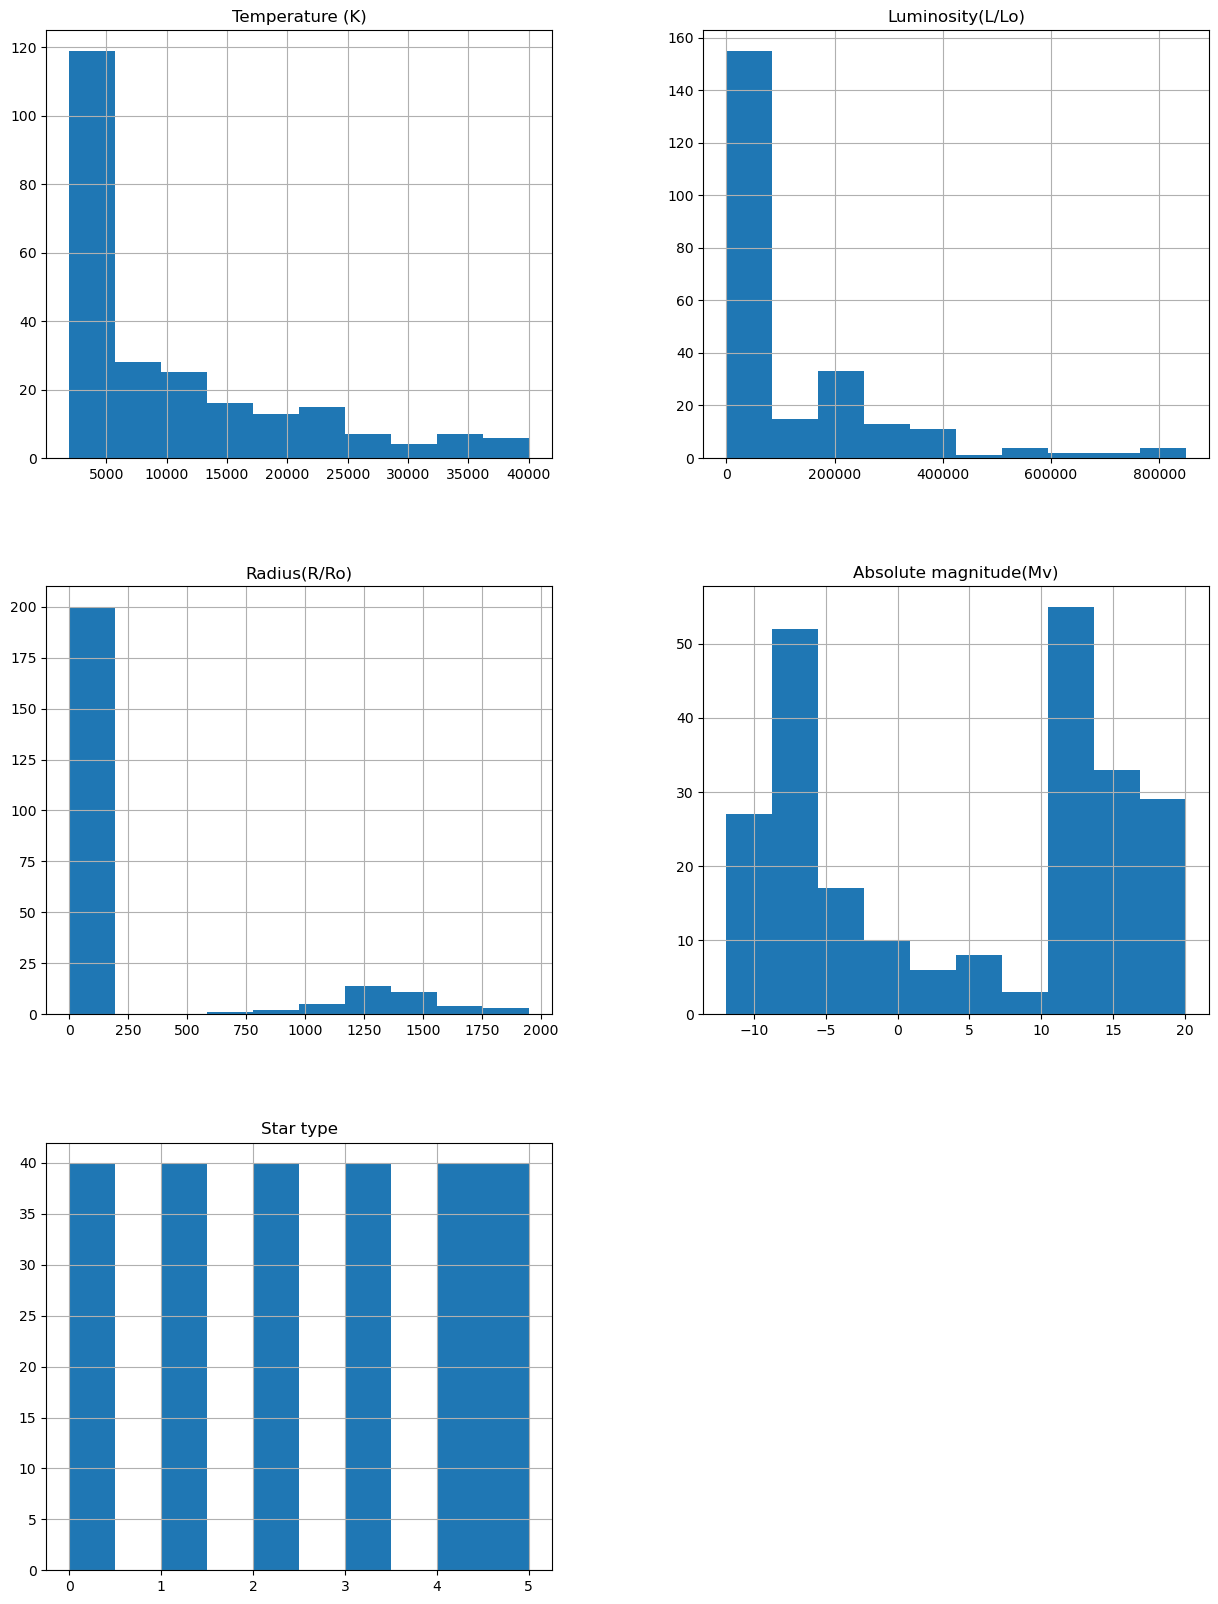

In [6]:
data.hist(figsize=(15, 20));

На первый взгляд аномалий не наблюдается. Тем не менее, изучим данные в каждом столбце, обработаем аномальные значения, если они всё же встретятся:

### Столбец `Temperature (K)`:

Сменим название на удобное:

In [7]:
data.rename(columns = {'Temperature (K)':'Temperature'}, inplace = True)

In [8]:
data['Temperature'].describe().to_frame()

Temperature
count    240.000000
mean   10497.462500
std     9552.425037
min     1939.000000
25%     3344.250000
50%     5776.000000
75%    15055.500000
max    40000.000000

Аномальных значений не наблюдается. Продолжим.

Для построения диаграмм в дальнейшем нам понадобится столбец с температурой звезды. Сохраним его в отдельную переменную:

In [9]:
df_st_temp = data.Temperature.copy()

### Столбец `Luminosity(L/Lo)`:

Сменим название на удобное:

In [10]:
data.rename(columns = {'Luminosity(L/Lo)':'Luminosity'}, inplace = True)

In [11]:
data['Luminosity'].describe().to_frame()

Luminosity
count     240.000000
mean   107188.361635
std    179432.244940
min         0.000080
25%         0.000865
50%         0.070500
75%    198050.000000
max    849420.000000

Аномальных значений не наблюдается. Продолжим.

### Столбец `Radius(R/Ro)`:

Сменим название на удобное:

In [12]:
data.rename(columns = {'Radius(R/Ro)':'Radius'}, inplace = True)

In [13]:
data['Radius'].describe().to_frame()

Radius
count   240.000000
mean    237.157781
std     517.155763
min       0.008400
25%       0.102750
50%       0.762500
75%      42.750000
max    1948.500000

Аномальных значений не наблюдается. Продолжим.

### Столбец `Absolute magnitude(Mv)`:

Сменим название на удобное:

In [14]:
data.rename(columns = {'Absolute magnitude(Mv)':'Absolute magnitude'}, inplace = True)

In [15]:
data['Absolute magnitude'].describe().to_frame()

Absolute magnitude
count          240.000000
mean             4.382396
std             10.532512
min            -11.920000
25%             -6.232500
50%              8.313000
75%             13.697500
max             20.060000

Наверное, с точки зрения физики, значение изучаемой величины может быть отрицательной. Будем считать, что аномальных значений не наблюдается. Продолжим.

### Столбец `Star type`:

Сменим название на удобное:

In [16]:
data.rename(columns = {'Star type':'StarType'}, inplace = True)

In [17]:
data['StarType'].unique()

array([0, 1, 2, 3, 4, 5])

Аномальных значений не наблюдается. Продолжим.

Для построения диаграмм в дальнейшем нам понадобится столбец с типом звезды. Сохраним его в отдельную переменную:

In [18]:
df_st_type = data.StarType.copy()

### Столбец `Star color`:

Сменим название на удобное:

In [19]:
data.rename(columns = {'Star color':'StarColor'}, inplace = True)

In [20]:
sorted(data['StarColor'].unique())

['Blue',
 'Blue ',
 'Blue White',
 'Blue white',
 'Blue white ',
 'Blue-White',
 'Blue-white',
 'Orange',
 'Orange-Red',
 'Pale yellow orange',
 'Red',
 'White',
 'White-Yellow',
 'Whitish',
 'Yellowish',
 'Yellowish White',
 'white',
 'yellow-white',
 'yellowish']

Наблюдаются неявные дубликаты и очень похожие друг на друга цвета. Избавимся от них:

In [21]:
def restring(col):
    col1 = col.lower()
    col2 = col1.replace('-', '')
    col3 = col2.replace(' ', '')
    return col3

data['StarColor'] = data['StarColor'].apply(restring)
data.loc[data['StarColor'] == 'whiteyellow', 'StarColor'] = 'yellowwhite'
data['StarColor'].unique()

array(['red', 'bluewhite', 'white', 'yellowishwhite', 'paleyelloworange',
       'blue', 'whitish', 'yellowwhite', 'orange', 'yellowish',
       'orangered'], dtype=object)

In [22]:
data.groupby(by='StarColor')['StarColor'].count()

StarColor
blue                 56
bluewhite            41
orange                2
orangered             1
paleyelloworange      1
red                 112
white                10
whitish               2
yellowish             3
yellowishwhite        3
yellowwhite           9
Name: StarColor, dtype: int64

In [23]:
change_color = ['orange', 'orangered', 'paleyelloworange', 'whitish', 'yellowish', 'yellowishwhite']
for col in change_color:
    data.loc[data['StarColor'] == col, 'StarColor'] = 'other'
data['StarColor'].unique()

array(['red', 'bluewhite', 'white', 'other', 'blue', 'yellowwhite'],
      dtype=object)

Проблемы исчезли.

### Изучим, как в разрезе типа и цвета звезд распределены данные

### Столбец `Temperature (K)`:

<AxesSubplot:xlabel='StarColor', ylabel='Temperature'>

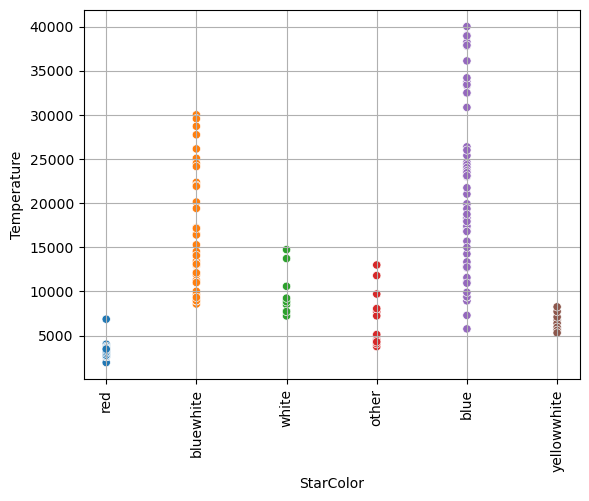

In [24]:
plt.xticks(rotation = 90)
plt.grid()
sns.scatterplot(data=data, x="StarColor", y="Temperature", hue='StarColor', legend=False)

<AxesSubplot:xlabel='StarType', ylabel='Temperature'>

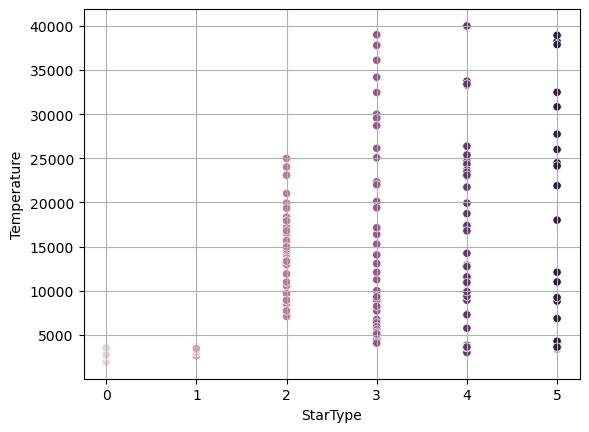

In [25]:
plt.grid()
sns.scatterplot(data=data, x="StarType", y="Temperature", hue='StarType', legend=False)

**Вывод:** Самые холодные звезды имеют от желтого до красного цветов, самые горячие - от белого до синего. \
Наиболее разнообразная температура наблюдается среди Звезд главной последовательности, в меньшей степени у Сверхгигантов и Гипергигантов. Самыми холодными являются звезды-карлики

### Столбец `Luminosity(L/Lo)`:

<AxesSubplot:xlabel='StarColor', ylabel='Luminosity'>

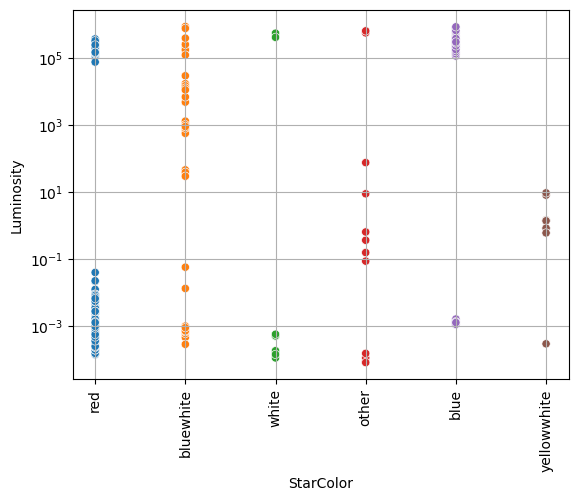

In [26]:
plt.yscale('log')
plt.xticks(rotation = 90)
plt.grid()
sns.scatterplot(data=data, x="StarColor", y="Luminosity", hue='StarColor', legend=False)

<AxesSubplot:xlabel='StarType', ylabel='Luminosity'>

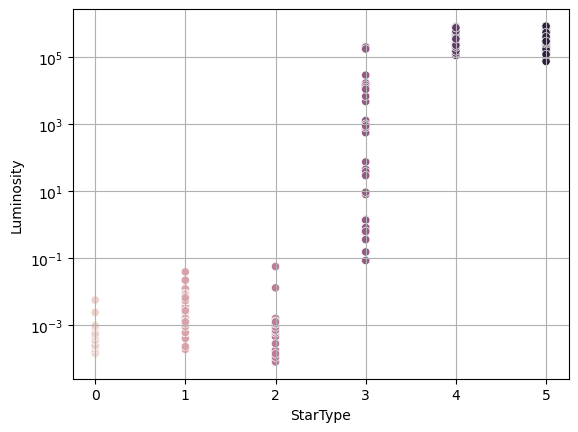

In [27]:
plt.yscale('log')
plt.grid()
sns.scatterplot(data=data, x="StarType", y="Luminosity", hue='StarType', legend=False)

**Вывод:** Карлики светятся примерно так же, как и Солнце. Примерно половина звезд из данных похожи на Солнце, а половина отличается по светимости. 

### Столбец `Radius(R/Ro)`:

<AxesSubplot:xlabel='StarColor', ylabel='Radius'>

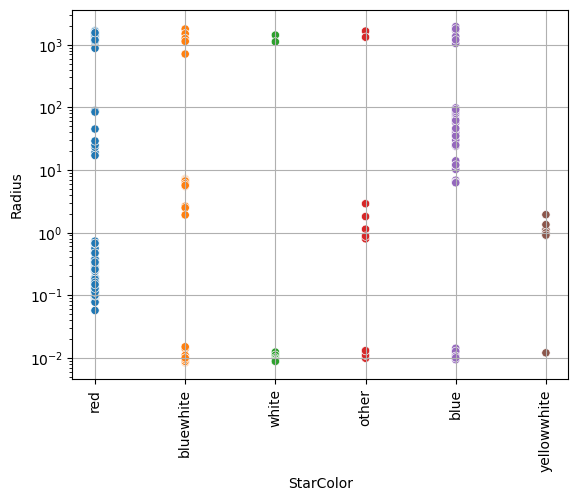

In [28]:
plt.yscale('log')
plt.xticks(rotation = 90)
plt.grid()
sns.scatterplot(data=data, x="StarColor", y="Radius", hue='StarColor', legend=False)

<AxesSubplot:xlabel='StarType', ylabel='Radius'>

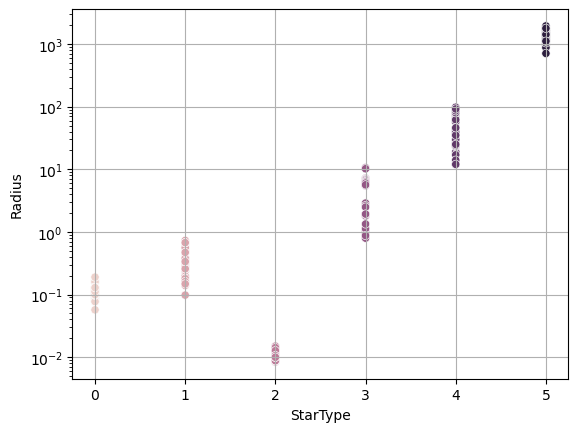

In [29]:
plt.yscale('log')
plt.grid()
sns.scatterplot(data=data, x="StarType", y="Radius", hue='StarType', legend=False)

**Вывод:** Каждому типу звезды соответствует определенный диапозон размеров. По сути, по радиусу можно восстановить тип звезды с некоторой погрешностью.

### Столбец `Absolute magnitude(Mv)`:

<AxesSubplot:xlabel='StarColor', ylabel='Absolute magnitude'>

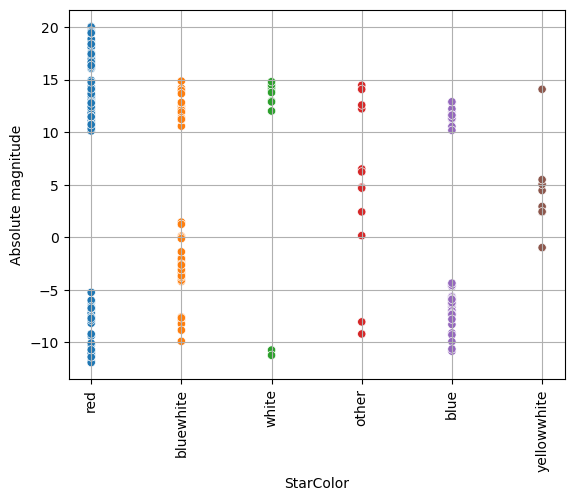

In [30]:
plt.xticks(rotation = 90)
plt.grid()
sns.scatterplot(data=data, x="StarColor", y="Absolute magnitude", hue='StarColor', legend=False)

<AxesSubplot:xlabel='StarType', ylabel='Absolute magnitude'>

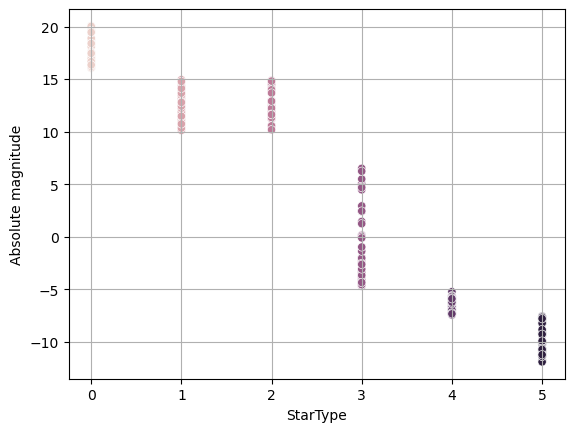

In [31]:
plt.grid()
sns.scatterplot(data=data, x="StarType", y="Absolute magnitude", hue='StarType', legend=False)

**Вывод:** Каждому типу звезды соответствует определенный диапозон значений светимости. По светимости можно определить тип зведы

In [32]:
data.columns

Index(['Temperature', 'Luminosity', 'Radius', 'Absolute magnitude', 'StarType',
       'StarColor'],
      dtype='object')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         240 non-null    int64  
 1   Luminosity          240 non-null    float64
 2   Radius              240 non-null    float64
 3   Absolute magnitude  240 non-null    float64
 4   StarType            240 non-null    int64  
 5   StarColor           240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


### Разбиение на выборки

Разобъём данные на выборки:

In [34]:
features = data.drop('Temperature', axis=1)
target = data['Temperature']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(180, 5) (180,)
(60, 5) (60,)


In [35]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Luminosity          240 non-null    float64
 1   Radius              240 non-null    float64
 2   Absolute magnitude  240 non-null    float64
 3   StarType            240 non-null    int64  
 4   StarColor           240 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 9.5+ KB


### Закодируем количественные признаки и масштабируем количественные с использованием Pipeline

In [36]:
num_cols = features.select_dtypes(exclude='object').columns.tolist()
cat_cols = features.select_dtypes(include='object').columns.tolist()

print(num_cols)
print(cat_cols)

['Luminosity', 'Radius', 'Absolute magnitude', 'StarType']
['StarColor']


In [37]:
pipe_num = Pipeline(steps=[('scaler', StandardScaler())])
pipe_cat = Pipeline(steps=[('ohe', OneHotEncoder())])

cols_transform = ColumnTransformer(transformers=[('trans_num', pipe_num, num_cols), 
                                                 ('trans_cat', pipe_cat, cat_cols)], remainder='passthrough', 
                                                 n_jobs=-1)
cols_transform.fit(features_train)

features = cols_transform.transform(features)
features_train = cols_transform.transform(features_train)
features_test = cols_transform.transform(features_test)

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Готово.

## Построение базовой нейронной сети

In [38]:
random.seed(42)
np.random.seed(6996)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

Готовим тензоры по обучающей и тестовой выборке:

In [39]:
X_train = torch.FloatTensor(features_train)
X_test = torch.FloatTensor(features_test)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [40]:
len(X_train)

180

Инициализируем нейронную сеть с одним скрытым слоем. Подробности причин выбора гиперпараметров будут ниже.

Технические массивы, где будет храниться информация для построения графиков:

In [41]:
xx = []
yy_train = []
yy_test = []

Сеть будет с *одним* скрытым слоем, со следующим числом входных и выходных нейронов для каждого слоя:

In [42]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 14
n_out_neurons = 1 

Функция потерь:

In [43]:
loss = nn.MSELoss()

Инициализация класса модели:

In [44]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Linear(1, 1)

        nn.init.uniform_(self.fc1.weight, a=1, b=2)
        nn.init.uniform_(self.fc1.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=1)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0, std=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x


In [45]:
%%time


net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

#batch_size = len(X_train)
batch_size = 40

num_epochs = 10000

num_batches = ceil(len(X_train)/batch_size)


RMSE_MIN_TEST = None
best_net = None


for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = net.forward(X_batch).flatten()
        
        loss_value = loss(preds, y_batch)

        loss_value.backward()
        
        optimizer.step()
    
    net.eval()
    test_preds = net.forward(X_test).flatten()
    RMSE = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)
    
    if epoch == 0:
        RMSE_MIN_TEST = RMSE
        best_net = copy.deepcopy(net)
    else:
        if RMSE_MIN_TEST > RMSE:
            RMSE_MIN_TEST = RMSE
            best_net = copy.deepcopy(net)   
    
    #ARRAY.append([net.fc1.weight, net.fc1.bias, net.fc2.weight, net.fc2.bias, net.fc3.weight, net.fc3.bias])
    
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        
        test_preds = net.forward(X_test).flatten()
        RMSE_test = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)
        
        train_preds = net.forward(X_train).flatten()
        RMSE_train = round(np.sqrt(mse(train_preds.detach().numpy(), y_train.detach().numpy())), 2)
        
        xx.append(epoch)
        yy_train.append(RMSE_train)
        yy_test.append(RMSE_test)
        
        print(f'RMSE_test = {RMSE_test}, RMSE_train = {RMSE_train}, RMSE_MIN_TEST = {RMSE_MIN_TEST}, epoch = {epoch}')
        #print(f'epoch = {epoch}, RMSE = {RMSE}, RMSE_MIN_TEST = {RMSE_MIN_TEST}')

RMSE_test = 13784.5498046875, RMSE_train = 14309.650390625, RMSE_MIN_TEST = 13784.5498046875, epoch = 0
RMSE_test = 5830.330078125, RMSE_train = 5149.97998046875, RMSE_MIN_TEST = 5830.330078125, epoch = 1000
RMSE_test = 5052.4501953125, RMSE_train = 4698.02978515625, RMSE_MIN_TEST = 5052.4501953125, epoch = 2000
RMSE_test = 4483.27001953125, RMSE_train = 4281.93994140625, RMSE_MIN_TEST = 4473.64990234375, epoch = 3000
RMSE_test = 4583.56005859375, RMSE_train = 3987.679931640625, RMSE_MIN_TEST = 4360.740234375, epoch = 4000
RMSE_test = 4901.91015625, RMSE_train = 3909.2900390625, RMSE_MIN_TEST = 4360.740234375, epoch = 5000
RMSE_test = 5202.3701171875, RMSE_train = 3866.889892578125, RMSE_MIN_TEST = 4360.740234375, epoch = 6000
RMSE_test = 5296.72021484375, RMSE_train = 3824.889892578125, RMSE_MIN_TEST = 4360.740234375, epoch = 7000
RMSE_test = 5352.3701171875, RMSE_train = 3788.639892578125, RMSE_MIN_TEST = 4360.740234375, epoch = 8000
RMSE_test = 5329.31982421875, RMSE_train = 3740.77

График, который демонстрирует динамику изменения значений метрики RMSE на тренировочной и тестовой выборках:

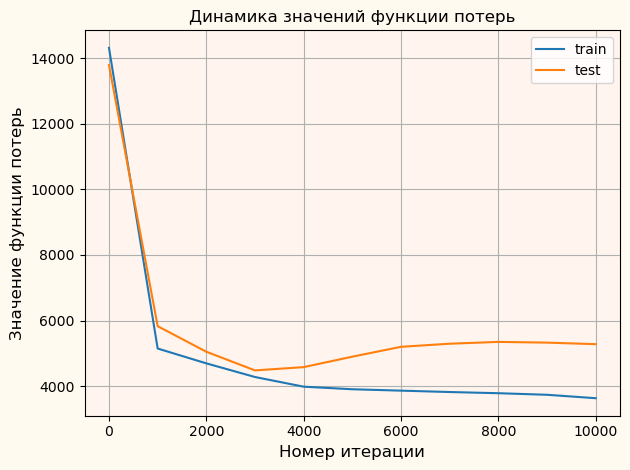

In [46]:
fig, ax = plt.subplots()

ax.plot(xx, yy_train, label='train')
ax.plot(xx, yy_test, label='test')

ax.set_xlabel('Номер итерации', fontsize=12)
ax.set_ylabel('Значение функции потерь', fontsize=12)

fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

ax.set_title('Динамика значений функции потерь')

ax.grid(True)
fig.tight_layout()

ax.legend() 
plt.show()

По графику видно, что сеть начинает переобучаться примерно после 2000 итерации. Хотя потом после небольшого роста значения функции потерь на тесте снова начинают падать. 

Итоговое качество модели с лучшими результатами на тесте::

In [47]:
X = torch.FloatTensor(features) 
Y = torch.FloatTensor(target.values)

round(np.sqrt(mse(best_net.forward(X).flatten().detach().numpy(), Y)), 2)

4178.55

### Краткие выводы:

- По какой-то причине `BatchNorm` иногда ухудшал результаты. 
- Для задачи регрессии подходят функции вида `ReLU` и `Linear`. Были перепробованы разные вариации. Наилучшие результаты дала стандартная `ReLU`.
- Во время инициализации весов пробовалось использовать равномерное и нормальное распределение. Наилучшие результаты дала комбинация `равномерного распределения на [1, 2]` в начале и `два стандартных нормальных распределения` на остальных слоях.
- В соотношении время/качество оптимальное количество эпох составило 15000, размер батчей 80.
- От запуска к запуску качество модели меняется. Кажется, что это связано с "какой-то случацностью". Подозреваю, что дело в строках с начальной инициализацией. Но почему так -- не понимаю, ведь в ячейке выше были специально указаны значения random seed для всех рандомайзеров. Лучший показатель, который удавалось достичь, был 3424
- Была попытка фиксировать в массиве веса сети, которая показала наилучший результат. Но разобраться с тем, как потом быстро создать сеть с такими параметрами не удалось. Пришлось копировать сеть с помощью `copy.deep()`

Построим столбцовый график с фактической и прогнозируемой моделью средней температурой по всем звёздам из выборки. Для этого сначала соберём в одну таблицу информацию о реальной температуре звёзд и прогнозируемой:

In [48]:
Temperature_pred = pd.Series(best_net.forward(X_test).flatten().detach().numpy(), name='Temperature_pred')
df = pd.concat([target_test.reset_index(drop=True), Temperature_pred], axis=1)
df

Temperature  Temperature_pred
0         23095      21576.521484
1          3523       3363.577637
2         13720       9978.431641
3         11250      17724.074219
4         34190      31429.511719
5          1939       3348.281494
6          4980       4421.566406
7          7700      11234.096680
8          3570       4175.414062
9          8829      15866.614258
10        32489      40116.093750
11         3146       3166.019531
12         3324       3351.460205
13         5800       9230.920898
14        17920      19905.085938
15        32460      31298.322266
16         3459       3518.560791
17         2871       3299.326172
18         8250       2728.960693
19        12893      19369.693359
20         3610       3881.258789
21         3625       2876.141357
22         3008       2867.974121
23        36108      31630.939453
24        30839      28913.484375
25        37882      26984.240234
26         2817       3298.126465
27         2914       3218.473145
28         5587       9223.682617
29        19860      20030.998047
30         8924      11587.617188
31         9383      20376.048828
32        15680      19802.767578
33         9675      11937.839844
34        12675      22302.707031
35         5936       8981.974609
36        30000      19496.193359
37         3192       3172.073730
38         5752      20433.257812
39         6850       3827.369629
40         3441       3392.279297
41         5300       9318.455078
42         3750       3806.237061
43         9700       2159.379883
44         2983       3399.295898
45         8052       3263.939453
46         3129       3385.897217
47         7230      11387.569336
48         3068       3390.561279
49         3600       3676.150391
50         3150       3380.659668
51         3218       3136.826660
52         7723       9325.591797
53         3752       2740.601318
54         4526       5401.754883
55        11790      11973.924805
56         2799       2707.755615
57         2861       3225.054932
58         3100       3390.868164
59         2621       3350.235596

Отсюда, ожидаемо, видим, что температуры для типов звёзд 1 и 0 приблизились плохо:

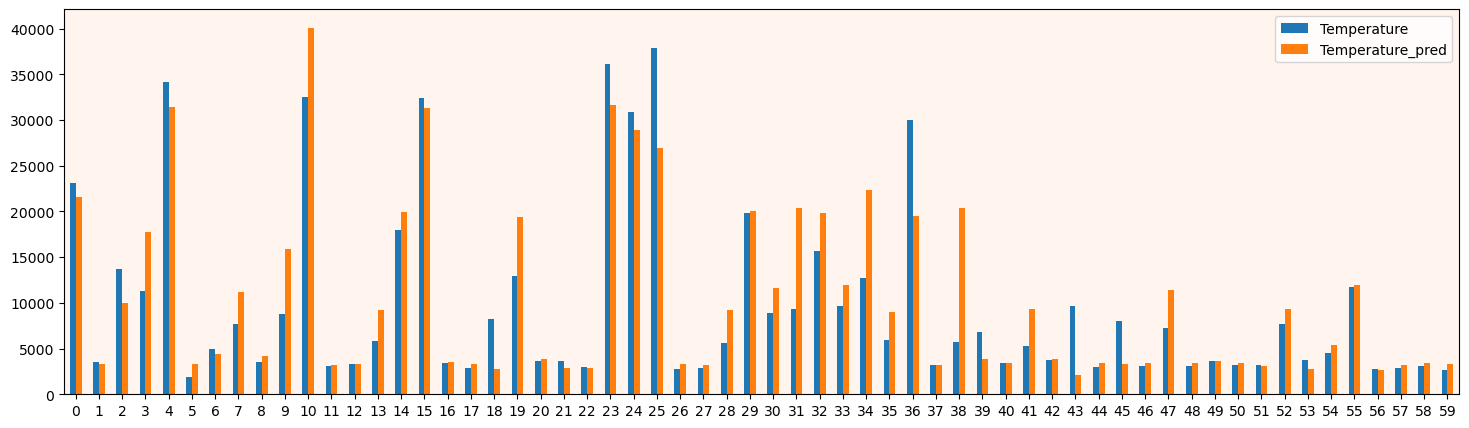

In [49]:
ax = df.plot.bar(y=['Temperature', 'Temperature_pred'], rot=0, figsize=(18, 5))

ax.set_facecolor('seashell')

plt.show()

## Улучшение нейронной сети

Попробуем улучшить нейронную сеть. 

Нам доступно измененние количества эпох, изменение размера батчей, а также отключение некоторого количества нейронов с помощью `Dropout`. Менять увеличивать количество эпох не станем, положим их равным 3000 (базовая модель показала, что примерно после этого числа началось переобучение). 

Напишем алгоритм, который будет перебирать три этих параметра:

Есть гипотеза, что перебирать размеры батчей можно независимо от отключения нейронов. Для ускорения процесса сначала будем перебирать только размеры батчей. Потом возьмёмся за отключение нейронов.

In [50]:
#Верхняя граница размеров батчей:
ButchCeil = len(X_train)
#Нижняя граница размера батчей:
ButchFloor = 10
#Шаг, с которым перебирать размеры:
ButchStepCeil = 10

RMSE_test = 13586.5595703125, RMSE_train = 14151.740234375, RMSE_MIN_TEST = 13586.5595703125, epoch = 0
RMSE_test = 5900.72021484375, RMSE_train = 5226.5, RMSE_MIN_TEST = 5900.72021484375, epoch = 250
RMSE_test = 5480.33984375, RMSE_train = 4995.580078125, RMSE_MIN_TEST = 5477.4501953125, epoch = 500
RMSE_test = 5088.35986328125, RMSE_train = 4835.52978515625, RMSE_MIN_TEST = 5088.35986328125, epoch = 750
RMSE_test = 4737.31982421875, RMSE_train = 4698.41015625, RMSE_MIN_TEST = 4737.31982421875, epoch = 1000
RMSE_test = 4550.919921875, RMSE_train = 4588.5498046875, RMSE_MIN_TEST = 4547.27978515625, epoch = 1250
RMSE_test = 4425.2099609375, RMSE_train = 4497.33984375, RMSE_MIN_TEST = 4423.6298828125, epoch = 1499
BUTCH_LENGTH = 10, RMSE_MIN_TEST = 4423.6298828125


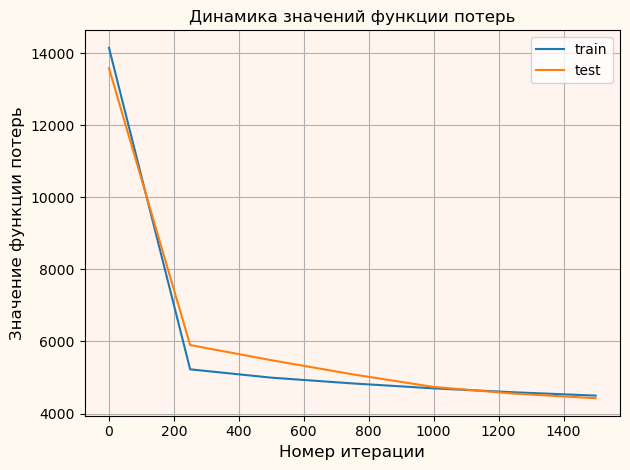

RMSE_test = 13706.0302734375, RMSE_train = 14244.5595703125, RMSE_MIN_TEST = 13706.0302734375, epoch = 0
RMSE_test = 6402.7998046875, RMSE_train = 5603.89990234375, RMSE_MIN_TEST = 6402.7998046875, epoch = 250
RMSE_test = 5875.259765625, RMSE_train = 5178.35009765625, RMSE_MIN_TEST = 5868.7900390625, epoch = 500
RMSE_test = 5607.580078125, RMSE_train = 5042.06005859375, RMSE_MIN_TEST = 5604.14990234375, epoch = 750
RMSE_test = 5365.56005859375, RMSE_train = 4946.77978515625, RMSE_MIN_TEST = 5359.509765625, epoch = 1000
RMSE_test = 4927.08984375, RMSE_train = 4770.509765625, RMSE_MIN_TEST = 4927.08984375, epoch = 1250
RMSE_test = 4426.60009765625, RMSE_train = 4581.06005859375, RMSE_MIN_TEST = 4426.60009765625, epoch = 1499
BUTCH_LENGTH = 20, RMSE_MIN_TEST = 4426.60009765625


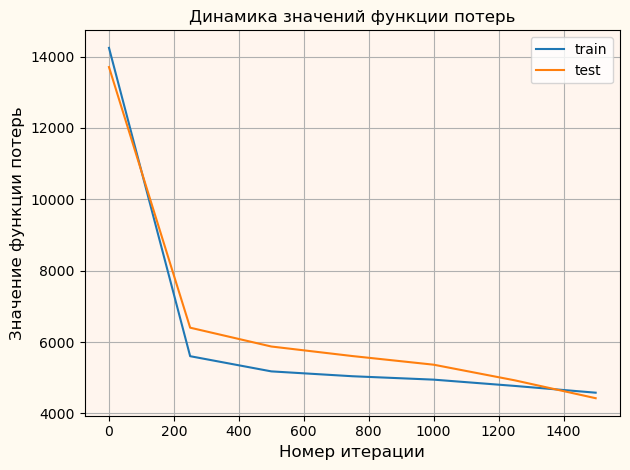

RMSE_test = 14144.759765625, RMSE_train = 14628.33984375, RMSE_MIN_TEST = 14144.759765625, epoch = 0
RMSE_test = 6613.490234375, RMSE_train = 6092.68994140625, RMSE_MIN_TEST = 6613.490234375, epoch = 250
RMSE_test = 5972.64990234375, RMSE_train = 5290.35986328125, RMSE_MIN_TEST = 5972.64990234375, epoch = 500
RMSE_test = 5720.56982421875, RMSE_train = 5112.7998046875, RMSE_MIN_TEST = 5720.5, epoch = 750
RMSE_test = 5442.5400390625, RMSE_train = 4985.56982421875, RMSE_MIN_TEST = 5441.1201171875, epoch = 1000
RMSE_test = 5079.2001953125, RMSE_train = 4831.52001953125, RMSE_MIN_TEST = 5079.2001953125, epoch = 1250
RMSE_test = 4707.14990234375, RMSE_train = 4657.759765625, RMSE_MIN_TEST = 4707.14990234375, epoch = 1499
BUTCH_LENGTH = 30, RMSE_MIN_TEST = 4707.14990234375


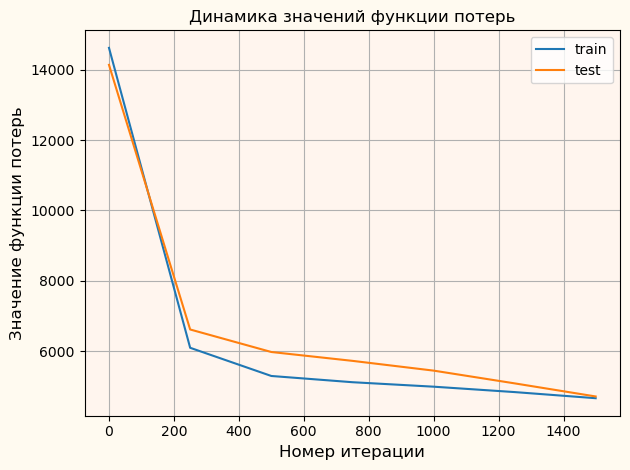

RMSE_test = 13939.900390625, RMSE_train = 14451.2802734375, RMSE_MIN_TEST = 13939.900390625, epoch = 0
RMSE_test = 6303.39013671875, RMSE_train = 5553.39990234375, RMSE_MIN_TEST = 6303.39013671875, epoch = 250
RMSE_test = 5868.10009765625, RMSE_train = 5197.41015625, RMSE_MIN_TEST = 5857.3798828125, epoch = 500
RMSE_test = 5670.3701171875, RMSE_train = 5076.8701171875, RMSE_MIN_TEST = 5661.91015625, epoch = 750
RMSE_test = 5518.2900390625, RMSE_train = 5006.33984375, RMSE_MIN_TEST = 5499.919921875, epoch = 1000
RMSE_test = 5332.919921875, RMSE_train = 4936.830078125, RMSE_MIN_TEST = 5332.66015625, epoch = 1250
RMSE_test = 5149.7001953125, RMSE_train = 4858.330078125, RMSE_MIN_TEST = 5149.7001953125, epoch = 1499
BUTCH_LENGTH = 40, RMSE_MIN_TEST = 5149.7001953125


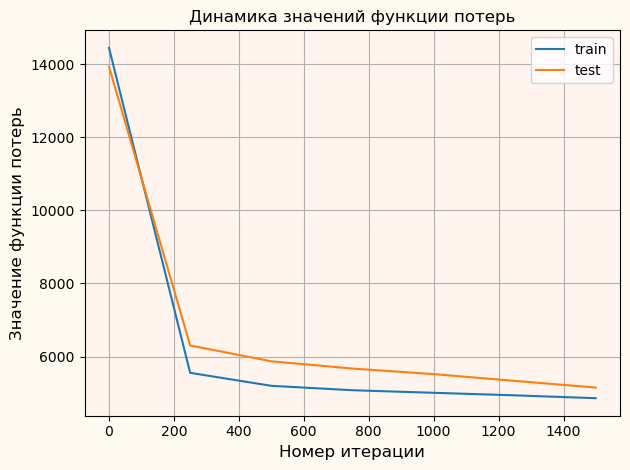

RMSE_test = 12459.099609375, RMSE_train = 13144.400390625, RMSE_MIN_TEST = 12459.099609375, epoch = 0
RMSE_test = 6354.89990234375, RMSE_train = 5508.81005859375, RMSE_MIN_TEST = 6354.89990234375, epoch = 250
RMSE_test = 5814.02001953125, RMSE_train = 5177.27001953125, RMSE_MIN_TEST = 5814.02001953125, epoch = 500
RMSE_test = 5575.25, RMSE_train = 5043.02001953125, RMSE_MIN_TEST = 5575.25, epoch = 750
RMSE_test = 5400.35009765625, RMSE_train = 4963.169921875, RMSE_MIN_TEST = 5400.35009765625, epoch = 1000
RMSE_test = 5251.2900390625, RMSE_train = 4902.31005859375, RMSE_MIN_TEST = 5244.169921875, epoch = 1250
RMSE_test = 5092.56982421875, RMSE_train = 4843.35009765625, RMSE_MIN_TEST = 5088.75, epoch = 1499
BUTCH_LENGTH = 50, RMSE_MIN_TEST = 5088.75


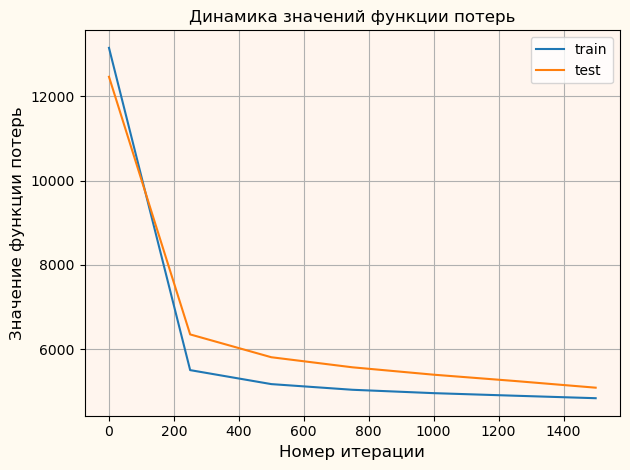

RMSE_test = 15602.3798828125, RMSE_train = 15938.5400390625, RMSE_MIN_TEST = 15602.3798828125, epoch = 0
RMSE_test = 6052.56005859375, RMSE_train = 5396.31005859375, RMSE_MIN_TEST = 6052.56005859375, epoch = 250
RMSE_test = 5619.7900390625, RMSE_train = 5086.22998046875, RMSE_MIN_TEST = 5619.7900390625, epoch = 500
RMSE_test = 5464.10986328125, RMSE_train = 4992.18994140625, RMSE_MIN_TEST = 5463.919921875, epoch = 750
RMSE_test = 5309.60009765625, RMSE_train = 4918.25, RMSE_MIN_TEST = 5308.91015625, epoch = 1000
RMSE_test = 5157.18994140625, RMSE_train = 4856.68017578125, RMSE_MIN_TEST = 5156.009765625, epoch = 1250
RMSE_test = 4976.52978515625, RMSE_train = 4778.35986328125, RMSE_MIN_TEST = 4976.52978515625, epoch = 1499
BUTCH_LENGTH = 60, RMSE_MIN_TEST = 4976.52978515625


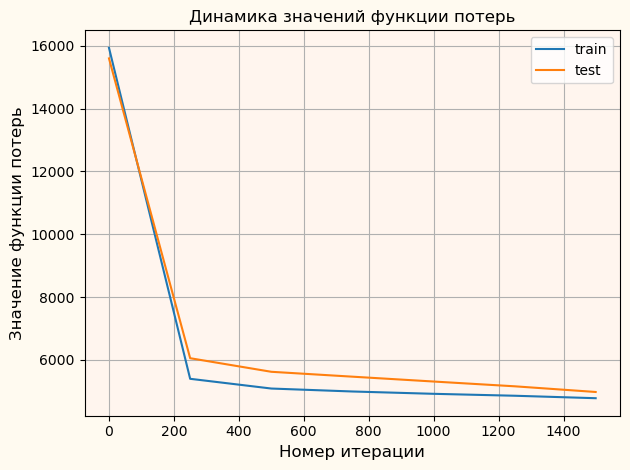

RMSE_test = 13199.2802734375, RMSE_train = 13794.98046875, RMSE_MIN_TEST = 13199.2802734375, epoch = 0
RMSE_test = 5887.60009765625, RMSE_train = 5253.27978515625, RMSE_MIN_TEST = 5880.06005859375, epoch = 250
RMSE_test = 5605.8701171875, RMSE_train = 5047.6298828125, RMSE_MIN_TEST = 5586.83984375, epoch = 500
RMSE_test = 5452.93994140625, RMSE_train = 4980.1201171875, RMSE_MIN_TEST = 5427.39013671875, epoch = 750
RMSE_test = 5329.4599609375, RMSE_train = 4939.2001953125, RMSE_MIN_TEST = 5325.39013671875, epoch = 1000
RMSE_test = 5240.509765625, RMSE_train = 4907.5, RMSE_MIN_TEST = 5238.72998046875, epoch = 1250
RMSE_test = 5148.10009765625, RMSE_train = 4880.72998046875, RMSE_MIN_TEST = 5146.27001953125, epoch = 1499
BUTCH_LENGTH = 70, RMSE_MIN_TEST = 5146.27001953125


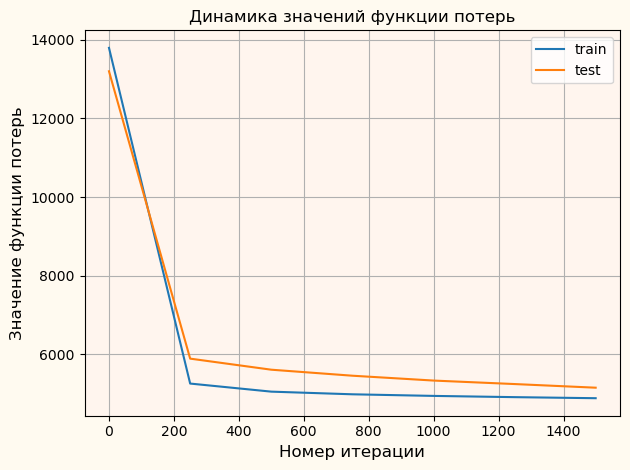

RMSE_test = 14191.740234375, RMSE_train = 14699.259765625, RMSE_MIN_TEST = 14191.740234375, epoch = 0
RMSE_test = 6538.10986328125, RMSE_train = 5887.93994140625, RMSE_MIN_TEST = 6538.10986328125, epoch = 250
RMSE_test = 5877.39013671875, RMSE_train = 5226.66015625, RMSE_MIN_TEST = 5877.39013671875, epoch = 500
RMSE_test = 5658.89990234375, RMSE_train = 5084.1201171875, RMSE_MIN_TEST = 5654.18017578125, epoch = 750
RMSE_test = 5479.2900390625, RMSE_train = 4994.97021484375, RMSE_MIN_TEST = 5462.169921875, epoch = 1000
RMSE_test = 5229.7998046875, RMSE_train = 4888.7099609375, RMSE_MIN_TEST = 5229.7998046875, epoch = 1250
RMSE_test = 4977.3701171875, RMSE_train = 4797.97021484375, RMSE_MIN_TEST = 4977.3701171875, epoch = 1499
BUTCH_LENGTH = 80, RMSE_MIN_TEST = 4977.3701171875


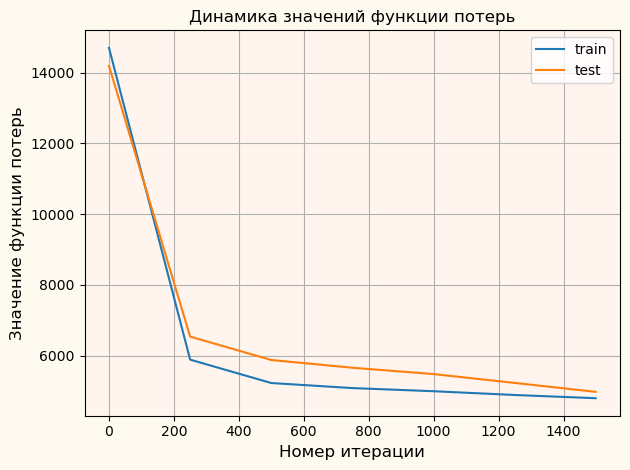

RMSE_test = 13588.8203125, RMSE_train = 14154.25, RMSE_MIN_TEST = 13588.8203125, epoch = 0
RMSE_test = 6057.580078125, RMSE_train = 5306.39990234375, RMSE_MIN_TEST = 6057.580078125, epoch = 250
RMSE_test = 5685.64013671875, RMSE_train = 5100.7900390625, RMSE_MIN_TEST = 5685.64013671875, epoch = 500
RMSE_test = 5468.93017578125, RMSE_train = 5000.89013671875, RMSE_MIN_TEST = 5468.93017578125, epoch = 750
RMSE_test = 5302.6201171875, RMSE_train = 4930.39990234375, RMSE_MIN_TEST = 5302.6201171875, epoch = 1000
RMSE_test = 5166.740234375, RMSE_train = 4874.52001953125, RMSE_MIN_TEST = 5165.3701171875, epoch = 1250
RMSE_test = 5038.85009765625, RMSE_train = 4809.4501953125, RMSE_MIN_TEST = 5038.85009765625, epoch = 1499
BUTCH_LENGTH = 90, RMSE_MIN_TEST = 5038.85009765625


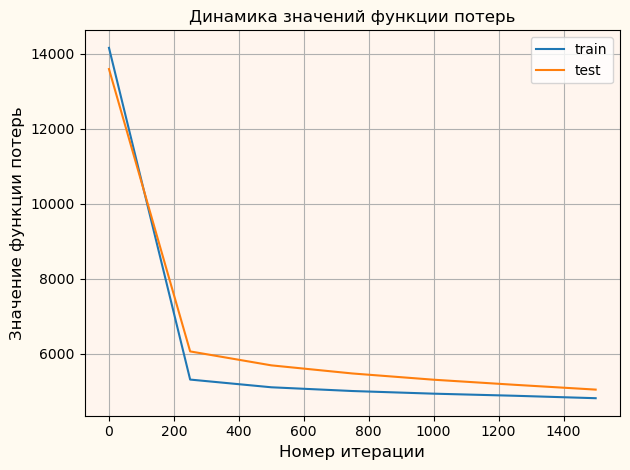

RMSE_test = 16389.130859375, RMSE_train = 16577.009765625, RMSE_MIN_TEST = 16389.130859375, epoch = 0
RMSE_test = 6334.330078125, RMSE_train = 5502.39013671875, RMSE_MIN_TEST = 6334.330078125, epoch = 250
RMSE_test = 5712.56982421875, RMSE_train = 5120.77978515625, RMSE_MIN_TEST = 5712.14013671875, epoch = 500
RMSE_test = 5493.6298828125, RMSE_train = 5000.259765625, RMSE_MIN_TEST = 5493.6298828125, epoch = 750
RMSE_test = 5326.83984375, RMSE_train = 4926.0, RMSE_MIN_TEST = 5326.83984375, epoch = 1000
RMSE_test = 5200.52001953125, RMSE_train = 4878.56005859375, RMSE_MIN_TEST = 5200.31982421875, epoch = 1250
RMSE_test = 5091.08984375, RMSE_train = 4841.52001953125, RMSE_MIN_TEST = 5091.08984375, epoch = 1499
BUTCH_LENGTH = 100, RMSE_MIN_TEST = 5091.08984375


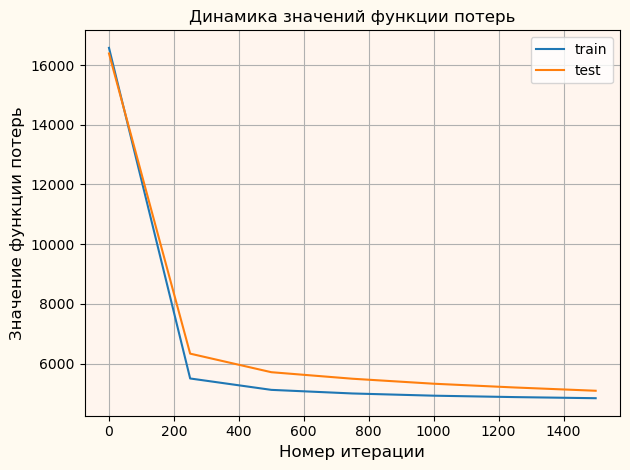

RMSE_test = 15906.849609375, RMSE_train = 16168.580078125, RMSE_MIN_TEST = 15906.849609375, epoch = 0
RMSE_test = 6484.81005859375, RMSE_train = 5698.919921875, RMSE_MIN_TEST = 6484.81005859375, epoch = 250
RMSE_test = 5857.8798828125, RMSE_train = 5183.2001953125, RMSE_MIN_TEST = 5856.64990234375, epoch = 500
RMSE_test = 5626.4599609375, RMSE_train = 5011.0, RMSE_MIN_TEST = 5625.830078125, epoch = 750
RMSE_test = 5445.18994140625, RMSE_train = 4901.60009765625, RMSE_MIN_TEST = 5444.9599609375, epoch = 1000
RMSE_test = 5265.97998046875, RMSE_train = 4814.1201171875, RMSE_MIN_TEST = 5265.97998046875, epoch = 1250
RMSE_test = 5088.2900390625, RMSE_train = 4722.990234375, RMSE_MIN_TEST = 5088.2900390625, epoch = 1499
BUTCH_LENGTH = 110, RMSE_MIN_TEST = 5088.2900390625


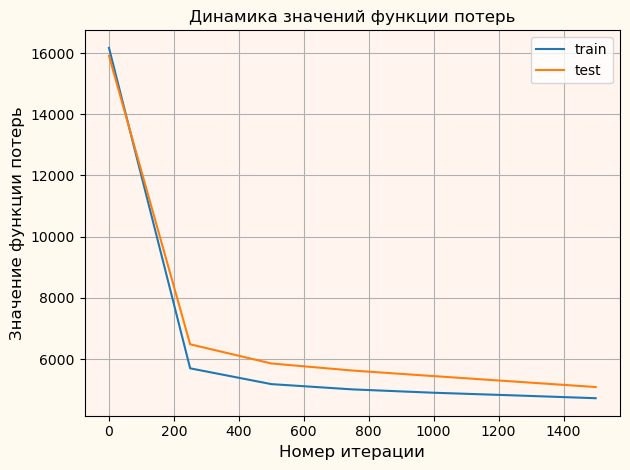

RMSE_test = 13360.349609375, RMSE_train = 13908.169921875, RMSE_MIN_TEST = 13360.349609375, epoch = 0
RMSE_test = 5842.8701171875, RMSE_train = 5200.8701171875, RMSE_MIN_TEST = 5842.4599609375, epoch = 250
RMSE_test = 5522.7001953125, RMSE_train = 5032.2001953125, RMSE_MIN_TEST = 5522.7001953125, epoch = 500
RMSE_test = 5317.93994140625, RMSE_train = 4946.81005859375, RMSE_MIN_TEST = 5317.0, epoch = 750
RMSE_test = 5182.27001953125, RMSE_train = 4884.91015625, RMSE_MIN_TEST = 5182.27001953125, epoch = 1000
RMSE_test = 5092.60009765625, RMSE_train = 4848.5498046875, RMSE_MIN_TEST = 5077.81005859375, epoch = 1250
RMSE_test = 5015.83984375, RMSE_train = 4816.68017578125, RMSE_MIN_TEST = 5015.740234375, epoch = 1499
BUTCH_LENGTH = 120, RMSE_MIN_TEST = 5015.740234375


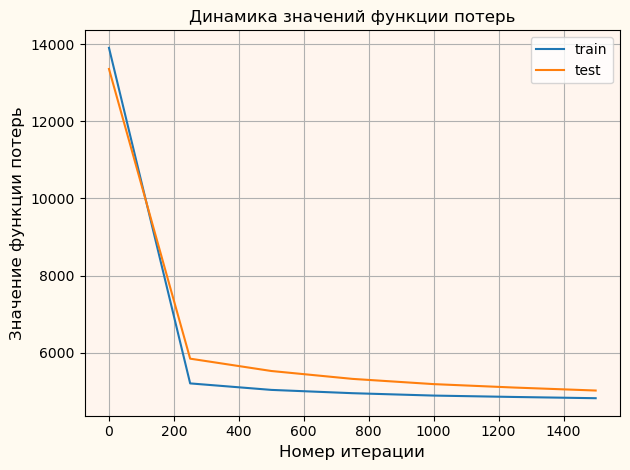

RMSE_test = 15954.0400390625, RMSE_train = 16299.1396484375, RMSE_MIN_TEST = 15954.0400390625, epoch = 0
RMSE_test = 6249.18017578125, RMSE_train = 5494.83984375, RMSE_MIN_TEST = 6249.18017578125, epoch = 250
RMSE_test = 5804.0, RMSE_train = 5168.81005859375, RMSE_MIN_TEST = 5804.0, epoch = 500
RMSE_test = 5545.10009765625, RMSE_train = 5037.4501953125, RMSE_MIN_TEST = 5545.10009765625, epoch = 750
RMSE_test = 5397.22998046875, RMSE_train = 4959.1201171875, RMSE_MIN_TEST = 5397.22998046875, epoch = 1000
RMSE_test = 5274.31005859375, RMSE_train = 4918.9599609375, RMSE_MIN_TEST = 5274.31005859375, epoch = 1250
RMSE_test = 5193.56982421875, RMSE_train = 4884.7099609375, RMSE_MIN_TEST = 5193.06005859375, epoch = 1499
BUTCH_LENGTH = 130, RMSE_MIN_TEST = 5193.06005859375


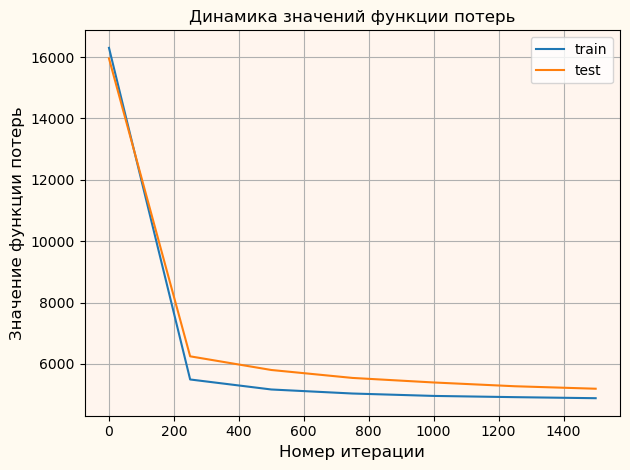

RMSE_test = 13720.9404296875, RMSE_train = 14266.2900390625, RMSE_MIN_TEST = 13720.9404296875, epoch = 0
RMSE_test = 6291.10986328125, RMSE_train = 5450.22021484375, RMSE_MIN_TEST = 6291.10986328125, epoch = 250
RMSE_test = 5856.64990234375, RMSE_train = 5188.85986328125, RMSE_MIN_TEST = 5846.3798828125, epoch = 500
RMSE_test = 5586.419921875, RMSE_train = 5052.68994140625, RMSE_MIN_TEST = 5578.4599609375, epoch = 750
RMSE_test = 5450.56005859375, RMSE_train = 4980.77001953125, RMSE_MIN_TEST = 5430.97021484375, epoch = 1000
RMSE_test = 5281.169921875, RMSE_train = 4934.93017578125, RMSE_MIN_TEST = 5281.169921875, epoch = 1250
RMSE_test = 5261.259765625, RMSE_train = 4917.83984375, RMSE_MIN_TEST = 5212.56982421875, epoch = 1499
BUTCH_LENGTH = 140, RMSE_MIN_TEST = 5212.56982421875


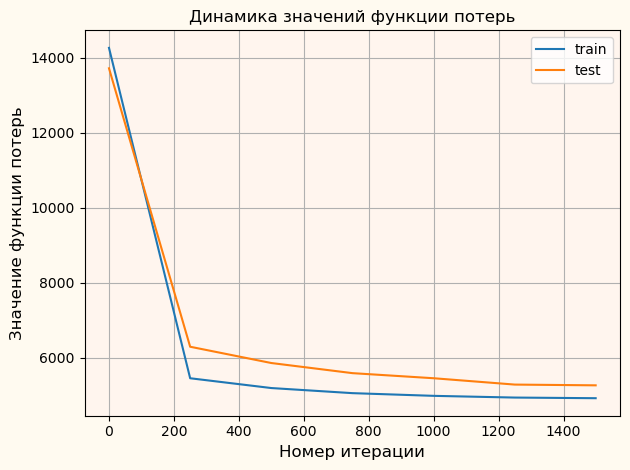

RMSE_test = 14922.9599609375, RMSE_train = 15212.7802734375, RMSE_MIN_TEST = 14922.9599609375, epoch = 0
RMSE_test = 6776.18017578125, RMSE_train = 5823.259765625, RMSE_MIN_TEST = 6776.18017578125, epoch = 250
RMSE_test = 6015.02001953125, RMSE_train = 5306.06005859375, RMSE_MIN_TEST = 6015.02001953125, epoch = 500
RMSE_test = 5751.6201171875, RMSE_train = 5122.31982421875, RMSE_MIN_TEST = 5747.2998046875, epoch = 750
RMSE_test = 5582.93994140625, RMSE_train = 5039.27001953125, RMSE_MIN_TEST = 5571.22021484375, epoch = 1000
RMSE_test = 5419.06005859375, RMSE_train = 4986.080078125, RMSE_MIN_TEST = 5419.06005859375, epoch = 1250
RMSE_test = 5279.93017578125, RMSE_train = 4915.669921875, RMSE_MIN_TEST = 5279.93017578125, epoch = 1499
BUTCH_LENGTH = 150, RMSE_MIN_TEST = 5279.93017578125


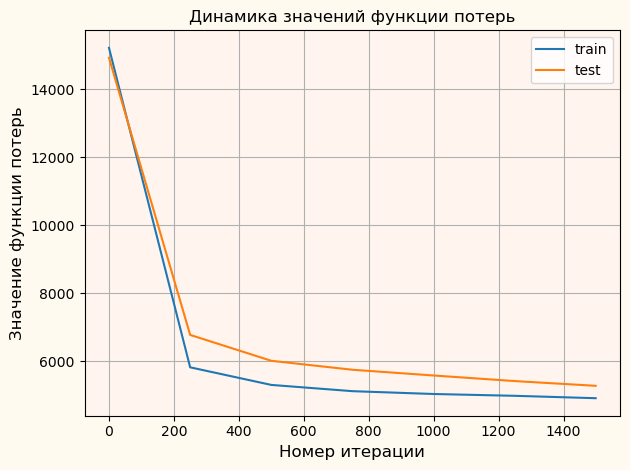

RMSE_test = 10224.169921875, RMSE_train = 10918.1201171875, RMSE_MIN_TEST = 10224.169921875, epoch = 0
RMSE_test = 6029.64013671875, RMSE_train = 5358.64013671875, RMSE_MIN_TEST = 6029.64013671875, epoch = 250
RMSE_test = 5619.31005859375, RMSE_train = 5130.43994140625, RMSE_MIN_TEST = 5613.18994140625, epoch = 500
RMSE_test = 5419.58984375, RMSE_train = 4981.18017578125, RMSE_MIN_TEST = 5400.89990234375, epoch = 750
RMSE_test = 5247.47998046875, RMSE_train = 4903.31982421875, RMSE_MIN_TEST = 5244.2001953125, epoch = 1000
RMSE_test = 5047.990234375, RMSE_train = 4809.10986328125, RMSE_MIN_TEST = 5042.25, epoch = 1250
RMSE_test = 4862.7099609375, RMSE_train = 4725.7099609375, RMSE_MIN_TEST = 4833.490234375, epoch = 1499
BUTCH_LENGTH = 160, RMSE_MIN_TEST = 4833.490234375


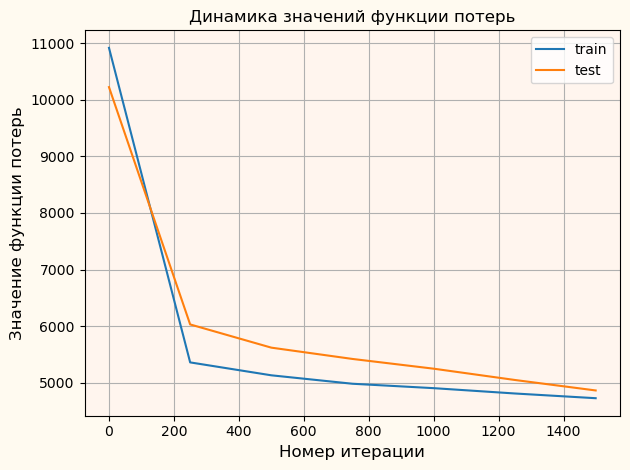

RMSE_test = 15294.08984375, RMSE_train = 15477.8603515625, RMSE_MIN_TEST = 15294.08984375, epoch = 0
RMSE_test = 6119.39990234375, RMSE_train = 5397.25, RMSE_MIN_TEST = 6092.3798828125, epoch = 250
RMSE_test = 5817.93017578125, RMSE_train = 5181.0, RMSE_MIN_TEST = 5743.0400390625, epoch = 500
RMSE_test = 5728.3701171875, RMSE_train = 5105.85009765625, RMSE_MIN_TEST = 5602.85009765625, epoch = 750
RMSE_test = 5465.64013671875, RMSE_train = 5022.3798828125, RMSE_MIN_TEST = 5443.2001953125, epoch = 1000
RMSE_test = 5439.0498046875, RMSE_train = 4989.9501953125, RMSE_MIN_TEST = 5403.1201171875, epoch = 1250
RMSE_test = 5357.72998046875, RMSE_train = 5004.06982421875, RMSE_MIN_TEST = 5355.68994140625, epoch = 1499
BUTCH_LENGTH = 170, RMSE_MIN_TEST = 5355.68994140625


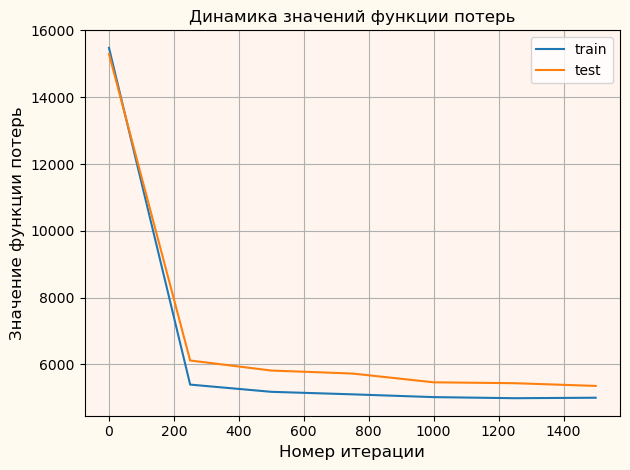

CPU times: user 1min 6s, sys: 53.3 s, total: 2min
Wall time: 1min 11s


In [51]:
%%time

#перебираем размеры батчей:
for j in range(ButchFloor, ButchCeil, ButchStepCeil):

    nn.init.uniform_(net.fc1.weight, a=1, b=2)
    nn.init.uniform_(net.fc1.bias, a=1, b=2)
    nn.init.kaiming_uniform_(net.fc2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.normal_(net.fc2.bias, mean=0, std=1)
    nn.init.kaiming_normal_(net.fc3.weight)
    nn.init.normal_(net.fc3.bias, mean=0, std=1)

    xx = []
    yy_train = []
    yy_test = []

    batch_size = j

    num_epochs = 1500

    num_batches = ceil(len(X_train) / batch_size)


    RMSE_MIN_TEST = None
    best_net = None


    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test).flatten()
        RMSE = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

        if epoch == 0:
            RMSE_MIN_TEST = RMSE
            best_net = copy.deepcopy(net)
        else:
            if RMSE_MIN_TEST > RMSE:
                RMSE_MIN_TEST = RMSE
                best_net = copy.deepcopy(net)   

        #ARRAY.append([net.fc1.weight, net.fc1.bias, net.fc2.weight, net.fc2.bias, net.fc3.weight, net.fc3.bias])

        if epoch % 250 == 0 or epoch == num_epochs-1:
            net.eval()

            test_preds = net.forward(X_test).flatten()
            RMSE_test = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

            train_preds = net.forward(X_train).flatten()
            RMSE_train = round(np.sqrt(mse(train_preds.detach().numpy(), y_train.detach().numpy())), 2)

            xx.append(epoch)
            yy_train.append(RMSE_train)
            yy_test.append(RMSE_test)

            print(f'RMSE_test = {RMSE_test}, RMSE_train = {RMSE_train}, RMSE_MIN_TEST = {RMSE_MIN_TEST}, epoch = {epoch}')
            #print(f'epoch = {epoch}, RMSE = {RMSE}, RMSE_MIN_TEST = {RMSE_MIN_TEST}')

    print(f'BUTCH_LENGTH = {j}, RMSE_MIN_TEST = {RMSE_MIN_TEST}')
    fig, ax = plt.subplots()

    ax.plot(xx, yy_train, label='train')
    ax.plot(xx, yy_test, label='test')

    ax.set_xlabel('Номер итерации', fontsize=12)
    ax.set_ylabel('Значение функции потерь', fontsize=12)

    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')

    ax.set_title('Динамика значений функции потерь')

    ax.grid(True)
    fig.tight_layout()

    ax.legend() 
    plt.show()

**Краткие выводы**: перебор размеров батчей не привёл к улучшению результатов: на каждом шаге значение метрикик RMSE не упало ниже 4426. Попробуем заняться выборочным отключением нейронов.

Инициализируем новый класс моделей с опцией добавлять число отключаемых нейронов `d_1, d_2` в первом и втором слое: 

In [52]:
class Net_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons, d_1, d_2):
        super(Net_1, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        #self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=d_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        #self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=d_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Linear(1, 1)

        nn.init.uniform_(self.fc1.weight, a=1, b=2)
        nn.init.uniform_(self.fc1.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=1)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0, std=1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.act1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return x

Зафиксируем параметры:

In [53]:
#Верхняя граница для доли в десятых от числа отключаемых нейронов после первого слоя:
DropCeil_1 = 10
#Шаг в переборе от числа отключаемых нейронов после первого слоя:
DropStep_1 = 1

#Верхняя граница для доли в десятых от числа отключаемых нейронов после второго слоя:
DropCeil_2 = 10
#Шаг в переборе от числа отключаемых нейронов после второго слоя:
DropStep_2 = 1


#Размер батча:
batch_size = 40

#Число эпох:
num_epochs = 20000

#Число батчей:
num_batches = ceil(len(X_train)/batch_size)

In [54]:
best_net_global = None
RMSE_MIN_TEST_GLOBAL = None

RMSE_test = 13784.919921875, RMSE_train = 14309.919921875, RMSE_MIN_TEST = 13784.919921875, epoch = 0
RMSE_test = 6257.85009765625, RMSE_train = 5442.68994140625, RMSE_MIN_TEST = 6257.85009765625, epoch = 1000
RMSE_test = 5681.080078125, RMSE_train = 5095.919921875, RMSE_MIN_TEST = 5681.080078125, epoch = 2000
RMSE_test = 5527.14990234375, RMSE_train = 5009.5400390625, RMSE_MIN_TEST = 5524.81005859375, epoch = 3000
RMSE_test = 5377.080078125, RMSE_train = 4946.8701171875, RMSE_MIN_TEST = 5376.41015625, epoch = 4000
RMSE_test = 5211.77001953125, RMSE_train = 4869.89990234375, RMSE_MIN_TEST = 5211.52978515625, epoch = 5000
RMSE_test = 5034.33984375, RMSE_train = 4787.2001953125, RMSE_MIN_TEST = 5034.33984375, epoch = 6000
RMSE_test = 4856.83984375, RMSE_train = 4686.68994140625, RMSE_MIN_TEST = 4856.83984375, epoch = 7000
RMSE_test = 4600.3701171875, RMSE_train = 4538.33984375, RMSE_MIN_TEST = 4600.3701171875, epoch = 8000
RMSE_test = 4381.33984375, RMSE_train = 4387.490234375, RMSE_MIN_

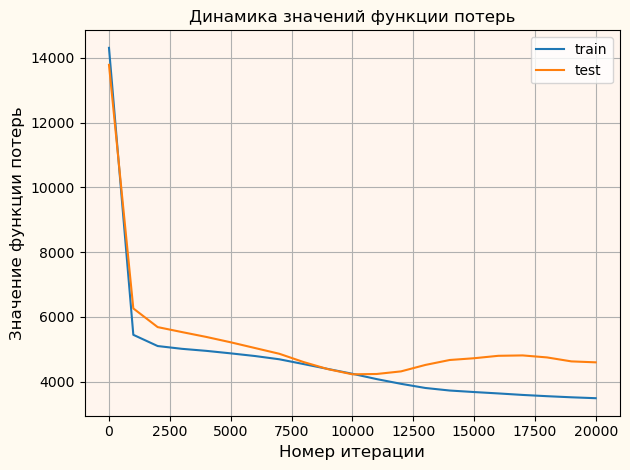

RMSE_test = 13783.009765625, RMSE_train = 14308.0302734375, RMSE_MIN_TEST = 13783.009765625, epoch = 0
RMSE_test = 6329.509765625, RMSE_train = 5482.9501953125, RMSE_MIN_TEST = 6329.509765625, epoch = 1000
RMSE_test = 5668.6201171875, RMSE_train = 5091.22021484375, RMSE_MIN_TEST = 5668.33984375, epoch = 2000
RMSE_test = 5463.31982421875, RMSE_train = 4982.27001953125, RMSE_MIN_TEST = 5463.169921875, epoch = 3000
RMSE_test = 5201.93017578125, RMSE_train = 4872.56982421875, RMSE_MIN_TEST = 5201.93017578125, epoch = 4000
RMSE_test = 4836.83984375, RMSE_train = 4721.93994140625, RMSE_MIN_TEST = 4836.81005859375, epoch = 5000
RMSE_test = 4525.9501953125, RMSE_train = 4565.41015625, RMSE_MIN_TEST = 4524.64990234375, epoch = 6000
RMSE_test = 4315.60986328125, RMSE_train = 4420.9501953125, RMSE_MIN_TEST = 4314.740234375, epoch = 7000
RMSE_test = 4155.35986328125, RMSE_train = 4294.93017578125, RMSE_MIN_TEST = 4155.35986328125, epoch = 8000
RMSE_test = 3975.929931640625, RMSE_train = 4139.02978

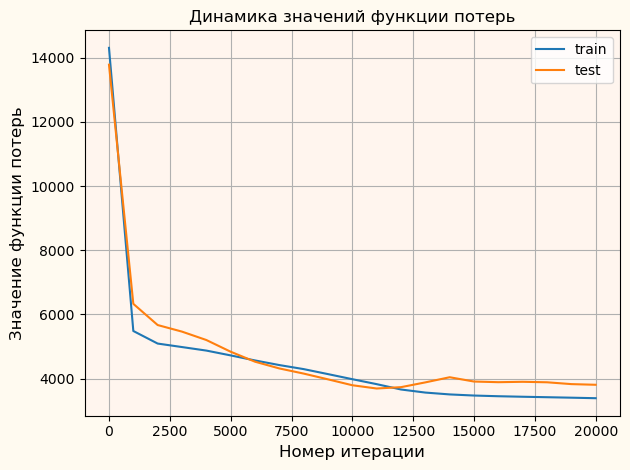

RMSE_test = 13784.01953125, RMSE_train = 14309.01953125, RMSE_MIN_TEST = 13784.01953125, epoch = 0
RMSE_test = 6368.97998046875, RMSE_train = 5525.41015625, RMSE_MIN_TEST = 6368.97998046875, epoch = 1000
RMSE_test = 5674.5, RMSE_train = 5082.740234375, RMSE_MIN_TEST = 5674.31005859375, epoch = 2000
RMSE_test = 5422.27978515625, RMSE_train = 4952.490234375, RMSE_MIN_TEST = 5421.259765625, epoch = 3000
RMSE_test = 5151.06982421875, RMSE_train = 4837.81982421875, RMSE_MIN_TEST = 5150.18017578125, epoch = 4000
RMSE_test = 4904.0, RMSE_train = 4725.85986328125, RMSE_MIN_TEST = 4902.77001953125, epoch = 5000
RMSE_test = 4699.6298828125, RMSE_train = 4620.669921875, RMSE_MIN_TEST = 4698.8798828125, epoch = 6000
RMSE_test = 4544.5498046875, RMSE_train = 4517.2998046875, RMSE_MIN_TEST = 4544.5498046875, epoch = 7000
RMSE_test = 4405.2900390625, RMSE_train = 4419.0400390625, RMSE_MIN_TEST = 4402.2998046875, epoch = 8000
RMSE_test = 4278.9501953125, RMSE_train = 4321.97021484375, RMSE_MIN_TEST = 

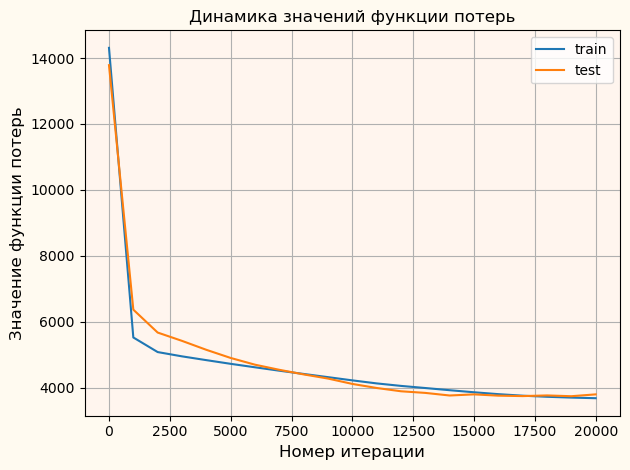

RMSE_test = 13784.240234375, RMSE_train = 14309.3896484375, RMSE_MIN_TEST = 13784.240234375, epoch = 0
RMSE_test = 6335.77978515625, RMSE_train = 5497.990234375, RMSE_MIN_TEST = 6335.77978515625, epoch = 1000
RMSE_test = 5702.81982421875, RMSE_train = 5109.1298828125, RMSE_MIN_TEST = 5700.81005859375, epoch = 2000
RMSE_test = 5541.35009765625, RMSE_train = 5020.0498046875, RMSE_MIN_TEST = 5541.35009765625, epoch = 3000
RMSE_test = 5397.5400390625, RMSE_train = 4958.509765625, RMSE_MIN_TEST = 5397.5400390625, epoch = 4000
RMSE_test = 5272.5498046875, RMSE_train = 4905.8701171875, RMSE_MIN_TEST = 5272.16015625, epoch = 5000
RMSE_test = 5139.490234375, RMSE_train = 4853.35986328125, RMSE_MIN_TEST = 5138.6298828125, epoch = 6000
RMSE_test = 5003.06005859375, RMSE_train = 4798.56005859375, RMSE_MIN_TEST = 5003.06005859375, epoch = 7000
RMSE_test = 4805.580078125, RMSE_train = 4720.0, RMSE_MIN_TEST = 4805.580078125, epoch = 8000
RMSE_test = 4556.89013671875, RMSE_train = 4618.2099609375, RMS

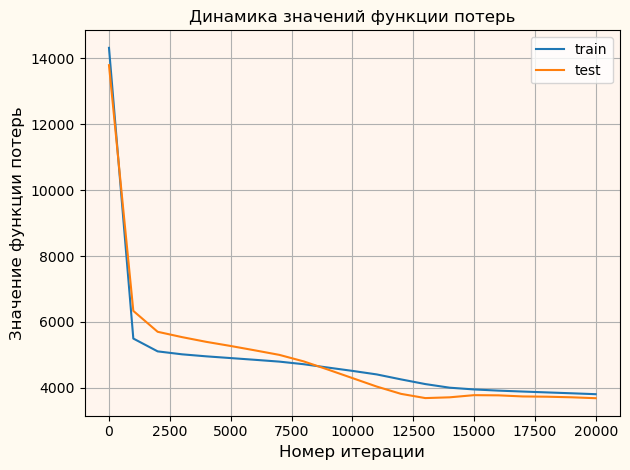

RMSE_test = 13784.4296875, RMSE_train = 14309.4697265625, RMSE_MIN_TEST = 13784.4296875, epoch = 0
RMSE_test = 6326.5498046875, RMSE_train = 5477.509765625, RMSE_MIN_TEST = 6326.5498046875, epoch = 1000
RMSE_test = 5650.39013671875, RMSE_train = 5076.7998046875, RMSE_MIN_TEST = 5646.56982421875, epoch = 2000
RMSE_test = 5379.81982421875, RMSE_train = 4926.91015625, RMSE_MIN_TEST = 5378.75, epoch = 3000
RMSE_test = 5089.60986328125, RMSE_train = 4799.7099609375, RMSE_MIN_TEST = 5089.60986328125, epoch = 4000
RMSE_test = 4859.2001953125, RMSE_train = 4691.81005859375, RMSE_MIN_TEST = 4859.2001953125, epoch = 5000
RMSE_test = 4708.2998046875, RMSE_train = 4587.740234375, RMSE_MIN_TEST = 4708.14013671875, epoch = 6000
RMSE_test = 4589.25, RMSE_train = 4484.740234375, RMSE_MIN_TEST = 4589.25, epoch = 7000
RMSE_test = 4500.81982421875, RMSE_train = 4377.10986328125, RMSE_MIN_TEST = 4497.25, epoch = 8000
RMSE_test = 4427.64013671875, RMSE_train = 4249.080078125, RMSE_MIN_TEST = 4423.120117187

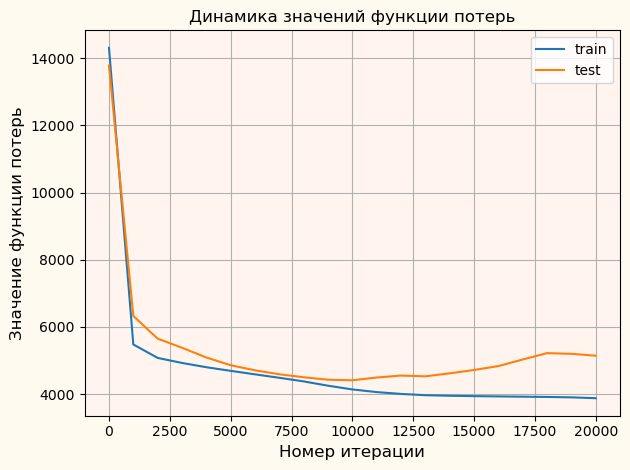

RMSE_test = 13789.58984375, RMSE_train = 14314.1298828125, RMSE_MIN_TEST = 13789.58984375, epoch = 0
RMSE_test = 6448.580078125, RMSE_train = 5579.02978515625, RMSE_MIN_TEST = 6448.580078125, epoch = 1000
RMSE_test = 5710.7998046875, RMSE_train = 5121.7998046875, RMSE_MIN_TEST = 5710.330078125, epoch = 2000
RMSE_test = 5448.72021484375, RMSE_train = 4968.9599609375, RMSE_MIN_TEST = 5448.72021484375, epoch = 3000
RMSE_test = 5179.56005859375, RMSE_train = 4842.5400390625, RMSE_MIN_TEST = 5179.56005859375, epoch = 4000
RMSE_test = 4888.52001953125, RMSE_train = 4719.509765625, RMSE_MIN_TEST = 4888.52001953125, epoch = 5000
RMSE_test = 4660.330078125, RMSE_train = 4602.10986328125, RMSE_MIN_TEST = 4659.740234375, epoch = 6000
RMSE_test = 4518.4599609375, RMSE_train = 4479.64990234375, RMSE_MIN_TEST = 4516.27978515625, epoch = 7000
RMSE_test = 4374.990234375, RMSE_train = 4345.1201171875, RMSE_MIN_TEST = 4374.990234375, epoch = 8000
RMSE_test = 4182.43994140625, RMSE_train = 4174.060058593

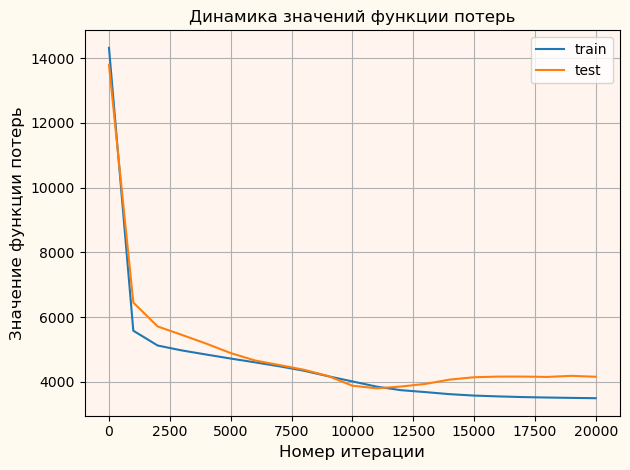

RMSE_test = 13781.9404296875, RMSE_train = 14307.080078125, RMSE_MIN_TEST = 13781.9404296875, epoch = 0
RMSE_test = 6354.35009765625, RMSE_train = 5501.7001953125, RMSE_MIN_TEST = 6354.35009765625, epoch = 1000
RMSE_test = 5722.830078125, RMSE_train = 5112.41015625, RMSE_MIN_TEST = 5722.830078125, epoch = 2000
RMSE_test = 5563.990234375, RMSE_train = 5027.72021484375, RMSE_MIN_TEST = 5563.35986328125, epoch = 3000
RMSE_test = 5416.259765625, RMSE_train = 4965.8701171875, RMSE_MIN_TEST = 5416.259765625, epoch = 4000
RMSE_test = 5267.6201171875, RMSE_train = 4906.68017578125, RMSE_MIN_TEST = 5266.740234375, epoch = 5000
RMSE_test = 5118.2998046875, RMSE_train = 4847.4501953125, RMSE_MIN_TEST = 5118.22021484375, epoch = 6000
RMSE_test = 4972.0, RMSE_train = 4787.43994140625, RMSE_MIN_TEST = 4972.0, epoch = 7000
RMSE_test = 4770.08984375, RMSE_train = 4712.35009765625, RMSE_MIN_TEST = 4769.919921875, epoch = 8000
RMSE_test = 4577.58984375, RMSE_train = 4637.509765625, RMSE_MIN_TEST = 4577.

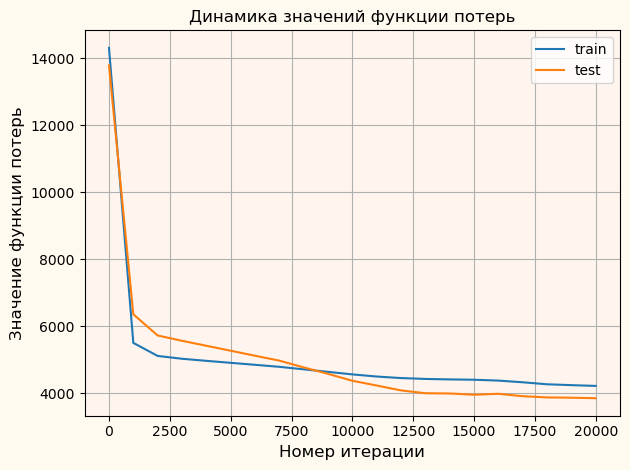

RMSE_test = 13786.76953125, RMSE_train = 14311.5703125, RMSE_MIN_TEST = 13786.76953125, epoch = 0
RMSE_test = 6426.72021484375, RMSE_train = 5558.14013671875, RMSE_MIN_TEST = 6426.72021484375, epoch = 1000
RMSE_test = 5741.169921875, RMSE_train = 5118.39013671875, RMSE_MIN_TEST = 5741.169921875, epoch = 2000
RMSE_test = 5568.43017578125, RMSE_train = 5033.18994140625, RMSE_MIN_TEST = 5567.81982421875, epoch = 3000
RMSE_test = 5427.31005859375, RMSE_train = 4966.5400390625, RMSE_MIN_TEST = 5427.31005859375, epoch = 4000
RMSE_test = 5266.27978515625, RMSE_train = 4901.5498046875, RMSE_MIN_TEST = 5266.27978515625, epoch = 5000
RMSE_test = 5125.6298828125, RMSE_train = 4840.85009765625, RMSE_MIN_TEST = 5125.6298828125, epoch = 6000
RMSE_test = 4975.14013671875, RMSE_train = 4773.9599609375, RMSE_MIN_TEST = 4975.14013671875, epoch = 7000
RMSE_test = 4778.10986328125, RMSE_train = 4686.16015625, RMSE_MIN_TEST = 4778.10986328125, epoch = 8000
RMSE_test = 4493.2998046875, RMSE_train = 4570.220

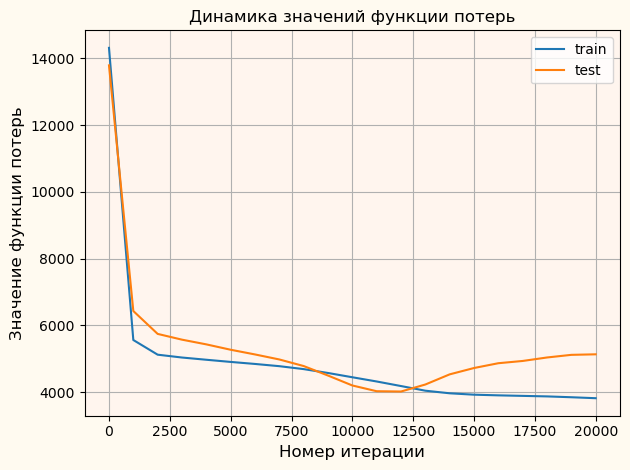

RMSE_test = 13778.33984375, RMSE_train = 14304.009765625, RMSE_MIN_TEST = 13778.33984375, epoch = 0
RMSE_test = 6398.72021484375, RMSE_train = 5529.47998046875, RMSE_MIN_TEST = 6398.72021484375, epoch = 1000
RMSE_test = 5727.490234375, RMSE_train = 5121.4599609375, RMSE_MIN_TEST = 5727.490234375, epoch = 2000
RMSE_test = 5558.39990234375, RMSE_train = 5024.97998046875, RMSE_MIN_TEST = 5557.5400390625, epoch = 3000
RMSE_test = 5398.35986328125, RMSE_train = 4958.8701171875, RMSE_MIN_TEST = 5397.35009765625, epoch = 4000
RMSE_test = 5260.490234375, RMSE_train = 4901.5400390625, RMSE_MIN_TEST = 5260.259765625, epoch = 5000
RMSE_test = 5122.9501953125, RMSE_train = 4847.27001953125, RMSE_MIN_TEST = 5122.83984375, epoch = 6000
RMSE_test = 4994.68994140625, RMSE_train = 4793.27001953125, RMSE_MIN_TEST = 4994.68994140625, epoch = 7000
RMSE_test = 4820.2900390625, RMSE_train = 4723.7001953125, RMSE_MIN_TEST = 4819.5498046875, epoch = 8000
RMSE_test = 4625.2001953125, RMSE_train = 4647.85986328

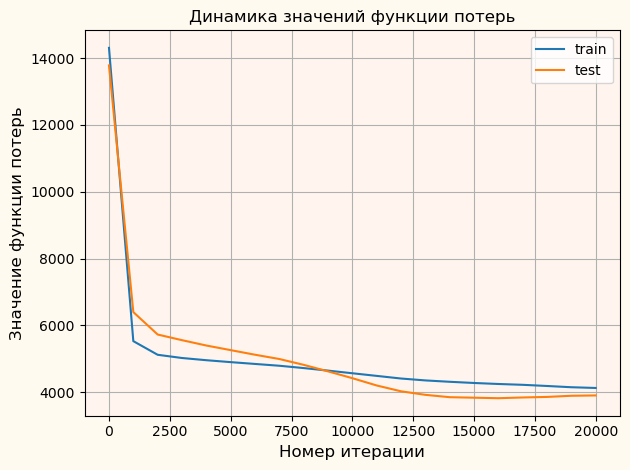

RMSE_test = 13783.4501953125, RMSE_train = 14308.48046875, RMSE_MIN_TEST = 13783.4501953125, epoch = 0
RMSE_test = 6360.64013671875, RMSE_train = 5505.06005859375, RMSE_MIN_TEST = 6360.64013671875, epoch = 1000
RMSE_test = 5713.2998046875, RMSE_train = 5121.97021484375, RMSE_MIN_TEST = 5710.47998046875, epoch = 2000
RMSE_test = 5537.75, RMSE_train = 5022.3798828125, RMSE_MIN_TEST = 5533.509765625, epoch = 3000
RMSE_test = 5386.830078125, RMSE_train = 4955.8701171875, RMSE_MIN_TEST = 5386.830078125, epoch = 4000
RMSE_test = 5269.77978515625, RMSE_train = 4907.77001953125, RMSE_MIN_TEST = 5269.169921875, epoch = 5000
RMSE_test = 5126.02978515625, RMSE_train = 4846.740234375, RMSE_MIN_TEST = 5126.02978515625, epoch = 6000
RMSE_test = 4980.240234375, RMSE_train = 4787.83984375, RMSE_MIN_TEST = 4980.240234375, epoch = 7000
RMSE_test = 4802.35009765625, RMSE_train = 4718.43994140625, RMSE_MIN_TEST = 4802.240234375, epoch = 8000
RMSE_test = 4597.990234375, RMSE_train = 4636.68017578125, RMSE_

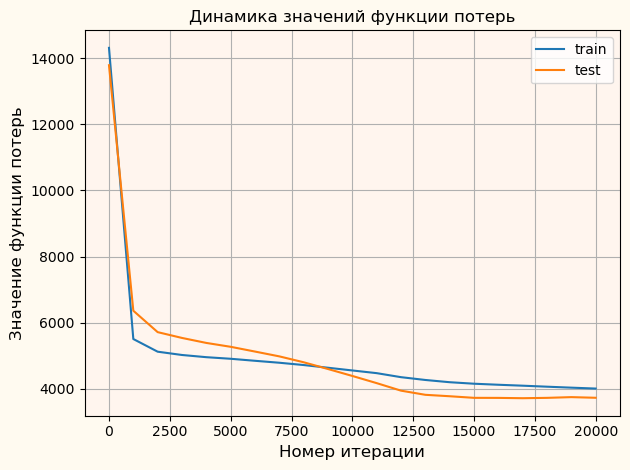

RMSE_test = 13779.3896484375, RMSE_train = 14304.599609375, RMSE_MIN_TEST = 13779.3896484375, epoch = 0
RMSE_test = 6304.7099609375, RMSE_train = 5469.02001953125, RMSE_MIN_TEST = 6304.7099609375, epoch = 1000
RMSE_test = 5696.0498046875, RMSE_train = 5095.759765625, RMSE_MIN_TEST = 5694.7099609375, epoch = 2000
RMSE_test = 5493.580078125, RMSE_train = 4994.33984375, RMSE_MIN_TEST = 5490.7998046875, epoch = 3000
RMSE_test = 5256.9599609375, RMSE_train = 4898.47998046875, RMSE_MIN_TEST = 5256.9599609375, epoch = 4000
RMSE_test = 4957.60009765625, RMSE_train = 4779.9501953125, RMSE_MIN_TEST = 4957.60009765625, epoch = 5000
RMSE_test = 4638.580078125, RMSE_train = 4646.009765625, RMSE_MIN_TEST = 4638.27001953125, epoch = 6000
RMSE_test = 4369.5, RMSE_train = 4507.43017578125, RMSE_MIN_TEST = 4369.5, epoch = 7000
RMSE_test = 4199.10986328125, RMSE_train = 4373.89990234375, RMSE_MIN_TEST = 4199.10986328125, epoch = 8000
RMSE_test = 4064.02001953125, RMSE_train = 4246.77001953125, RMSE_MIN_T

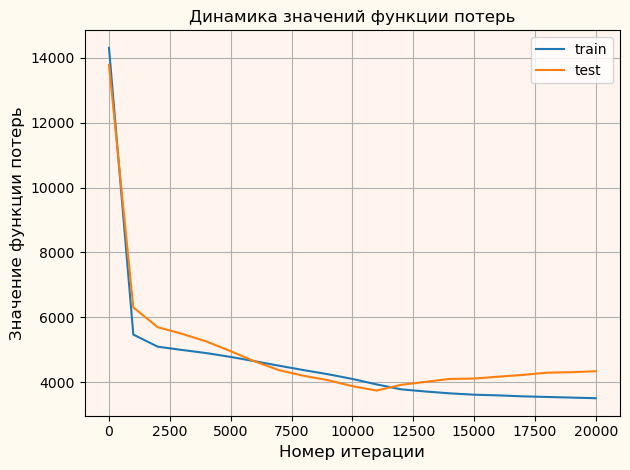

RMSE_test = 13783.1904296875, RMSE_train = 14308.4697265625, RMSE_MIN_TEST = 13783.1904296875, epoch = 0
RMSE_test = 6301.91015625, RMSE_train = 5462.8798828125, RMSE_MIN_TEST = 6301.91015625, epoch = 1000
RMSE_test = 5708.4501953125, RMSE_train = 5108.2001953125, RMSE_MIN_TEST = 5708.4501953125, epoch = 2000
RMSE_test = 5534.16015625, RMSE_train = 5013.58984375, RMSE_MIN_TEST = 5534.16015625, epoch = 3000
RMSE_test = 5364.08984375, RMSE_train = 4940.35986328125, RMSE_MIN_TEST = 5364.08984375, epoch = 4000
RMSE_test = 5193.97021484375, RMSE_train = 4876.31982421875, RMSE_MIN_TEST = 5193.919921875, epoch = 5000
RMSE_test = 5051.740234375, RMSE_train = 4817.39990234375, RMSE_MIN_TEST = 5051.740234375, epoch = 6000
RMSE_test = 4898.0498046875, RMSE_train = 4747.77978515625, RMSE_MIN_TEST = 4897.56982421875, epoch = 7000
RMSE_test = 4714.740234375, RMSE_train = 4663.9501953125, RMSE_MIN_TEST = 4714.740234375, epoch = 8000
RMSE_test = 4500.77978515625, RMSE_train = 4578.009765625, RMSE_MIN_

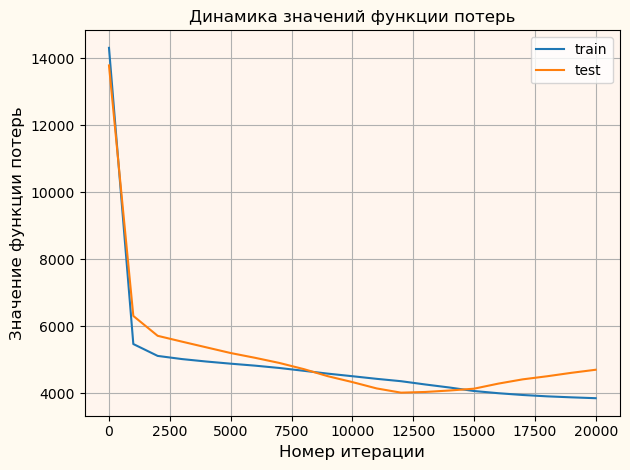

RMSE_test = 13784.51953125, RMSE_train = 14309.3896484375, RMSE_MIN_TEST = 13784.51953125, epoch = 0
RMSE_test = 6436.8798828125, RMSE_train = 5570.5, RMSE_MIN_TEST = 6436.8798828125, epoch = 1000
RMSE_test = 5721.5400390625, RMSE_train = 5117.52001953125, RMSE_MIN_TEST = 5721.43994140625, epoch = 2000
RMSE_test = 5529.990234375, RMSE_train = 5009.8798828125, RMSE_MIN_TEST = 5529.990234375, epoch = 3000
RMSE_test = 5337.6298828125, RMSE_train = 4919.60009765625, RMSE_MIN_TEST = 5337.6298828125, epoch = 4000
RMSE_test = 5108.830078125, RMSE_train = 4819.31982421875, RMSE_MIN_TEST = 5108.06005859375, epoch = 5000
RMSE_test = 4859.4501953125, RMSE_train = 4711.18017578125, RMSE_MIN_TEST = 4859.14990234375, epoch = 6000
RMSE_test = 4629.1201171875, RMSE_train = 4590.64990234375, RMSE_MIN_TEST = 4628.830078125, epoch = 7000
RMSE_test = 4438.3798828125, RMSE_train = 4460.7001953125, RMSE_MIN_TEST = 4436.97998046875, epoch = 8000
RMSE_test = 4279.43994140625, RMSE_train = 4318.52978515625, RM

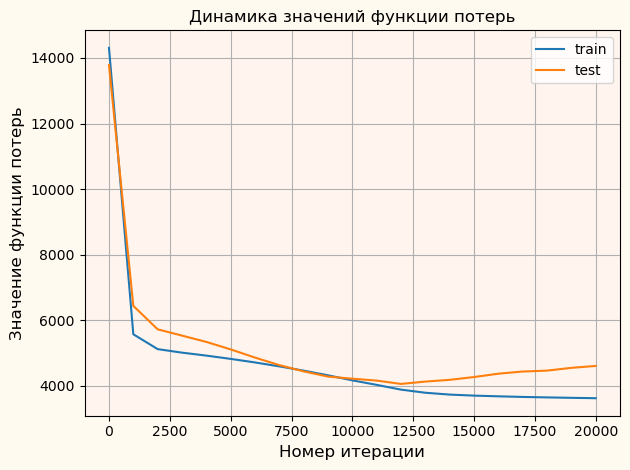

RMSE_test = 13782.6396484375, RMSE_train = 14307.8896484375, RMSE_MIN_TEST = 13782.6396484375, epoch = 0
RMSE_test = 6284.8701171875, RMSE_train = 5466.02001953125, RMSE_MIN_TEST = 6284.8701171875, epoch = 1000
RMSE_test = 5694.2001953125, RMSE_train = 5101.08984375, RMSE_MIN_TEST = 5694.2001953125, epoch = 2000
RMSE_test = 5522.39990234375, RMSE_train = 5011.06982421875, RMSE_MIN_TEST = 5521.68994140625, epoch = 3000
RMSE_test = 5385.7099609375, RMSE_train = 4952.5, RMSE_MIN_TEST = 5385.7099609375, epoch = 4000
RMSE_test = 5240.43017578125, RMSE_train = 4884.9599609375, RMSE_MIN_TEST = 5240.43017578125, epoch = 5000
RMSE_test = 5038.7099609375, RMSE_train = 4794.22021484375, RMSE_MIN_TEST = 5038.7099609375, epoch = 6000
RMSE_test = 4790.81005859375, RMSE_train = 4669.830078125, RMSE_MIN_TEST = 4790.81005859375, epoch = 7000
RMSE_test = 4498.990234375, RMSE_train = 4526.97998046875, RMSE_MIN_TEST = 4498.990234375, epoch = 8000
RMSE_test = 4297.4599609375, RMSE_train = 4397.66015625, RM

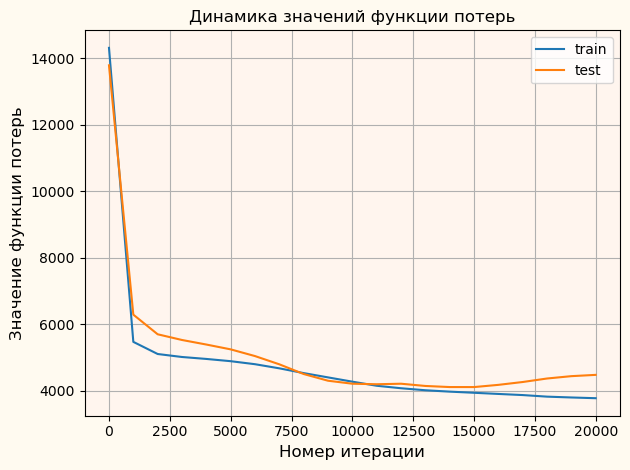

RMSE_test = 13782.169921875, RMSE_train = 14307.330078125, RMSE_MIN_TEST = 13782.169921875, epoch = 0
RMSE_test = 6335.47021484375, RMSE_train = 5492.56982421875, RMSE_MIN_TEST = 6335.47021484375, epoch = 1000
RMSE_test = 5703.0, RMSE_train = 5107.0498046875, RMSE_MIN_TEST = 5703.0, epoch = 2000
RMSE_test = 5504.7998046875, RMSE_train = 5000.72021484375, RMSE_MIN_TEST = 5503.85986328125, epoch = 3000
RMSE_test = 5309.9599609375, RMSE_train = 4909.7998046875, RMSE_MIN_TEST = 5306.740234375, epoch = 4000
RMSE_test = 5067.72998046875, RMSE_train = 4804.52978515625, RMSE_MIN_TEST = 5067.66015625, epoch = 5000
RMSE_test = 4811.91015625, RMSE_train = 4689.759765625, RMSE_MIN_TEST = 4811.91015625, epoch = 6000
RMSE_test = 4590.5498046875, RMSE_train = 4569.68017578125, RMSE_MIN_TEST = 4590.3798828125, epoch = 7000
RMSE_test = 4441.16015625, RMSE_train = 4470.490234375, RMSE_MIN_TEST = 4439.2099609375, epoch = 8000
RMSE_test = 4351.18994140625, RMSE_train = 4383.72021484375, RMSE_MIN_TEST = 43

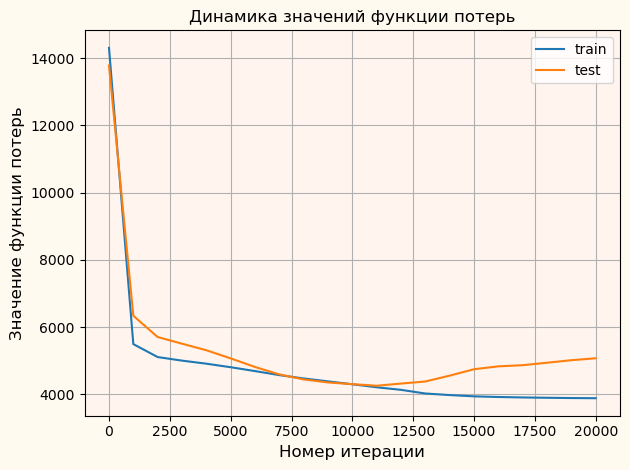

RMSE_test = 13783.9296875, RMSE_train = 14308.990234375, RMSE_MIN_TEST = 13783.9296875, epoch = 0
RMSE_test = 6338.52001953125, RMSE_train = 5496.97021484375, RMSE_MIN_TEST = 6338.52001953125, epoch = 1000
RMSE_test = 5701.830078125, RMSE_train = 5105.419921875, RMSE_MIN_TEST = 5701.009765625, epoch = 2000
RMSE_test = 5547.02001953125, RMSE_train = 5025.60986328125, RMSE_MIN_TEST = 5547.02001953125, epoch = 3000
RMSE_test = 5390.06005859375, RMSE_train = 4952.02978515625, RMSE_MIN_TEST = 5389.4501953125, epoch = 4000
RMSE_test = 5189.47021484375, RMSE_train = 4861.3798828125, RMSE_MIN_TEST = 5189.47021484375, epoch = 5000
RMSE_test = 4950.9501953125, RMSE_train = 4750.81005859375, RMSE_MIN_TEST = 4950.93994140625, epoch = 6000
RMSE_test = 4712.35986328125, RMSE_train = 4631.33984375, RMSE_MIN_TEST = 4712.27978515625, epoch = 7000
RMSE_test = 4493.14013671875, RMSE_train = 4509.66015625, RMSE_MIN_TEST = 4492.93017578125, epoch = 8000
RMSE_test = 4306.91015625, RMSE_train = 4385.43017578

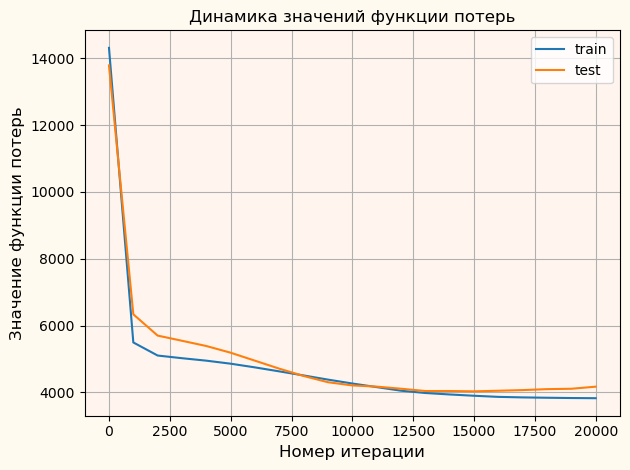

RMSE_test = 13782.5302734375, RMSE_train = 14307.7802734375, RMSE_MIN_TEST = 13782.5302734375, epoch = 0
RMSE_test = 6401.06005859375, RMSE_train = 5537.240234375, RMSE_MIN_TEST = 6401.06005859375, epoch = 1000
RMSE_test = 5720.41015625, RMSE_train = 5108.89990234375, RMSE_MIN_TEST = 5720.41015625, epoch = 2000
RMSE_test = 5529.0400390625, RMSE_train = 5007.18017578125, RMSE_MIN_TEST = 5527.8701171875, epoch = 3000
RMSE_test = 5333.2900390625, RMSE_train = 4916.9501953125, RMSE_MIN_TEST = 5332.93017578125, epoch = 4000
RMSE_test = 5110.18017578125, RMSE_train = 4811.43994140625, RMSE_MIN_TEST = 5110.18017578125, epoch = 5000
RMSE_test = 4849.52001953125, RMSE_train = 4689.85009765625, RMSE_MIN_TEST = 4849.52001953125, epoch = 6000
RMSE_test = 4615.580078125, RMSE_train = 4568.93017578125, RMSE_MIN_TEST = 4615.35986328125, epoch = 7000
RMSE_test = 4436.759765625, RMSE_train = 4448.68994140625, RMSE_MIN_TEST = 4433.93017578125, epoch = 8000
RMSE_test = 4312.64013671875, RMSE_train = 4327

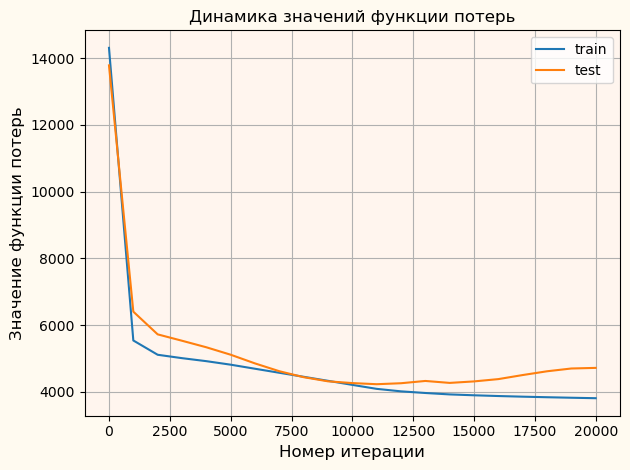

RMSE_test = 13783.8701171875, RMSE_train = 14309.0, RMSE_MIN_TEST = 13783.8701171875, epoch = 0
RMSE_test = 6205.419921875, RMSE_train = 5410.77978515625, RMSE_MIN_TEST = 6205.419921875, epoch = 1000
RMSE_test = 5645.58984375, RMSE_train = 5082.72021484375, RMSE_MIN_TEST = 5644.06982421875, epoch = 2000
RMSE_test = 5439.2099609375, RMSE_train = 4979.10009765625, RMSE_MIN_TEST = 5438.72021484375, epoch = 3000
RMSE_test = 5286.509765625, RMSE_train = 4914.31005859375, RMSE_MIN_TEST = 5286.509765625, epoch = 4000
RMSE_test = 5153.7001953125, RMSE_train = 4861.759765625, RMSE_MIN_TEST = 5153.6201171875, epoch = 5000
RMSE_test = 5009.7900390625, RMSE_train = 4800.830078125, RMSE_MIN_TEST = 5009.7900390625, epoch = 6000
RMSE_test = 4862.68017578125, RMSE_train = 4736.10986328125, RMSE_MIN_TEST = 4862.68017578125, epoch = 7000
RMSE_test = 4715.8701171875, RMSE_train = 4670.56005859375, RMSE_MIN_TEST = 4712.759765625, epoch = 8000
RMSE_test = 4568.740234375, RMSE_train = 4601.27001953125, RMSE

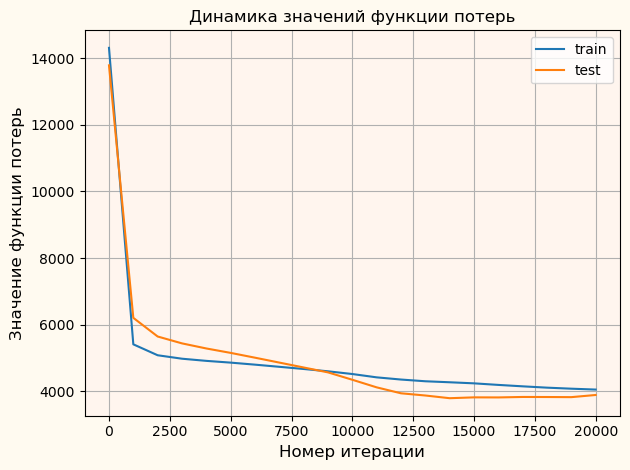

RMSE_test = 13788.009765625, RMSE_train = 14312.5302734375, RMSE_MIN_TEST = 13788.009765625, epoch = 0
RMSE_test = 6329.3701171875, RMSE_train = 5485.47021484375, RMSE_MIN_TEST = 6329.3701171875, epoch = 1000
RMSE_test = 5705.0, RMSE_train = 5103.330078125, RMSE_MIN_TEST = 5705.0, epoch = 2000
RMSE_test = 5525.06005859375, RMSE_train = 5010.64990234375, RMSE_MIN_TEST = 5524.14990234375, epoch = 3000
RMSE_test = 5346.75, RMSE_train = 4928.419921875, RMSE_MIN_TEST = 5346.75, epoch = 4000
RMSE_test = 5129.33984375, RMSE_train = 4837.4599609375, RMSE_MIN_TEST = 5129.33984375, epoch = 5000
RMSE_test = 4904.52001953125, RMSE_train = 4735.39013671875, RMSE_MIN_TEST = 4904.52001953125, epoch = 6000
RMSE_test = 4674.8798828125, RMSE_train = 4618.89013671875, RMSE_MIN_TEST = 4674.83984375, epoch = 7000
RMSE_test = 4450.47021484375, RMSE_train = 4492.64013671875, RMSE_MIN_TEST = 4448.27978515625, epoch = 8000
RMSE_test = 4279.22998046875, RMSE_train = 4368.2099609375, RMSE_MIN_TEST = 4272.5097656

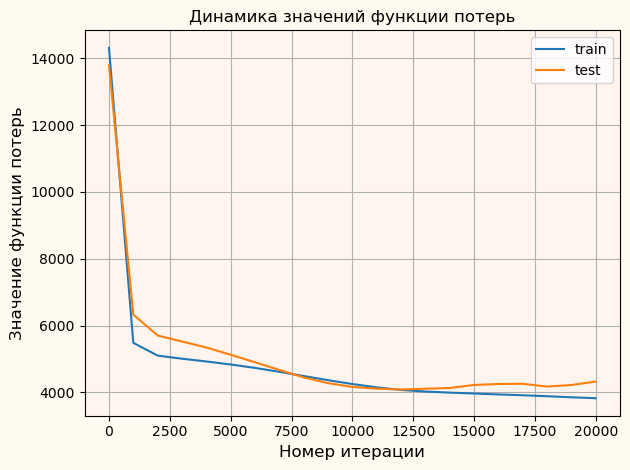

RMSE_test = 13782.5, RMSE_train = 14307.7197265625, RMSE_MIN_TEST = 13782.5, epoch = 0
RMSE_test = 6268.7099609375, RMSE_train = 5443.0400390625, RMSE_MIN_TEST = 6268.7099609375, epoch = 1000
RMSE_test = 5685.7099609375, RMSE_train = 5118.009765625, RMSE_MIN_TEST = 5682.6201171875, epoch = 2000
RMSE_test = 5499.009765625, RMSE_train = 5023.0, RMSE_MIN_TEST = 5499.009765625, epoch = 3000
RMSE_test = 5372.64990234375, RMSE_train = 4965.4599609375, RMSE_MIN_TEST = 5370.93994140625, epoch = 4000
RMSE_test = 5279.14990234375, RMSE_train = 4927.35009765625, RMSE_MIN_TEST = 5277.75, epoch = 5000
RMSE_test = 5140.18994140625, RMSE_train = 4861.52978515625, RMSE_MIN_TEST = 5139.25, epoch = 6000
RMSE_test = 5021.240234375, RMSE_train = 4805.740234375, RMSE_MIN_TEST = 5020.9501953125, epoch = 7000
RMSE_test = 4898.7001953125, RMSE_train = 4753.25, RMSE_MIN_TEST = 4898.7001953125, epoch = 8000
RMSE_test = 4789.68017578125, RMSE_train = 4702.7998046875, RMSE_MIN_TEST = 4788.1298828125, epoch = 9000

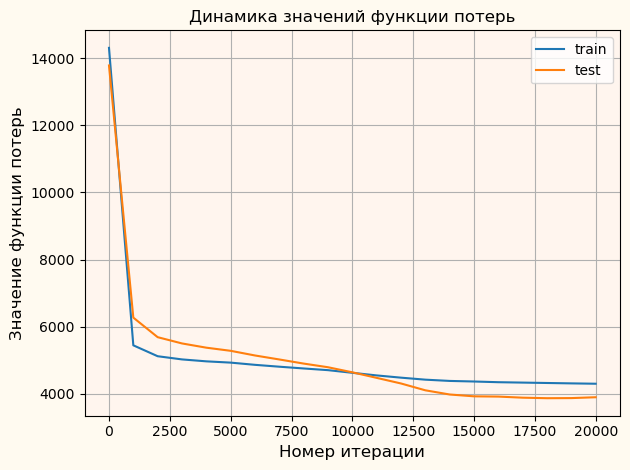

RMSE_test = 13789.1298828125, RMSE_train = 14313.6904296875, RMSE_MIN_TEST = 13789.1298828125, epoch = 0
RMSE_test = 6266.77978515625, RMSE_train = 5437.580078125, RMSE_MIN_TEST = 6266.77978515625, epoch = 1000
RMSE_test = 5681.419921875, RMSE_train = 5089.33984375, RMSE_MIN_TEST = 5681.419921875, epoch = 2000
RMSE_test = 5511.990234375, RMSE_train = 5008.509765625, RMSE_MIN_TEST = 5511.52001953125, epoch = 3000
RMSE_test = 5289.89990234375, RMSE_train = 4919.08984375, RMSE_MIN_TEST = 5289.89990234375, epoch = 4000
RMSE_test = 4964.93017578125, RMSE_train = 4745.18994140625, RMSE_MIN_TEST = 4964.75, epoch = 5000
RMSE_test = 4513.419921875, RMSE_train = 4497.06982421875, RMSE_MIN_TEST = 4513.419921875, epoch = 6000
RMSE_test = 4186.759765625, RMSE_train = 4269.080078125, RMSE_MIN_TEST = 4175.5498046875, epoch = 7000
RMSE_test = 4088.929931640625, RMSE_train = 4041.7900390625, RMSE_MIN_TEST = 4074.659912109375, epoch = 8000
RMSE_test = 4348.81982421875, RMSE_train = 3869.02001953125, RMS

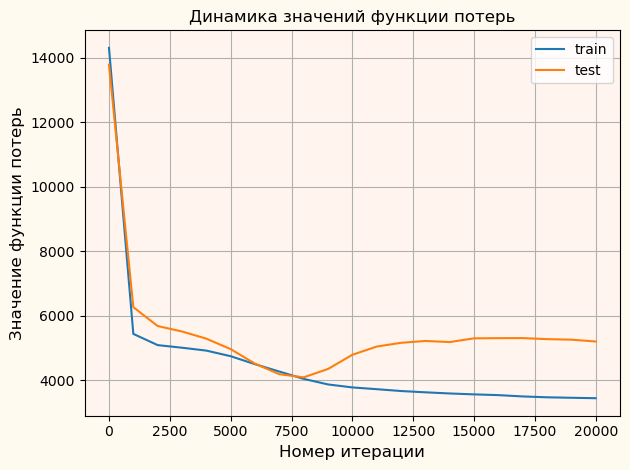

RMSE_test = 13780.740234375, RMSE_train = 14306.1904296875, RMSE_MIN_TEST = 13780.740234375, epoch = 0
RMSE_test = 6254.25, RMSE_train = 5433.490234375, RMSE_MIN_TEST = 6254.25, epoch = 1000
RMSE_test = 5679.7099609375, RMSE_train = 5088.240234375, RMSE_MIN_TEST = 5677.33984375, epoch = 2000
RMSE_test = 5514.10009765625, RMSE_train = 5009.81982421875, RMSE_MIN_TEST = 5514.10009765625, epoch = 3000
RMSE_test = 5376.0498046875, RMSE_train = 4952.02978515625, RMSE_MIN_TEST = 5375.91015625, epoch = 4000
RMSE_test = 5233.22998046875, RMSE_train = 4893.47998046875, RMSE_MIN_TEST = 5233.22998046875, epoch = 5000
RMSE_test = 5057.25, RMSE_train = 4822.33984375, RMSE_MIN_TEST = 5057.25, epoch = 6000
RMSE_test = 4814.16015625, RMSE_train = 4714.33984375, RMSE_MIN_TEST = 4814.10009765625, epoch = 7000
RMSE_test = 4480.419921875, RMSE_train = 4517.31982421875, RMSE_MIN_TEST = 4480.2998046875, epoch = 8000
RMSE_test = 4098.75, RMSE_train = 4267.85986328125, RMSE_MIN_TEST = 4083.7099609375, epoch = 

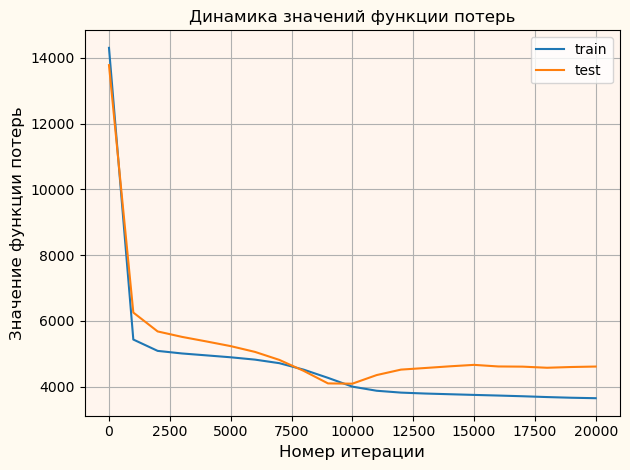

RMSE_test = 13786.1904296875, RMSE_train = 14311.0703125, RMSE_MIN_TEST = 13786.1904296875, epoch = 0
RMSE_test = 6245.91015625, RMSE_train = 5424.22998046875, RMSE_MIN_TEST = 6245.91015625, epoch = 1000
RMSE_test = 5634.10009765625, RMSE_train = 5065.47998046875, RMSE_MIN_TEST = 5630.18017578125, epoch = 2000
RMSE_test = 5357.5, RMSE_train = 4920.33984375, RMSE_MIN_TEST = 5357.41015625, epoch = 3000
RMSE_test = 5106.83984375, RMSE_train = 4807.240234375, RMSE_MIN_TEST = 5105.7099609375, epoch = 4000
RMSE_test = 4899.5400390625, RMSE_train = 4703.5498046875, RMSE_MIN_TEST = 4895.9501953125, epoch = 5000
RMSE_test = 4722.6298828125, RMSE_train = 4600.85009765625, RMSE_MIN_TEST = 4722.6298828125, epoch = 6000
RMSE_test = 4583.25, RMSE_train = 4486.72998046875, RMSE_MIN_TEST = 4583.25, epoch = 7000
RMSE_test = 4494.4599609375, RMSE_train = 4373.2998046875, RMSE_MIN_TEST = 4491.14990234375, epoch = 8000
RMSE_test = 4379.08984375, RMSE_train = 4257.490234375, RMSE_MIN_TEST = 4376.08984375, 

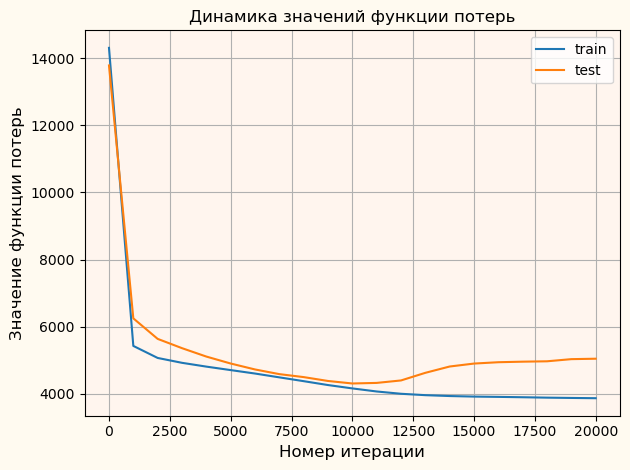

RMSE_test = 13785.4599609375, RMSE_train = 14310.5595703125, RMSE_MIN_TEST = 13785.4599609375, epoch = 0
RMSE_test = 6473.5400390625, RMSE_train = 5590.10009765625, RMSE_MIN_TEST = 6473.5400390625, epoch = 1000
RMSE_test = 5761.77001953125, RMSE_train = 5129.6298828125, RMSE_MIN_TEST = 5760.669921875, epoch = 2000
RMSE_test = 5573.10986328125, RMSE_train = 5038.759765625, RMSE_MIN_TEST = 5573.10986328125, epoch = 3000
RMSE_test = 5440.2900390625, RMSE_train = 4975.58984375, RMSE_MIN_TEST = 5438.27001953125, epoch = 4000
RMSE_test = 5278.2099609375, RMSE_train = 4908.2001953125, RMSE_MIN_TEST = 5277.5400390625, epoch = 5000
RMSE_test = 5097.89990234375, RMSE_train = 4831.1298828125, RMSE_MIN_TEST = 5097.89990234375, epoch = 6000
RMSE_test = 4873.009765625, RMSE_train = 4730.419921875, RMSE_MIN_TEST = 4873.009765625, epoch = 7000
RMSE_test = 4603.72998046875, RMSE_train = 4609.43994140625, RMSE_MIN_TEST = 4603.72998046875, epoch = 8000
RMSE_test = 4332.919921875, RMSE_train = 4476.450195

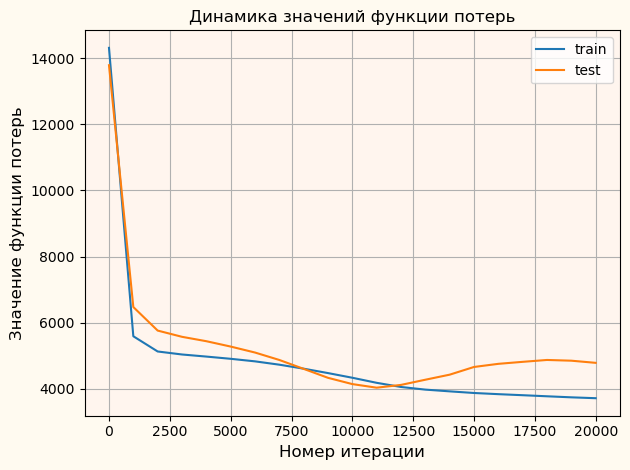

RMSE_test = 13782.41015625, RMSE_train = 14307.759765625, RMSE_MIN_TEST = 13782.41015625, epoch = 0
RMSE_test = 6296.68017578125, RMSE_train = 5457.72021484375, RMSE_MIN_TEST = 6296.68017578125, epoch = 1000
RMSE_test = 5711.06982421875, RMSE_train = 5105.39990234375, RMSE_MIN_TEST = 5711.06982421875, epoch = 2000
RMSE_test = 5529.35986328125, RMSE_train = 5012.35009765625, RMSE_MIN_TEST = 5529.35986328125, epoch = 3000
RMSE_test = 5356.9599609375, RMSE_train = 4934.7998046875, RMSE_MIN_TEST = 5356.919921875, epoch = 4000
RMSE_test = 5177.60009765625, RMSE_train = 4862.580078125, RMSE_MIN_TEST = 5177.60009765625, epoch = 5000
RMSE_test = 5013.56982421875, RMSE_train = 4796.3701171875, RMSE_MIN_TEST = 5013.56982421875, epoch = 6000
RMSE_test = 4869.06982421875, RMSE_train = 4727.56982421875, RMSE_MIN_TEST = 4869.06982421875, epoch = 7000
RMSE_test = 4699.419921875, RMSE_train = 4643.16015625, RMSE_MIN_TEST = 4699.419921875, epoch = 8000
RMSE_test = 4454.72021484375, RMSE_train = 4520.74

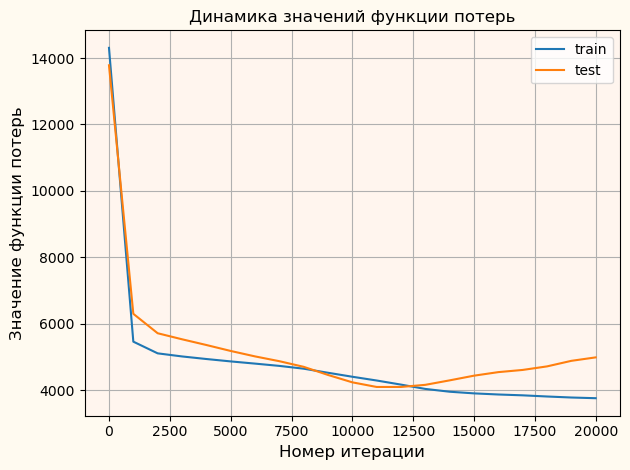

RMSE_test = 13786.2802734375, RMSE_train = 14310.9599609375, RMSE_MIN_TEST = 13786.2802734375, epoch = 0
RMSE_test = 6215.6298828125, RMSE_train = 5410.919921875, RMSE_MIN_TEST = 6215.6298828125, epoch = 1000
RMSE_test = 5662.8701171875, RMSE_train = 5081.97021484375, RMSE_MIN_TEST = 5662.64990234375, epoch = 2000
RMSE_test = 5464.43994140625, RMSE_train = 4982.4501953125, RMSE_MIN_TEST = 5464.43994140625, epoch = 3000
RMSE_test = 5200.6298828125, RMSE_train = 4859.490234375, RMSE_MIN_TEST = 5199.830078125, epoch = 4000
RMSE_test = 4877.81005859375, RMSE_train = 4722.2099609375, RMSE_MIN_TEST = 4877.81005859375, epoch = 5000
RMSE_test = 4594.35986328125, RMSE_train = 4581.2099609375, RMSE_MIN_TEST = 4594.35986328125, epoch = 6000
RMSE_test = 4386.3701171875, RMSE_train = 4436.2998046875, RMSE_MIN_TEST = 4386.3701171875, epoch = 7000
RMSE_test = 4221.419921875, RMSE_train = 4286.97021484375, RMSE_MIN_TEST = 4214.14990234375, epoch = 8000
RMSE_test = 4042.39990234375, RMSE_train = 4136.1

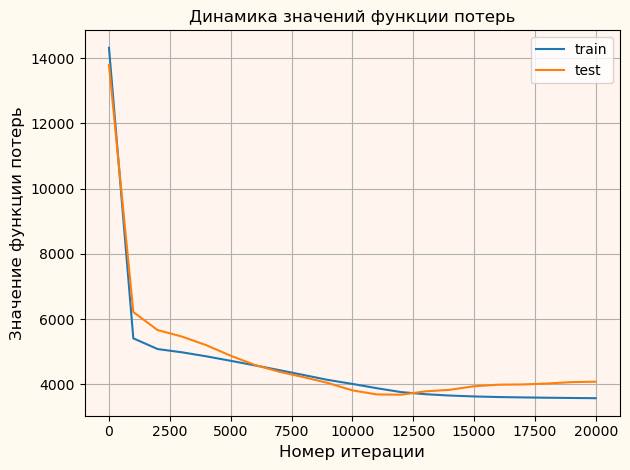

RMSE_test = 13780.3896484375, RMSE_train = 14305.83984375, RMSE_MIN_TEST = 13780.3896484375, epoch = 0
RMSE_test = 6294.31005859375, RMSE_train = 5456.10009765625, RMSE_MIN_TEST = 6294.31005859375, epoch = 1000
RMSE_test = 5703.7001953125, RMSE_train = 5103.1201171875, RMSE_MIN_TEST = 5702.77978515625, epoch = 2000
RMSE_test = 5549.990234375, RMSE_train = 5022.2099609375, RMSE_MIN_TEST = 5548.22021484375, epoch = 3000
RMSE_test = 5415.39013671875, RMSE_train = 4965.8798828125, RMSE_MIN_TEST = 5415.39013671875, epoch = 4000
RMSE_test = 5297.60009765625, RMSE_train = 4915.41015625, RMSE_MIN_TEST = 5297.60009765625, epoch = 5000
RMSE_test = 5177.830078125, RMSE_train = 4868.0400390625, RMSE_MIN_TEST = 5177.5, epoch = 6000
RMSE_test = 5069.31005859375, RMSE_train = 4818.85009765625, RMSE_MIN_TEST = 5069.31005859375, epoch = 7000
RMSE_test = 4867.10009765625, RMSE_train = 4723.2099609375, RMSE_MIN_TEST = 4867.10009765625, epoch = 8000
RMSE_test = 4596.89990234375, RMSE_train = 4616.06982421

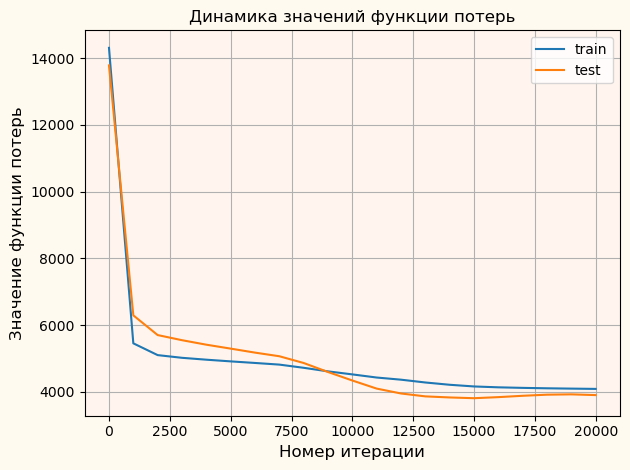

RMSE_test = 13785.0595703125, RMSE_train = 14309.98046875, RMSE_MIN_TEST = 13785.0595703125, epoch = 0
RMSE_test = 6469.85009765625, RMSE_train = 5599.240234375, RMSE_MIN_TEST = 6469.85009765625, epoch = 1000
RMSE_test = 5729.4599609375, RMSE_train = 5129.64990234375, RMSE_MIN_TEST = 5728.14013671875, epoch = 2000
RMSE_test = 5516.64013671875, RMSE_train = 5010.18994140625, RMSE_MIN_TEST = 5515.47998046875, epoch = 3000
RMSE_test = 5312.9501953125, RMSE_train = 4918.080078125, RMSE_MIN_TEST = 5312.9501953125, epoch = 4000
RMSE_test = 5082.35986328125, RMSE_train = 4833.3701171875, RMSE_MIN_TEST = 5082.35986328125, epoch = 5000
RMSE_test = 4842.66015625, RMSE_train = 4749.5400390625, RMSE_MIN_TEST = 4842.18994140625, epoch = 6000
RMSE_test = 4601.27978515625, RMSE_train = 4665.60986328125, RMSE_MIN_TEST = 4601.27978515625, epoch = 7000
RMSE_test = 4427.60009765625, RMSE_train = 4586.14013671875, RMSE_MIN_TEST = 4427.60009765625, epoch = 8000
RMSE_test = 4290.18994140625, RMSE_train = 45

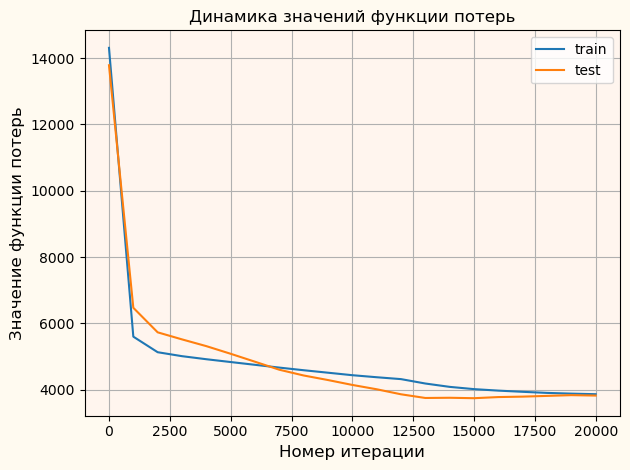

RMSE_test = 13783.8603515625, RMSE_train = 14308.919921875, RMSE_MIN_TEST = 13783.8603515625, epoch = 0
RMSE_test = 6280.02001953125, RMSE_train = 5445.14013671875, RMSE_MIN_TEST = 6280.02001953125, epoch = 1000
RMSE_test = 5691.8701171875, RMSE_train = 5097.10009765625, RMSE_MIN_TEST = 5691.8701171875, epoch = 2000
RMSE_test = 5488.47998046875, RMSE_train = 4990.4599609375, RMSE_MIN_TEST = 5487.39990234375, epoch = 3000
RMSE_test = 5289.240234375, RMSE_train = 4912.64013671875, RMSE_MIN_TEST = 5289.240234375, epoch = 4000
RMSE_test = 5128.10986328125, RMSE_train = 4851.08984375, RMSE_MIN_TEST = 5128.10986328125, epoch = 5000
RMSE_test = 5004.72021484375, RMSE_train = 4799.47021484375, RMSE_MIN_TEST = 5004.35009765625, epoch = 6000
RMSE_test = 4893.75, RMSE_train = 4747.5498046875, RMSE_MIN_TEST = 4893.75, epoch = 7000
RMSE_test = 4757.5400390625, RMSE_train = 4678.5400390625, RMSE_MIN_TEST = 4755.2001953125, epoch = 8000
RMSE_test = 4598.9599609375, RMSE_train = 4609.2900390625, RMSE_

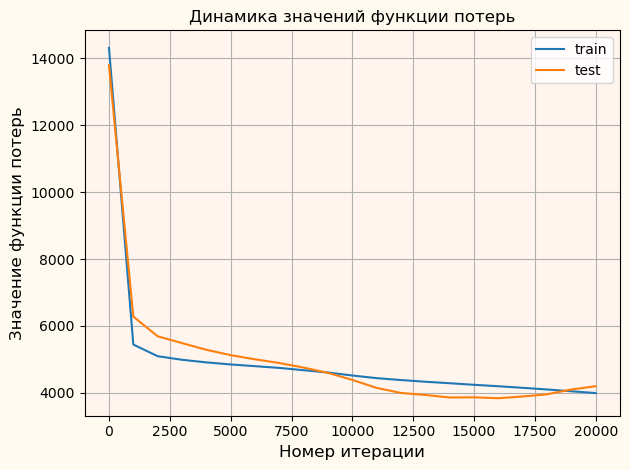

RMSE_test = 13784.4697265625, RMSE_train = 14309.66015625, RMSE_MIN_TEST = 13784.4697265625, epoch = 0
RMSE_test = 6258.66015625, RMSE_train = 5440.9599609375, RMSE_MIN_TEST = 6258.66015625, epoch = 1000
RMSE_test = 5683.39013671875, RMSE_train = 5095.43994140625, RMSE_MIN_TEST = 5681.240234375, epoch = 2000
RMSE_test = 5558.419921875, RMSE_train = 5028.14990234375, RMSE_MIN_TEST = 5556.22021484375, epoch = 3000
RMSE_test = 5429.9599609375, RMSE_train = 4975.66015625, RMSE_MIN_TEST = 5429.9599609375, epoch = 4000
RMSE_test = 5325.1298828125, RMSE_train = 4928.35009765625, RMSE_MIN_TEST = 5324.66015625, epoch = 5000
RMSE_test = 5226.7099609375, RMSE_train = 4886.47998046875, RMSE_MIN_TEST = 5226.7099609375, epoch = 6000
RMSE_test = 5140.10986328125, RMSE_train = 4845.419921875, RMSE_MIN_TEST = 5139.85986328125, epoch = 7000
RMSE_test = 5041.2001953125, RMSE_train = 4799.759765625, RMSE_MIN_TEST = 5041.2001953125, epoch = 8000
RMSE_test = 4903.64990234375, RMSE_train = 4733.77001953125, 

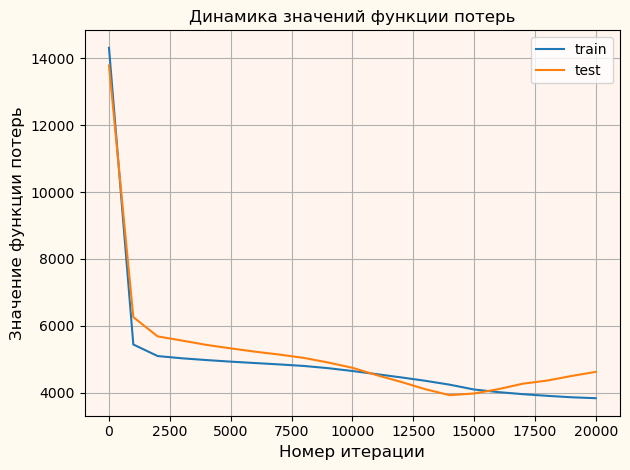

RMSE_test = 13785.080078125, RMSE_train = 14310.3095703125, RMSE_MIN_TEST = 13785.080078125, epoch = 0
RMSE_test = 6363.4501953125, RMSE_train = 5519.919921875, RMSE_MIN_TEST = 6363.4501953125, epoch = 1000
RMSE_test = 5677.4501953125, RMSE_train = 5087.0, RMSE_MIN_TEST = 5676.06005859375, epoch = 2000
RMSE_test = 5481.43994140625, RMSE_train = 4984.4599609375, RMSE_MIN_TEST = 5481.43994140625, epoch = 3000
RMSE_test = 5255.97021484375, RMSE_train = 4877.16015625, RMSE_MIN_TEST = 5255.97021484375, epoch = 4000
RMSE_test = 4998.68017578125, RMSE_train = 4765.3798828125, RMSE_MIN_TEST = 4998.56982421875, epoch = 5000
RMSE_test = 4752.31005859375, RMSE_train = 4645.330078125, RMSE_MIN_TEST = 4749.3701171875, epoch = 6000
RMSE_test = 4538.35986328125, RMSE_train = 4512.4599609375, RMSE_MIN_TEST = 4537.93994140625, epoch = 7000
RMSE_test = 4364.259765625, RMSE_train = 4366.83984375, RMSE_MIN_TEST = 4360.06005859375, epoch = 8000
RMSE_test = 4189.89013671875, RMSE_train = 4222.3798828125, RM

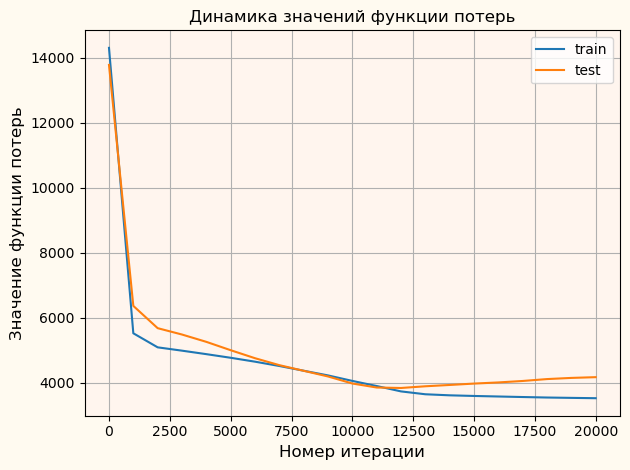

RMSE_test = 13785.16015625, RMSE_train = 14310.16015625, RMSE_MIN_TEST = 13785.16015625, epoch = 0
RMSE_test = 6354.6298828125, RMSE_train = 5506.080078125, RMSE_MIN_TEST = 6354.6298828125, epoch = 1000
RMSE_test = 5715.31005859375, RMSE_train = 5106.4599609375, RMSE_MIN_TEST = 5715.18017578125, epoch = 2000
RMSE_test = 5547.740234375, RMSE_train = 5019.7099609375, RMSE_MIN_TEST = 5547.509765625, epoch = 3000
RMSE_test = 5385.240234375, RMSE_train = 4948.490234375, RMSE_MIN_TEST = 5385.240234375, epoch = 4000
RMSE_test = 5204.52978515625, RMSE_train = 4867.14990234375, RMSE_MIN_TEST = 5204.10009765625, epoch = 5000
RMSE_test = 4992.68017578125, RMSE_train = 4772.83984375, RMSE_MIN_TEST = 4992.68017578125, epoch = 6000
RMSE_test = 4736.60986328125, RMSE_train = 4649.9501953125, RMSE_MIN_TEST = 4736.60986328125, epoch = 7000
RMSE_test = 4494.75, RMSE_train = 4521.7998046875, RMSE_MIN_TEST = 4494.75, epoch = 8000
RMSE_test = 4331.22021484375, RMSE_train = 4394.06005859375, RMSE_MIN_TEST =

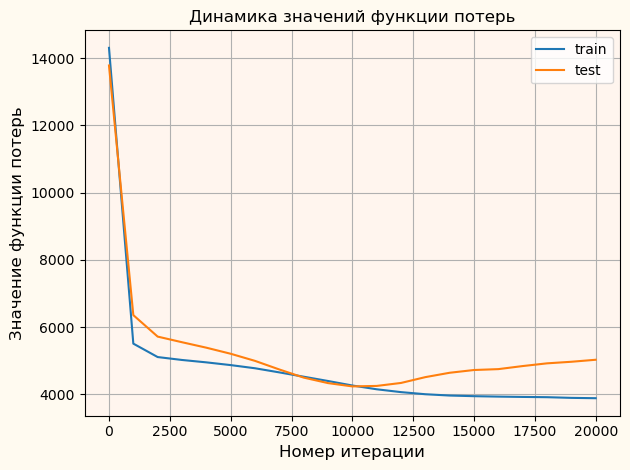

RMSE_test = 13783.5498046875, RMSE_train = 14308.6298828125, RMSE_MIN_TEST = 13783.5498046875, epoch = 0
RMSE_test = 6329.169921875, RMSE_train = 5493.990234375, RMSE_MIN_TEST = 6329.169921875, epoch = 1000
RMSE_test = 5699.33984375, RMSE_train = 5112.41015625, RMSE_MIN_TEST = 5696.85986328125, epoch = 2000
RMSE_test = 5507.10009765625, RMSE_train = 5009.669921875, RMSE_MIN_TEST = 5506.91015625, epoch = 3000
RMSE_test = 5327.759765625, RMSE_train = 4932.22998046875, RMSE_MIN_TEST = 5327.759765625, epoch = 4000
RMSE_test = 5144.47021484375, RMSE_train = 4860.1201171875, RMSE_MIN_TEST = 5144.22998046875, epoch = 5000
RMSE_test = 4937.52001953125, RMSE_train = 4778.47998046875, RMSE_MIN_TEST = 4937.52001953125, epoch = 6000
RMSE_test = 4728.419921875, RMSE_train = 4697.1298828125, RMSE_MIN_TEST = 4728.419921875, epoch = 7000
RMSE_test = 4527.52001953125, RMSE_train = 4616.35986328125, RMSE_MIN_TEST = 4527.259765625, epoch = 8000
RMSE_test = 4329.2001953125, RMSE_train = 4542.22021484375, 

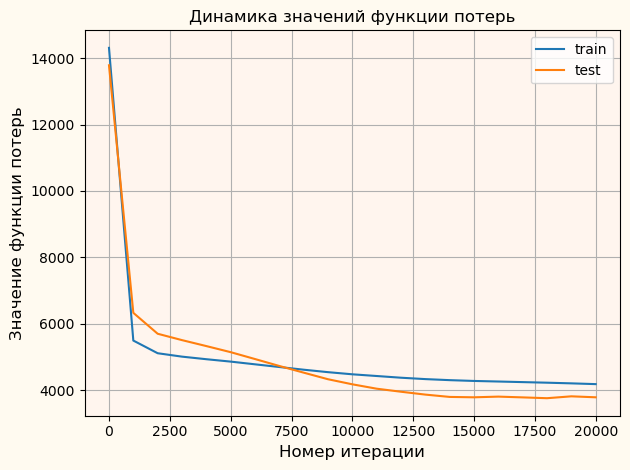

RMSE_test = 13785.919921875, RMSE_train = 14310.9501953125, RMSE_MIN_TEST = 13785.919921875, epoch = 0
RMSE_test = 6240.259765625, RMSE_train = 5431.16015625, RMSE_MIN_TEST = 6240.259765625, epoch = 1000
RMSE_test = 5656.1201171875, RMSE_train = 5075.02978515625, RMSE_MIN_TEST = 5651.740234375, epoch = 2000
RMSE_test = 5458.0, RMSE_train = 4978.8701171875, RMSE_MIN_TEST = 5457.81982421875, epoch = 3000
RMSE_test = 5252.7900390625, RMSE_train = 4884.1298828125, RMSE_MIN_TEST = 5252.3798828125, epoch = 4000
RMSE_test = 4992.52001953125, RMSE_train = 4774.6298828125, RMSE_MIN_TEST = 4992.52001953125, epoch = 5000
RMSE_test = 4732.60986328125, RMSE_train = 4658.10986328125, RMSE_MIN_TEST = 4732.60986328125, epoch = 6000
RMSE_test = 4499.6298828125, RMSE_train = 4537.02978515625, RMSE_MIN_TEST = 4498.1298828125, epoch = 7000
RMSE_test = 4322.259765625, RMSE_train = 4422.77001953125, RMSE_MIN_TEST = 4315.6298828125, epoch = 8000
RMSE_test = 4262.990234375, RMSE_train = 4324.58984375, RMSE_MI

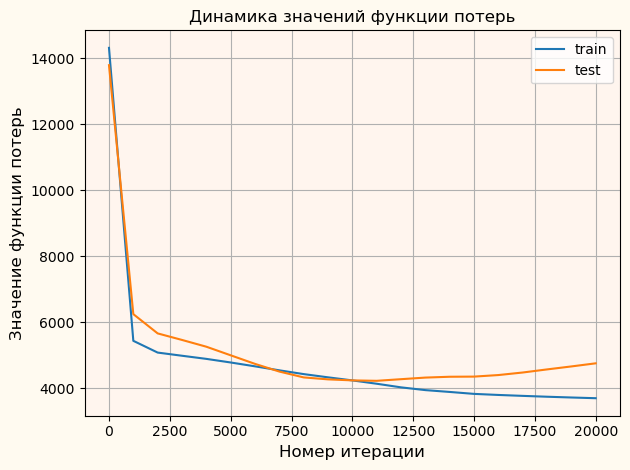

RMSE_test = 13786.51953125, RMSE_train = 14311.5400390625, RMSE_MIN_TEST = 13786.51953125, epoch = 0
RMSE_test = 6716.58984375, RMSE_train = 5803.2099609375, RMSE_MIN_TEST = 6716.58984375, epoch = 1000
RMSE_test = 5815.41015625, RMSE_train = 5179.7998046875, RMSE_MIN_TEST = 5815.41015625, epoch = 2000
RMSE_test = 5590.8701171875, RMSE_train = 5067.47021484375, RMSE_MIN_TEST = 5590.8701171875, epoch = 3000
RMSE_test = 5467.66015625, RMSE_train = 5005.60986328125, RMSE_MIN_TEST = 5466.25, epoch = 4000
RMSE_test = 5344.33984375, RMSE_train = 4946.6201171875, RMSE_MIN_TEST = 5344.33984375, epoch = 5000
RMSE_test = 5244.77001953125, RMSE_train = 4900.02001953125, RMSE_MIN_TEST = 5244.77001953125, epoch = 6000
RMSE_test = 5118.080078125, RMSE_train = 4839.97021484375, RMSE_MIN_TEST = 5118.0400390625, epoch = 7000
RMSE_test = 4908.81005859375, RMSE_train = 4720.2900390625, RMSE_MIN_TEST = 4908.81005859375, epoch = 8000
RMSE_test = 4627.759765625, RMSE_train = 4578.669921875, RMSE_MIN_TEST = 4

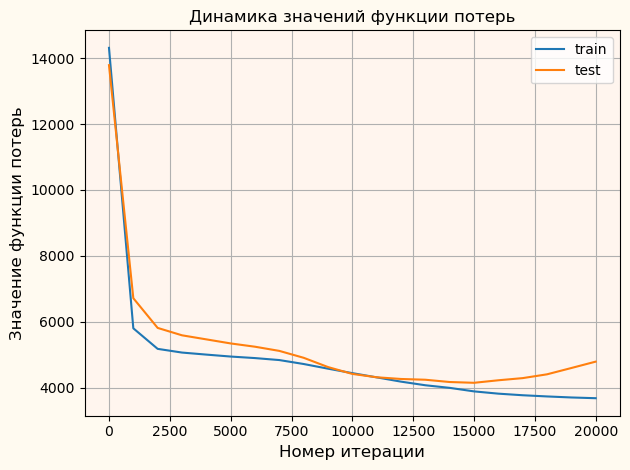

RMSE_test = 13783.2802734375, RMSE_train = 14308.23046875, RMSE_MIN_TEST = 13783.2802734375, epoch = 0
RMSE_test = 6285.60009765625, RMSE_train = 5461.14990234375, RMSE_MIN_TEST = 6285.60009765625, epoch = 1000
RMSE_test = 5696.85986328125, RMSE_train = 5123.080078125, RMSE_MIN_TEST = 5696.85986328125, epoch = 2000
RMSE_test = 5507.75, RMSE_train = 5027.3701171875, RMSE_MIN_TEST = 5507.75, epoch = 3000
RMSE_test = 5364.85986328125, RMSE_train = 4953.14990234375, RMSE_MIN_TEST = 5364.740234375, epoch = 4000
RMSE_test = 5212.27001953125, RMSE_train = 4880.7900390625, RMSE_MIN_TEST = 5212.27001953125, epoch = 5000
RMSE_test = 5055.830078125, RMSE_train = 4815.68017578125, RMSE_MIN_TEST = 5055.830078125, epoch = 6000
RMSE_test = 4891.27001953125, RMSE_train = 4750.72998046875, RMSE_MIN_TEST = 4891.27001953125, epoch = 7000
RMSE_test = 4733.990234375, RMSE_train = 4686.60986328125, RMSE_MIN_TEST = 4733.52978515625, epoch = 8000
RMSE_test = 4536.64013671875, RMSE_train = 4606.5, RMSE_MIN_TES

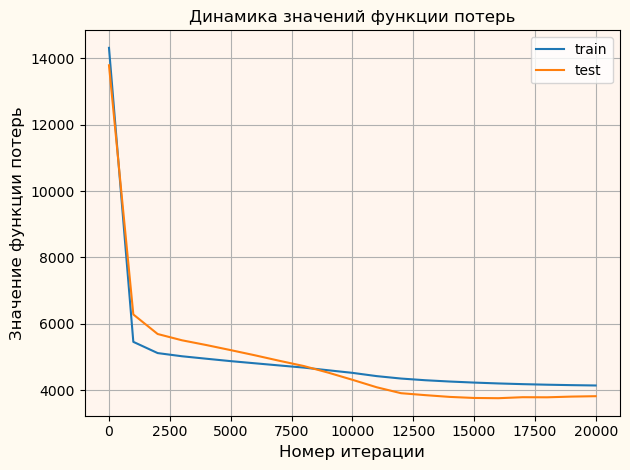

RMSE_test = 13785.5302734375, RMSE_train = 14310.400390625, RMSE_MIN_TEST = 13785.5302734375, epoch = 0
RMSE_test = 6518.56005859375, RMSE_train = 5622.9501953125, RMSE_MIN_TEST = 6518.56005859375, epoch = 1000
RMSE_test = 5735.72998046875, RMSE_train = 5118.85986328125, RMSE_MIN_TEST = 5735.1201171875, epoch = 2000
RMSE_test = 5525.27978515625, RMSE_train = 5014.759765625, RMSE_MIN_TEST = 5525.27978515625, epoch = 3000
RMSE_test = 5269.7998046875, RMSE_train = 4917.68994140625, RMSE_MIN_TEST = 5269.7998046875, epoch = 4000
RMSE_test = 5011.97998046875, RMSE_train = 4819.4501953125, RMSE_MIN_TEST = 5011.97998046875, epoch = 5000
RMSE_test = 4773.6298828125, RMSE_train = 4722.89990234375, RMSE_MIN_TEST = 4773.6298828125, epoch = 6000
RMSE_test = 4525.509765625, RMSE_train = 4608.5400390625, RMSE_MIN_TEST = 4525.509765625, epoch = 7000
RMSE_test = 4236.75, RMSE_train = 4453.740234375, RMSE_MIN_TEST = 4236.16015625, epoch = 8000
RMSE_test = 3921.60009765625, RMSE_train = 4242.75, RMSE_MIN

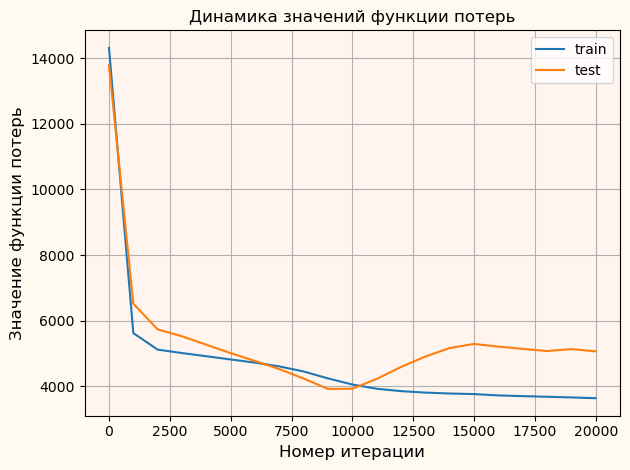

RMSE_test = 13786.740234375, RMSE_train = 14311.400390625, RMSE_MIN_TEST = 13786.740234375, epoch = 0
RMSE_test = 6298.72021484375, RMSE_train = 5461.18994140625, RMSE_MIN_TEST = 6298.72021484375, epoch = 1000
RMSE_test = 5653.14990234375, RMSE_train = 5066.18994140625, RMSE_MIN_TEST = 5647.60009765625, epoch = 2000
RMSE_test = 5386.93017578125, RMSE_train = 4930.43994140625, RMSE_MIN_TEST = 5386.93017578125, epoch = 3000
RMSE_test = 5117.3798828125, RMSE_train = 4810.97021484375, RMSE_MIN_TEST = 5116.4501953125, epoch = 4000
RMSE_test = 4876.35009765625, RMSE_train = 4706.47021484375, RMSE_MIN_TEST = 4874.97021484375, epoch = 5000
RMSE_test = 4711.35009765625, RMSE_train = 4607.81005859375, RMSE_MIN_TEST = 4710.85009765625, epoch = 6000
RMSE_test = 4578.83984375, RMSE_train = 4502.2001953125, RMSE_MIN_TEST = 4575.33984375, epoch = 7000
RMSE_test = 4438.5498046875, RMSE_train = 4396.47998046875, RMSE_MIN_TEST = 4438.5498046875, epoch = 8000
RMSE_test = 4350.1298828125, RMSE_train = 428

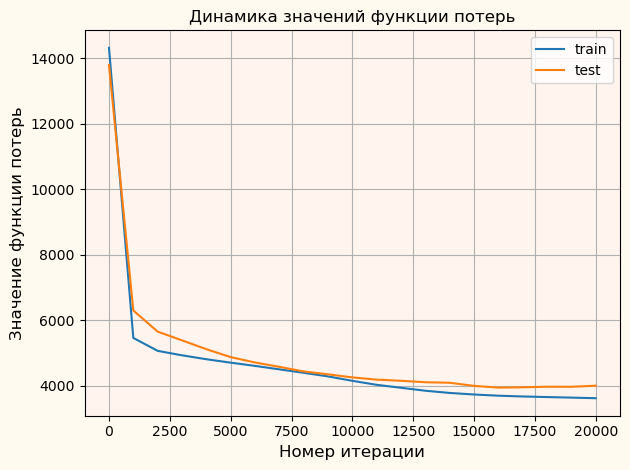

RMSE_test = 13785.26953125, RMSE_train = 14310.0595703125, RMSE_MIN_TEST = 13785.26953125, epoch = 0
RMSE_test = 6274.91015625, RMSE_train = 5451.39990234375, RMSE_MIN_TEST = 6274.91015625, epoch = 1000
RMSE_test = 5684.06005859375, RMSE_train = 5098.66015625, RMSE_MIN_TEST = 5684.06005859375, epoch = 2000
RMSE_test = 5467.64013671875, RMSE_train = 4990.47021484375, RMSE_MIN_TEST = 5467.64013671875, epoch = 3000
RMSE_test = 5224.52001953125, RMSE_train = 4898.1201171875, RMSE_MIN_TEST = 5224.1201171875, epoch = 4000
RMSE_test = 4963.72998046875, RMSE_train = 4797.43994140625, RMSE_MIN_TEST = 4963.72021484375, epoch = 5000
RMSE_test = 4714.169921875, RMSE_train = 4699.43994140625, RMSE_MIN_TEST = 4714.169921875, epoch = 6000
RMSE_test = 4459.93994140625, RMSE_train = 4593.7001953125, RMSE_MIN_TEST = 4459.5498046875, epoch = 7000
RMSE_test = 4199.52978515625, RMSE_train = 4467.27978515625, RMSE_MIN_TEST = 4199.52978515625, epoch = 8000
RMSE_test = 3981.43994140625, RMSE_train = 4327.7998

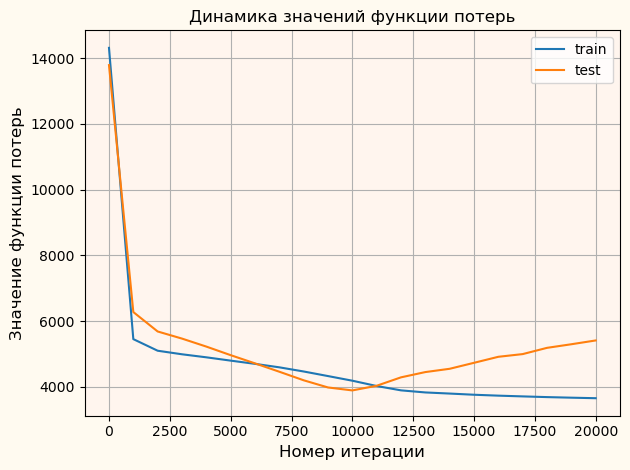

RMSE_test = 13785.0703125, RMSE_train = 14309.7197265625, RMSE_MIN_TEST = 13785.0703125, epoch = 0
RMSE_test = 6384.56982421875, RMSE_train = 5530.6298828125, RMSE_MIN_TEST = 6384.56982421875, epoch = 1000
RMSE_test = 5720.10009765625, RMSE_train = 5119.64990234375, RMSE_MIN_TEST = 5719.8701171875, epoch = 2000
RMSE_test = 5522.33984375, RMSE_train = 5009.81005859375, RMSE_MIN_TEST = 5521.0, epoch = 3000
RMSE_test = 5305.72021484375, RMSE_train = 4911.93994140625, RMSE_MIN_TEST = 5305.72021484375, epoch = 4000
RMSE_test = 4987.64990234375, RMSE_train = 4787.27001953125, RMSE_MIN_TEST = 4987.64990234375, epoch = 5000
RMSE_test = 4619.3798828125, RMSE_train = 4656.4501953125, RMSE_MIN_TEST = 4619.3798828125, epoch = 6000
RMSE_test = 4314.830078125, RMSE_train = 4543.31982421875, RMSE_MIN_TEST = 4314.830078125, epoch = 7000
RMSE_test = 4103.10009765625, RMSE_train = 4423.97021484375, RMSE_MIN_TEST = 4101.259765625, epoch = 8000
RMSE_test = 3977.7099609375, RMSE_train = 4313.93017578125, R

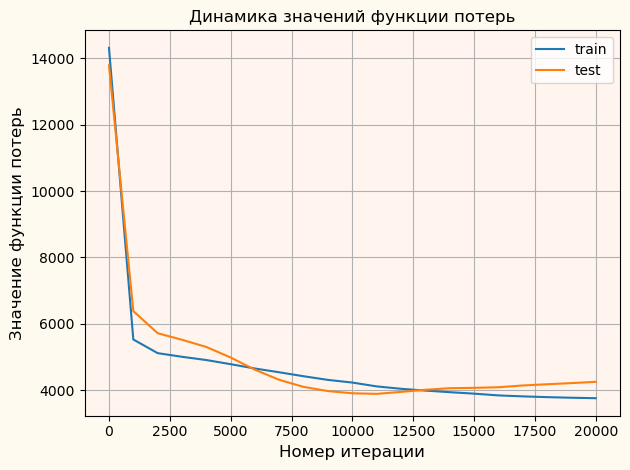

RMSE_test = 13785.75, RMSE_train = 14310.73046875, RMSE_MIN_TEST = 13785.75, epoch = 0
RMSE_test = 6462.91015625, RMSE_train = 5574.47998046875, RMSE_MIN_TEST = 6462.91015625, epoch = 1000
RMSE_test = 5745.31005859375, RMSE_train = 5121.14013671875, RMSE_MIN_TEST = 5744.39990234375, epoch = 2000
RMSE_test = 5560.18017578125, RMSE_train = 5028.4501953125, RMSE_MIN_TEST = 5559.7099609375, epoch = 3000
RMSE_test = 5420.85009765625, RMSE_train = 4963.5, RMSE_MIN_TEST = 5420.85009765625, epoch = 4000
RMSE_test = 5256.22998046875, RMSE_train = 4886.0498046875, RMSE_MIN_TEST = 5256.22998046875, epoch = 5000
RMSE_test = 5033.5, RMSE_train = 4789.89990234375, RMSE_MIN_TEST = 5033.5, epoch = 6000
RMSE_test = 4779.35009765625, RMSE_train = 4679.2001953125, RMSE_MIN_TEST = 4779.35009765625, epoch = 7000
RMSE_test = 4509.06005859375, RMSE_train = 4552.06005859375, RMSE_MIN_TEST = 4509.0498046875, epoch = 8000
RMSE_test = 4247.60009765625, RMSE_train = 4420.5400390625, RMSE_MIN_TEST = 4247.600097656

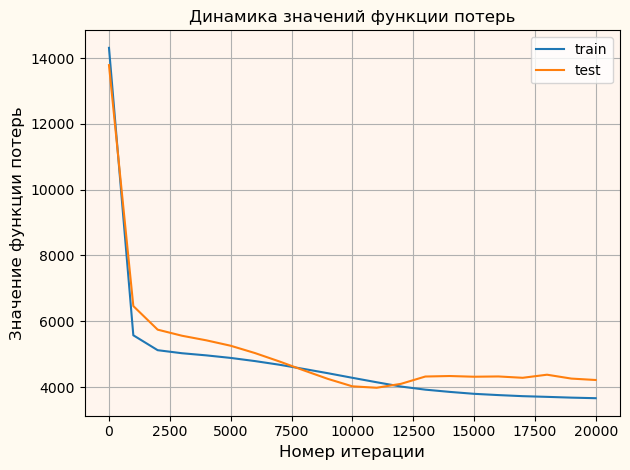

RMSE_test = 13782.8603515625, RMSE_train = 14308.0, RMSE_MIN_TEST = 13782.8603515625, epoch = 0
RMSE_test = 6297.6201171875, RMSE_train = 5469.60009765625, RMSE_MIN_TEST = 6297.6201171875, epoch = 1000
RMSE_test = 5710.8701171875, RMSE_train = 5104.77001953125, RMSE_MIN_TEST = 5709.47998046875, epoch = 2000
RMSE_test = 5535.39013671875, RMSE_train = 5018.93017578125, RMSE_MIN_TEST = 5534.93994140625, epoch = 3000
RMSE_test = 5291.419921875, RMSE_train = 4922.77978515625, RMSE_MIN_TEST = 5291.2900390625, epoch = 4000
RMSE_test = 5032.7998046875, RMSE_train = 4832.5498046875, RMSE_MIN_TEST = 5032.77978515625, epoch = 5000
RMSE_test = 4830.18994140625, RMSE_train = 4761.6298828125, RMSE_MIN_TEST = 4830.18994140625, epoch = 6000
RMSE_test = 4652.68017578125, RMSE_train = 4690.8701171875, RMSE_MIN_TEST = 4652.66015625, epoch = 7000
RMSE_test = 4469.60009765625, RMSE_train = 4617.669921875, RMSE_MIN_TEST = 4469.52001953125, epoch = 8000
RMSE_test = 4293.35986328125, RMSE_train = 4544.1098632

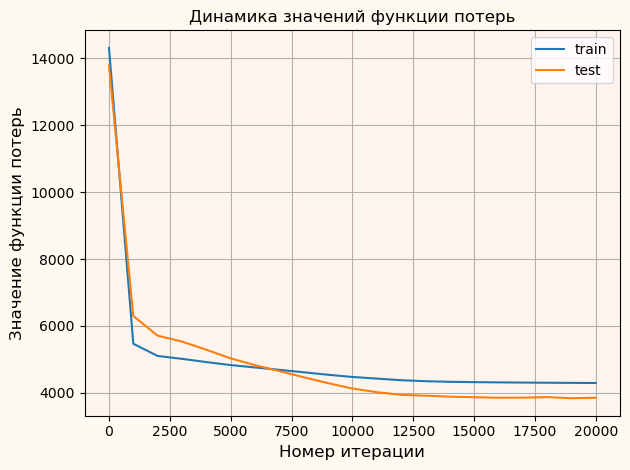

RMSE_test = 13785.259765625, RMSE_train = 14310.1904296875, RMSE_MIN_TEST = 13785.259765625, epoch = 0
RMSE_test = 6451.39990234375, RMSE_train = 5576.4501953125, RMSE_MIN_TEST = 6451.39990234375, epoch = 1000
RMSE_test = 5690.5, RMSE_train = 5092.97998046875, RMSE_MIN_TEST = 5690.5, epoch = 2000
RMSE_test = 5378.58984375, RMSE_train = 4938.7998046875, RMSE_MIN_TEST = 5378.56005859375, epoch = 3000
RMSE_test = 4988.97998046875, RMSE_train = 4758.31982421875, RMSE_MIN_TEST = 4988.60009765625, epoch = 4000
RMSE_test = 4552.8701171875, RMSE_train = 4521.2001953125, RMSE_MIN_TEST = 4552.8701171875, epoch = 5000
RMSE_test = 4218.43017578125, RMSE_train = 4266.66015625, RMSE_MIN_TEST = 4217.2998046875, epoch = 6000
RMSE_test = 4129.759765625, RMSE_train = 4050.010009765625, RMSE_MIN_TEST = 4106.31005859375, epoch = 7000
RMSE_test = 4318.33984375, RMSE_train = 3900.550048828125, RMSE_MIN_TEST = 4106.31005859375, epoch = 8000
RMSE_test = 4605.85986328125, RMSE_train = 3833.949951171875, RMSE_M

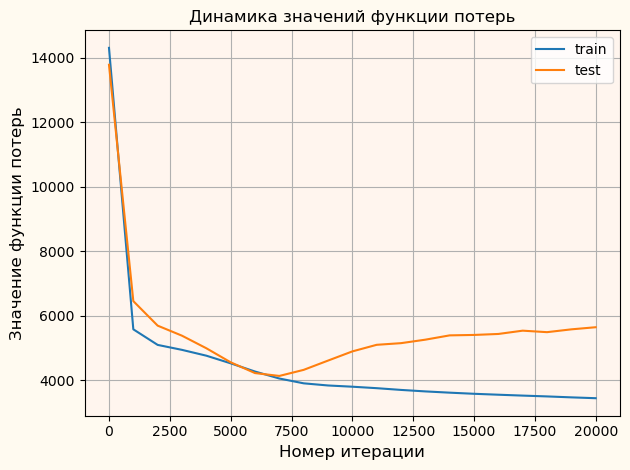

RMSE_test = 13784.76953125, RMSE_train = 14309.8896484375, RMSE_MIN_TEST = 13784.76953125, epoch = 0
RMSE_test = 6312.27001953125, RMSE_train = 5474.759765625, RMSE_MIN_TEST = 6312.27001953125, epoch = 1000
RMSE_test = 5689.56982421875, RMSE_train = 5093.3798828125, RMSE_MIN_TEST = 5689.56982421875, epoch = 2000
RMSE_test = 5493.4599609375, RMSE_train = 4991.97021484375, RMSE_MIN_TEST = 5490.1298828125, epoch = 3000
RMSE_test = 5258.64990234375, RMSE_train = 4896.16015625, RMSE_MIN_TEST = 5258.18017578125, epoch = 4000
RMSE_test = 5029.1298828125, RMSE_train = 4799.89990234375, RMSE_MIN_TEST = 5029.1298828125, epoch = 5000
RMSE_test = 4778.68994140625, RMSE_train = 4686.60986328125, RMSE_MIN_TEST = 4778.68994140625, epoch = 6000
RMSE_test = 4524.33984375, RMSE_train = 4546.169921875, RMSE_MIN_TEST = 4524.33984375, epoch = 7000
RMSE_test = 4339.1298828125, RMSE_train = 4414.9501953125, RMSE_MIN_TEST = 4338.419921875, epoch = 8000
RMSE_test = 4236.22021484375, RMSE_train = 4279.720214843

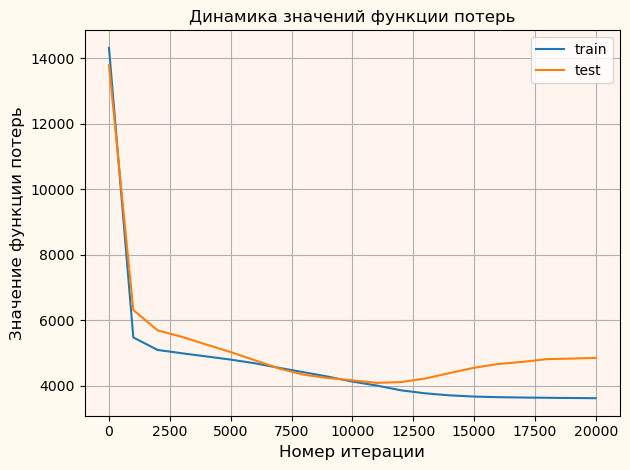

RMSE_test = 13783.7197265625, RMSE_train = 14308.8603515625, RMSE_MIN_TEST = 13783.7197265625, epoch = 0
RMSE_test = 6288.72998046875, RMSE_train = 5450.39990234375, RMSE_MIN_TEST = 6288.72998046875, epoch = 1000
RMSE_test = 5690.009765625, RMSE_train = 5098.9501953125, RMSE_MIN_TEST = 5689.0498046875, epoch = 2000
RMSE_test = 5501.02978515625, RMSE_train = 5000.68994140625, RMSE_MIN_TEST = 5500.2998046875, epoch = 3000
RMSE_test = 5311.0498046875, RMSE_train = 4924.080078125, RMSE_MIN_TEST = 5306.580078125, epoch = 4000
RMSE_test = 5090.1298828125, RMSE_train = 4837.72998046875, RMSE_MIN_TEST = 5090.1298828125, epoch = 5000
RMSE_test = 4811.41015625, RMSE_train = 4731.72021484375, RMSE_MIN_TEST = 4811.41015625, epoch = 6000
RMSE_test = 4522.52978515625, RMSE_train = 4625.5498046875, RMSE_MIN_TEST = 4522.52978515625, epoch = 7000
RMSE_test = 4277.39990234375, RMSE_train = 4529.509765625, RMSE_MIN_TEST = 4277.39990234375, epoch = 8000
RMSE_test = 4080.56005859375, RMSE_train = 4443.9702

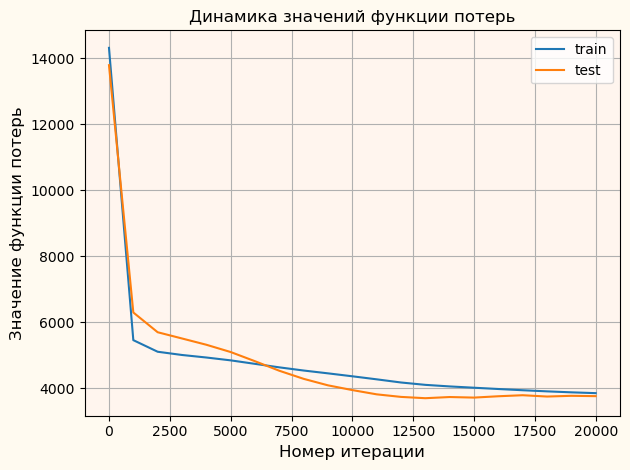

RMSE_test = 13783.25, RMSE_train = 14308.41015625, RMSE_MIN_TEST = 13783.25, epoch = 0
RMSE_test = 6298.75, RMSE_train = 5471.02978515625, RMSE_MIN_TEST = 6298.75, epoch = 1000
RMSE_test = 5687.72021484375, RMSE_train = 5097.08984375, RMSE_MIN_TEST = 5687.72021484375, epoch = 2000
RMSE_test = 5514.31982421875, RMSE_train = 5003.68017578125, RMSE_MIN_TEST = 5512.72998046875, epoch = 3000
RMSE_test = 5358.7998046875, RMSE_train = 4937.52001953125, RMSE_MIN_TEST = 5357.580078125, epoch = 4000
RMSE_test = 5204.330078125, RMSE_train = 4866.509765625, RMSE_MIN_TEST = 5203.83984375, epoch = 5000
RMSE_test = 5012.3798828125, RMSE_train = 4765.5400390625, RMSE_MIN_TEST = 5012.3798828125, epoch = 6000
RMSE_test = 4760.259765625, RMSE_train = 4633.580078125, RMSE_MIN_TEST = 4760.259765625, epoch = 7000
RMSE_test = 4512.06982421875, RMSE_train = 4507.83984375, RMSE_MIN_TEST = 4512.06982421875, epoch = 8000
RMSE_test = 4346.2900390625, RMSE_train = 4387.080078125, RMSE_MIN_TEST = 4345.31005859375, 

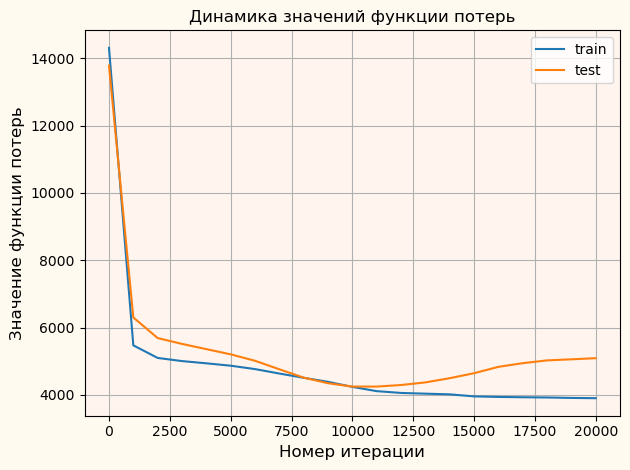

RMSE_test = 13783.3603515625, RMSE_train = 14308.41015625, RMSE_MIN_TEST = 13783.3603515625, epoch = 0
RMSE_test = 6341.52978515625, RMSE_train = 5490.419921875, RMSE_MIN_TEST = 6341.52978515625, epoch = 1000
RMSE_test = 5705.41015625, RMSE_train = 5108.16015625, RMSE_MIN_TEST = 5705.41015625, epoch = 2000
RMSE_test = 5504.2900390625, RMSE_train = 5001.14013671875, RMSE_MIN_TEST = 5504.0400390625, epoch = 3000
RMSE_test = 5322.759765625, RMSE_train = 4925.6298828125, RMSE_MIN_TEST = 5322.5498046875, epoch = 4000
RMSE_test = 5161.39013671875, RMSE_train = 4862.580078125, RMSE_MIN_TEST = 5161.39013671875, epoch = 5000
RMSE_test = 5028.52978515625, RMSE_train = 4810.33984375, RMSE_MIN_TEST = 5028.41015625, epoch = 6000
RMSE_test = 4890.240234375, RMSE_train = 4752.2998046875, RMSE_MIN_TEST = 4890.240234375, epoch = 7000
RMSE_test = 4753.43017578125, RMSE_train = 4684.7998046875, RMSE_MIN_TEST = 4753.43017578125, epoch = 8000
RMSE_test = 4622.419921875, RMSE_train = 4624.85986328125, RMSE_

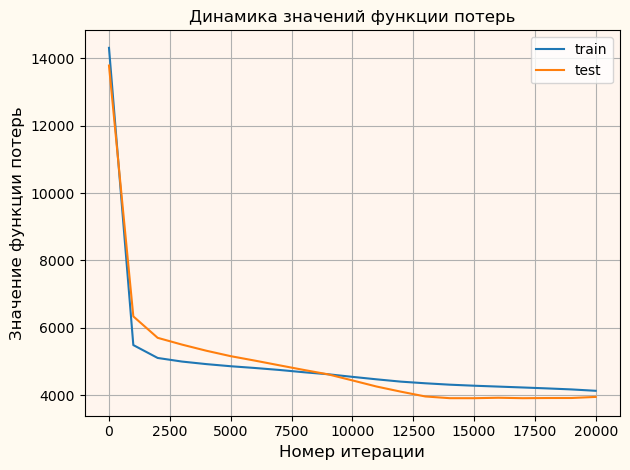

RMSE_test = 13784.9501953125, RMSE_train = 14309.8798828125, RMSE_MIN_TEST = 13784.9501953125, epoch = 0
RMSE_test = 6393.919921875, RMSE_train = 5527.169921875, RMSE_MIN_TEST = 6393.919921875, epoch = 1000
RMSE_test = 5719.27001953125, RMSE_train = 5110.64013671875, RMSE_MIN_TEST = 5716.8701171875, epoch = 2000
RMSE_test = 5545.14990234375, RMSE_train = 5023.18994140625, RMSE_MIN_TEST = 5545.14990234375, epoch = 3000
RMSE_test = 5392.22998046875, RMSE_train = 4946.25, RMSE_MIN_TEST = 5391.75, epoch = 4000
RMSE_test = 5158.1298828125, RMSE_train = 4837.81982421875, RMSE_MIN_TEST = 5158.06005859375, epoch = 5000
RMSE_test = 4896.47021484375, RMSE_train = 4718.18994140625, RMSE_MIN_TEST = 4896.47021484375, epoch = 6000
RMSE_test = 4686.60009765625, RMSE_train = 4615.25, RMSE_MIN_TEST = 4683.68994140625, epoch = 7000
RMSE_test = 4543.0400390625, RMSE_train = 4503.10986328125, RMSE_MIN_TEST = 4541.56982421875, epoch = 8000
RMSE_test = 4444.759765625, RMSE_train = 4376.740234375, RMSE_MIN_T

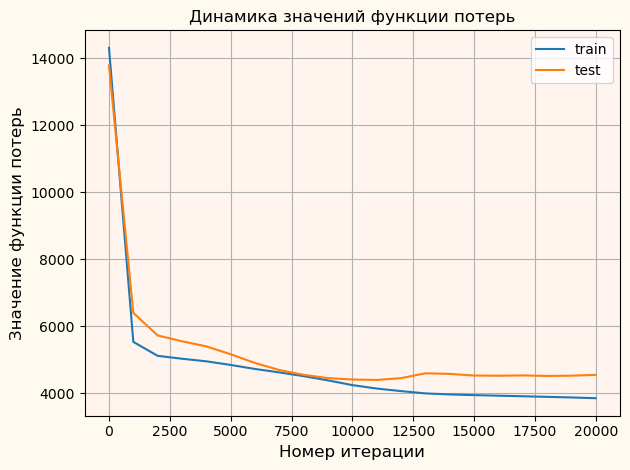

RMSE_test = 13785.990234375, RMSE_train = 14310.9697265625, RMSE_MIN_TEST = 13785.990234375, epoch = 0
RMSE_test = 6486.0400390625, RMSE_train = 5592.64990234375, RMSE_MIN_TEST = 6486.0400390625, epoch = 1000
RMSE_test = 5751.93017578125, RMSE_train = 5153.58984375, RMSE_MIN_TEST = 5751.93017578125, epoch = 2000
RMSE_test = 5560.509765625, RMSE_train = 5053.4501953125, RMSE_MIN_TEST = 5560.509765625, epoch = 3000
RMSE_test = 5435.35986328125, RMSE_train = 4993.85986328125, RMSE_MIN_TEST = 5434.68994140625, epoch = 4000
RMSE_test = 5344.39990234375, RMSE_train = 4950.2998046875, RMSE_MIN_TEST = 5344.39990234375, epoch = 5000
RMSE_test = 5251.97998046875, RMSE_train = 4912.9599609375, RMSE_MIN_TEST = 5251.97998046875, epoch = 6000
RMSE_test = 5175.7001953125, RMSE_train = 4881.06005859375, RMSE_MIN_TEST = 5175.7001953125, epoch = 7000
RMSE_test = 5034.81982421875, RMSE_train = 4816.25, RMSE_MIN_TEST = 5034.81982421875, epoch = 8000
RMSE_test = 4810.919921875, RMSE_train = 4720.3198242187

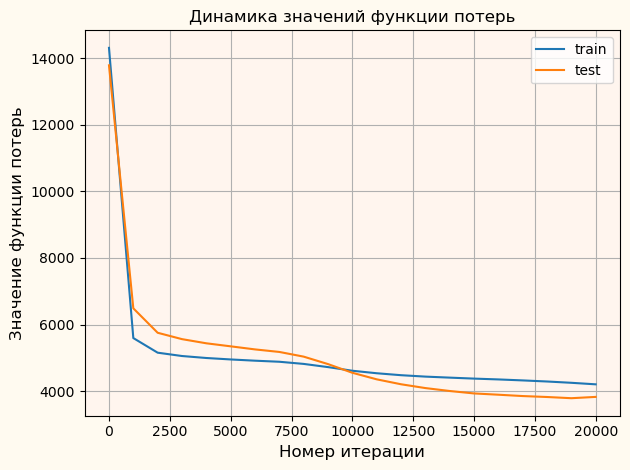

RMSE_test = 13785.4599609375, RMSE_train = 14310.419921875, RMSE_MIN_TEST = 13785.4599609375, epoch = 0
RMSE_test = 6300.64013671875, RMSE_train = 5460.75, RMSE_MIN_TEST = 6300.64013671875, epoch = 1000
RMSE_test = 5705.4501953125, RMSE_train = 5102.56982421875, RMSE_MIN_TEST = 5705.41015625, epoch = 2000
RMSE_test = 5465.7099609375, RMSE_train = 4986.33984375, RMSE_MIN_TEST = 5465.009765625, epoch = 3000
RMSE_test = 5264.93994140625, RMSE_train = 4900.1201171875, RMSE_MIN_TEST = 5264.93994140625, epoch = 4000
RMSE_test = 5055.97021484375, RMSE_train = 4815.7099609375, RMSE_MIN_TEST = 5055.97021484375, epoch = 5000
RMSE_test = 4845.9501953125, RMSE_train = 4728.60986328125, RMSE_MIN_TEST = 4845.9501953125, epoch = 6000
RMSE_test = 4642.7001953125, RMSE_train = 4627.10986328125, RMSE_MIN_TEST = 4639.31982421875, epoch = 7000
RMSE_test = 4432.16015625, RMSE_train = 4509.43017578125, RMSE_MIN_TEST = 4429.89990234375, epoch = 8000
RMSE_test = 4255.81005859375, RMSE_train = 4395.60009765625

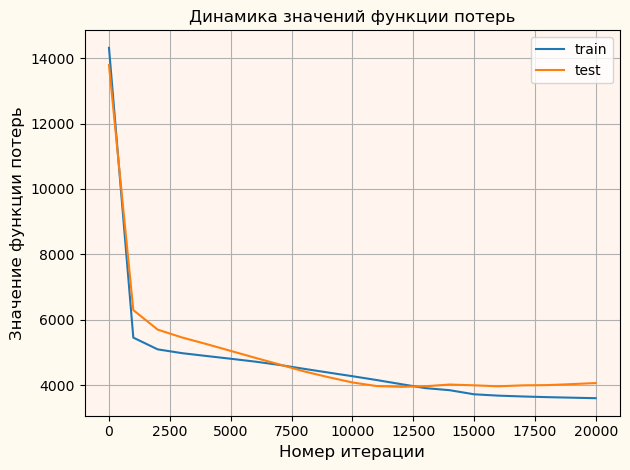

RMSE_test = 13784.0400390625, RMSE_train = 14308.990234375, RMSE_MIN_TEST = 13784.0400390625, epoch = 0
RMSE_test = 6497.27001953125, RMSE_train = 5619.06982421875, RMSE_MIN_TEST = 6497.27001953125, epoch = 1000
RMSE_test = 5724.169921875, RMSE_train = 5115.27978515625, RMSE_MIN_TEST = 5724.169921875, epoch = 2000
RMSE_test = 5533.7099609375, RMSE_train = 5016.41015625, RMSE_MIN_TEST = 5532.4599609375, epoch = 3000
RMSE_test = 5365.39013671875, RMSE_train = 4936.27001953125, RMSE_MIN_TEST = 5365.33984375, epoch = 4000
RMSE_test = 5156.66015625, RMSE_train = 4838.18994140625, RMSE_MIN_TEST = 5156.47021484375, epoch = 5000
RMSE_test = 4768.14990234375, RMSE_train = 4668.1298828125, RMSE_MIN_TEST = 4768.14990234375, epoch = 6000
RMSE_test = 4491.669921875, RMSE_train = 4515.669921875, RMSE_MIN_TEST = 4491.27978515625, epoch = 7000
RMSE_test = 4329.77978515625, RMSE_train = 4363.47998046875, RMSE_MIN_TEST = 4328.93994140625, epoch = 8000
RMSE_test = 4122.7001953125, RMSE_train = 4183.0, RM

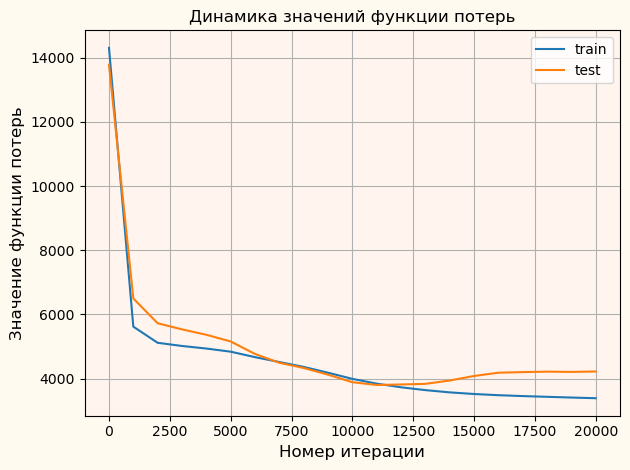

RMSE_test = 13783.8095703125, RMSE_train = 14308.8896484375, RMSE_MIN_TEST = 13783.8095703125, epoch = 0
RMSE_test = 6323.509765625, RMSE_train = 5478.9599609375, RMSE_MIN_TEST = 6323.509765625, epoch = 1000
RMSE_test = 5706.41015625, RMSE_train = 5111.93017578125, RMSE_MIN_TEST = 5705.7099609375, epoch = 2000
RMSE_test = 5491.16015625, RMSE_train = 4994.64013671875, RMSE_MIN_TEST = 5491.16015625, epoch = 3000
RMSE_test = 5242.72021484375, RMSE_train = 4900.06982421875, RMSE_MIN_TEST = 5242.72021484375, epoch = 4000
RMSE_test = 4991.02001953125, RMSE_train = 4815.9599609375, RMSE_MIN_TEST = 4990.47021484375, epoch = 5000
RMSE_test = 4839.60009765625, RMSE_train = 4739.1298828125, RMSE_MIN_TEST = 4835.0, epoch = 6000
RMSE_test = 4658.52978515625, RMSE_train = 4601.91015625, RMSE_MIN_TEST = 4657.77978515625, epoch = 7000
RMSE_test = 4525.580078125, RMSE_train = 4497.3798828125, RMSE_MIN_TEST = 4525.580078125, epoch = 8000
RMSE_test = 4428.56005859375, RMSE_train = 4388.68994140625, RMSE_

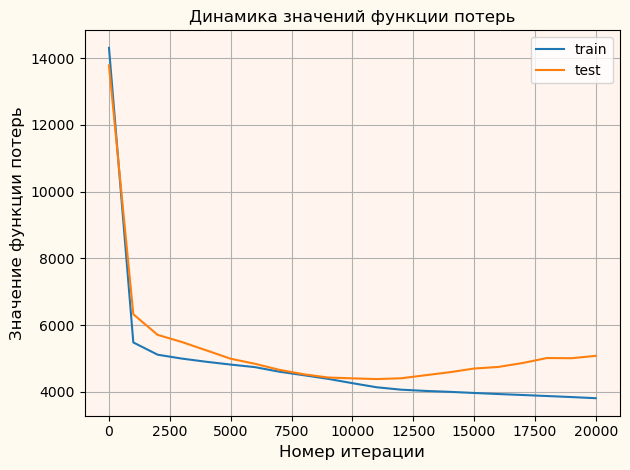

RMSE_test = 13783.7802734375, RMSE_train = 14309.1298828125, RMSE_MIN_TEST = 13783.7802734375, epoch = 0
RMSE_test = 6290.64990234375, RMSE_train = 5455.64990234375, RMSE_MIN_TEST = 6290.64990234375, epoch = 1000
RMSE_test = 5701.47998046875, RMSE_train = 5097.419921875, RMSE_MIN_TEST = 5700.77001953125, epoch = 2000
RMSE_test = 5514.43017578125, RMSE_train = 5011.419921875, RMSE_MIN_TEST = 5514.18017578125, epoch = 3000
RMSE_test = 5283.60009765625, RMSE_train = 4920.89013671875, RMSE_MIN_TEST = 5283.60009765625, epoch = 4000
RMSE_test = 5035.91015625, RMSE_train = 4828.2998046875, RMSE_MIN_TEST = 5035.91015625, epoch = 5000
RMSE_test = 4795.89013671875, RMSE_train = 4740.009765625, RMSE_MIN_TEST = 4795.89013671875, epoch = 6000
RMSE_test = 4576.22998046875, RMSE_train = 4657.77978515625, RMSE_MIN_TEST = 4576.22998046875, epoch = 7000
RMSE_test = 4390.93017578125, RMSE_train = 4580.10009765625, RMSE_MIN_TEST = 4390.93017578125, epoch = 8000
RMSE_test = 4197.72021484375, RMSE_train = 4

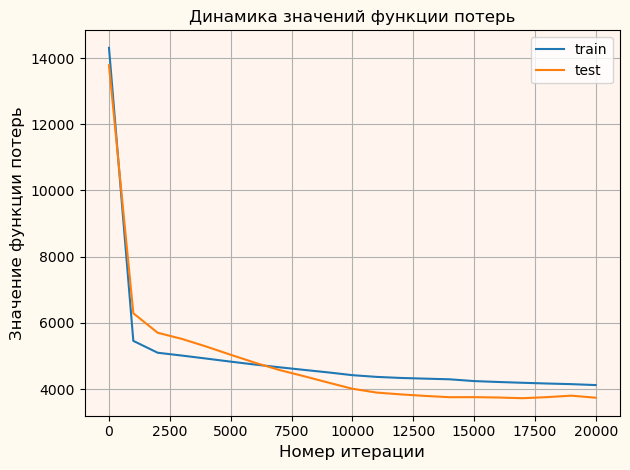

RMSE_test = 13786.1201171875, RMSE_train = 14311.0400390625, RMSE_MIN_TEST = 13786.1201171875, epoch = 0
RMSE_test = 6357.64990234375, RMSE_train = 5508.169921875, RMSE_MIN_TEST = 6357.64990234375, epoch = 1000
RMSE_test = 5668.5498046875, RMSE_train = 5090.35986328125, RMSE_MIN_TEST = 5668.5498046875, epoch = 2000
RMSE_test = 5417.72998046875, RMSE_train = 4960.31005859375, RMSE_MIN_TEST = 5416.43994140625, epoch = 3000
RMSE_test = 5122.91015625, RMSE_train = 4833.9599609375, RMSE_MIN_TEST = 5122.830078125, epoch = 4000
RMSE_test = 4824.8701171875, RMSE_train = 4717.10009765625, RMSE_MIN_TEST = 4824.8701171875, epoch = 5000
RMSE_test = 4610.7099609375, RMSE_train = 4602.18017578125, RMSE_MIN_TEST = 4610.7001953125, epoch = 6000
RMSE_test = 4440.52001953125, RMSE_train = 4476.02978515625, RMSE_MIN_TEST = 4440.3798828125, epoch = 7000
RMSE_test = 4267.77001953125, RMSE_train = 4329.83984375, RMSE_MIN_TEST = 4267.77001953125, epoch = 8000
RMSE_test = 4005.719970703125, RMSE_train = 4127.

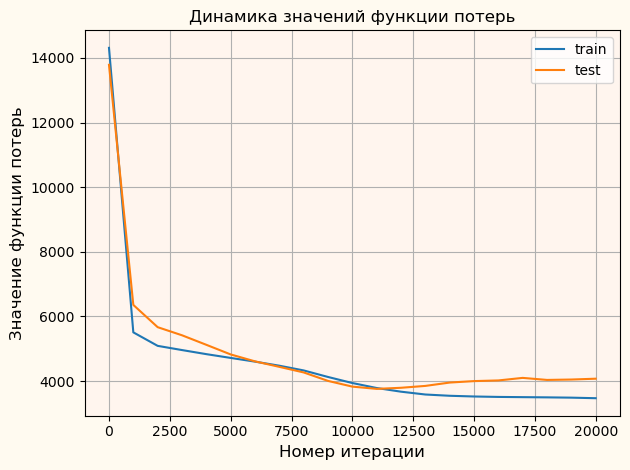

RMSE_test = 13783.1201171875, RMSE_train = 14308.25, RMSE_MIN_TEST = 13783.1201171875, epoch = 0
RMSE_test = 6185.77978515625, RMSE_train = 5387.35986328125, RMSE_MIN_TEST = 6185.77978515625, epoch = 1000
RMSE_test = 5682.60986328125, RMSE_train = 5084.68017578125, RMSE_MIN_TEST = 5680.56982421875, epoch = 2000
RMSE_test = 5460.8798828125, RMSE_train = 4979.419921875, RMSE_MIN_TEST = 5460.68017578125, epoch = 3000
RMSE_test = 5237.06982421875, RMSE_train = 4880.06982421875, RMSE_MIN_TEST = 5237.06982421875, epoch = 4000
RMSE_test = 4976.83984375, RMSE_train = 4772.75, RMSE_MIN_TEST = 4976.83984375, epoch = 5000
RMSE_test = 4735.2998046875, RMSE_train = 4652.759765625, RMSE_MIN_TEST = 4735.2998046875, epoch = 6000
RMSE_test = 4505.2998046875, RMSE_train = 4521.81005859375, RMSE_MIN_TEST = 4505.2998046875, epoch = 7000
RMSE_test = 4341.330078125, RMSE_train = 4407.43017578125, RMSE_MIN_TEST = 4334.47021484375, epoch = 8000
RMSE_test = 4242.830078125, RMSE_train = 4295.97021484375, RMSE_M

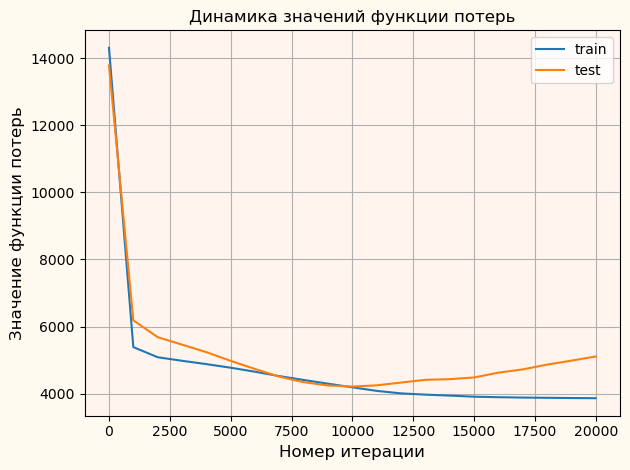

RMSE_test = 13783.98046875, RMSE_train = 14308.98046875, RMSE_MIN_TEST = 13783.98046875, epoch = 0
RMSE_test = 6374.14990234375, RMSE_train = 5511.72021484375, RMSE_MIN_TEST = 6374.14990234375, epoch = 1000
RMSE_test = 5715.5400390625, RMSE_train = 5104.31005859375, RMSE_MIN_TEST = 5715.5400390625, epoch = 2000
RMSE_test = 5516.9501953125, RMSE_train = 5004.31005859375, RMSE_MIN_TEST = 5516.4501953125, epoch = 3000
RMSE_test = 5297.52001953125, RMSE_train = 4913.509765625, RMSE_MIN_TEST = 5297.52001953125, epoch = 4000
RMSE_test = 5034.490234375, RMSE_train = 4809.91015625, RMSE_MIN_TEST = 5034.490234375, epoch = 5000
RMSE_test = 4756.6201171875, RMSE_train = 4707.580078125, RMSE_MIN_TEST = 4756.6201171875, epoch = 6000
RMSE_test = 4525.77001953125, RMSE_train = 4608.08984375, RMSE_MIN_TEST = 4524.580078125, epoch = 7000
RMSE_test = 4336.97998046875, RMSE_train = 4504.97998046875, RMSE_MIN_TEST = 4336.1298828125, epoch = 8000
RMSE_test = 4200.580078125, RMSE_train = 4409.47021484375, R

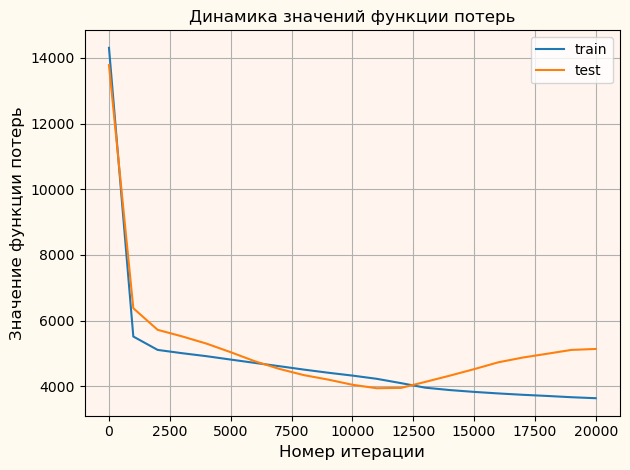

RMSE_test = 13784.7802734375, RMSE_train = 14309.8896484375, RMSE_MIN_TEST = 13784.7802734375, epoch = 0
RMSE_test = 6327.18017578125, RMSE_train = 5492.66015625, RMSE_MIN_TEST = 6327.18017578125, epoch = 1000
RMSE_test = 5696.240234375, RMSE_train = 5102.47998046875, RMSE_MIN_TEST = 5696.240234375, epoch = 2000
RMSE_test = 5530.740234375, RMSE_train = 5013.2001953125, RMSE_MIN_TEST = 5530.740234375, epoch = 3000
RMSE_test = 5392.240234375, RMSE_train = 4946.5498046875, RMSE_MIN_TEST = 5392.10009765625, epoch = 4000
RMSE_test = 5228.06005859375, RMSE_train = 4869.89013671875, RMSE_MIN_TEST = 5226.14013671875, epoch = 5000
RMSE_test = 5008.35986328125, RMSE_train = 4768.66015625, RMSE_MIN_TEST = 5008.35986328125, epoch = 6000
RMSE_test = 4773.740234375, RMSE_train = 4651.33984375, RMSE_MIN_TEST = 4773.39013671875, epoch = 7000
RMSE_test = 4542.18994140625, RMSE_train = 4536.259765625, RMSE_MIN_TEST = 4542.18994140625, epoch = 8000
RMSE_test = 4375.89013671875, RMSE_train = 4434.10986328

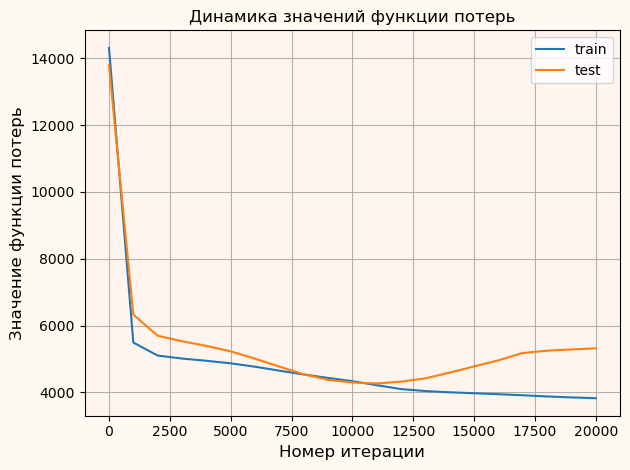

RMSE_test = 13783.169921875, RMSE_train = 14308.3603515625, RMSE_MIN_TEST = 13783.169921875, epoch = 0
RMSE_test = 6390.2900390625, RMSE_train = 5516.43994140625, RMSE_MIN_TEST = 6390.2900390625, epoch = 1000
RMSE_test = 5711.35009765625, RMSE_train = 5103.740234375, RMSE_MIN_TEST = 5710.47998046875, epoch = 2000
RMSE_test = 5519.14013671875, RMSE_train = 5008.10009765625, RMSE_MIN_TEST = 5519.14013671875, epoch = 3000
RMSE_test = 5331.7001953125, RMSE_train = 4924.830078125, RMSE_MIN_TEST = 5331.509765625, epoch = 4000
RMSE_test = 5063.39013671875, RMSE_train = 4808.830078125, RMSE_MIN_TEST = 5063.39013671875, epoch = 5000
RMSE_test = 4714.830078125, RMSE_train = 4650.169921875, RMSE_MIN_TEST = 4714.419921875, epoch = 6000
RMSE_test = 4382.60009765625, RMSE_train = 4461.22998046875, RMSE_MIN_TEST = 4379.8798828125, epoch = 7000
RMSE_test = 4273.0, RMSE_train = 4202.580078125, RMSE_MIN_TEST = 4248.93994140625, epoch = 8000
RMSE_test = 4067.090087890625, RMSE_train = 3960.320068359375, 

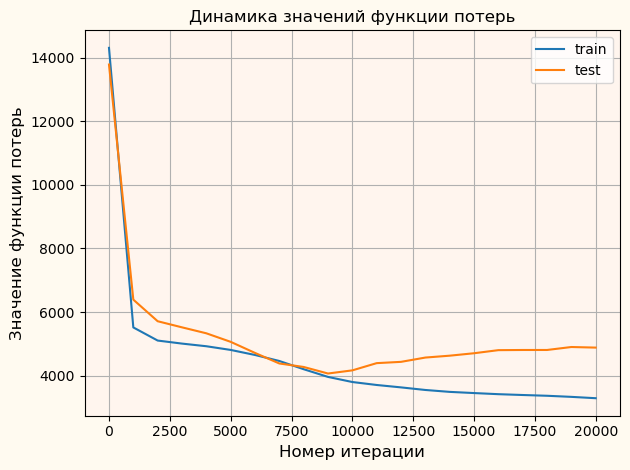

RMSE_test = 13784.6103515625, RMSE_train = 14309.7197265625, RMSE_MIN_TEST = 13784.6103515625, epoch = 0
RMSE_test = 6455.47998046875, RMSE_train = 5588.759765625, RMSE_MIN_TEST = 6455.47998046875, epoch = 1000
RMSE_test = 5713.3798828125, RMSE_train = 5132.31982421875, RMSE_MIN_TEST = 5713.31982421875, epoch = 2000
RMSE_test = 5501.669921875, RMSE_train = 5015.580078125, RMSE_MIN_TEST = 5501.16015625, epoch = 3000
RMSE_test = 5279.5400390625, RMSE_train = 4907.9501953125, RMSE_MIN_TEST = 5279.08984375, epoch = 4000
RMSE_test = 5035.669921875, RMSE_train = 4766.669921875, RMSE_MIN_TEST = 5035.669921875, epoch = 5000
RMSE_test = 4694.81982421875, RMSE_train = 4597.56982421875, RMSE_MIN_TEST = 4694.81982421875, epoch = 6000
RMSE_test = 4340.7900390625, RMSE_train = 4405.0498046875, RMSE_MIN_TEST = 4334.14990234375, epoch = 7000
RMSE_test = 4125.509765625, RMSE_train = 4214.85009765625, RMSE_MIN_TEST = 4109.31982421875, epoch = 8000
RMSE_test = 4148.759765625, RMSE_train = 4065.6201171875

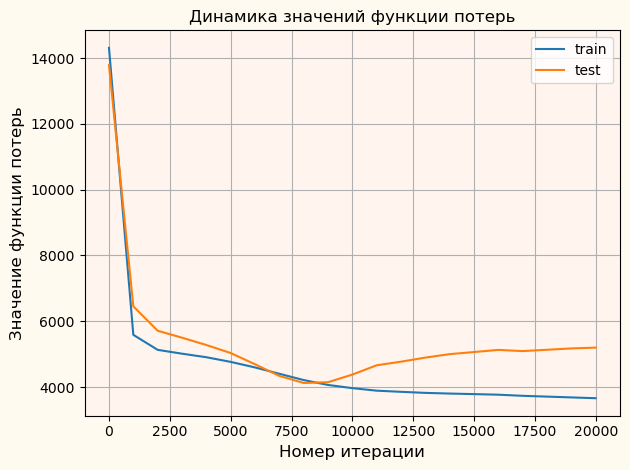

RMSE_test = 13786.740234375, RMSE_train = 14311.48046875, RMSE_MIN_TEST = 13786.740234375, epoch = 0
RMSE_test = 6292.0400390625, RMSE_train = 5465.75, RMSE_MIN_TEST = 6292.0400390625, epoch = 1000
RMSE_test = 5685.06005859375, RMSE_train = 5095.64990234375, RMSE_MIN_TEST = 5684.0498046875, epoch = 2000
RMSE_test = 5514.85986328125, RMSE_train = 5008.240234375, RMSE_MIN_TEST = 5512.75, epoch = 3000
RMSE_test = 5382.5400390625, RMSE_train = 4952.240234375, RMSE_MIN_TEST = 5381.7099609375, epoch = 4000
RMSE_test = 5255.93017578125, RMSE_train = 4890.72998046875, RMSE_MIN_TEST = 5255.4501953125, epoch = 5000
RMSE_test = 5060.14013671875, RMSE_train = 4802.419921875, RMSE_MIN_TEST = 5060.14013671875, epoch = 6000
RMSE_test = 4818.43017578125, RMSE_train = 4677.35986328125, RMSE_MIN_TEST = 4818.43017578125, epoch = 7000
RMSE_test = 4541.7900390625, RMSE_train = 4524.22021484375, RMSE_MIN_TEST = 4541.7900390625, epoch = 8000
RMSE_test = 4336.7998046875, RMSE_train = 4374.47021484375, RMSE_MI

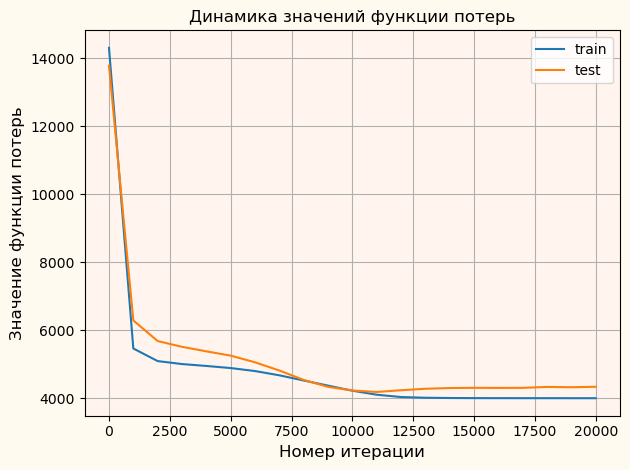

RMSE_test = 13784.91015625, RMSE_train = 14309.7900390625, RMSE_MIN_TEST = 13784.91015625, epoch = 0
RMSE_test = 6413.330078125, RMSE_train = 5544.39990234375, RMSE_MIN_TEST = 6413.330078125, epoch = 1000
RMSE_test = 5706.5, RMSE_train = 5102.39013671875, RMSE_MIN_TEST = 5706.5, epoch = 2000
RMSE_test = 5496.8798828125, RMSE_train = 4996.68017578125, RMSE_MIN_TEST = 5494.4599609375, epoch = 3000
RMSE_test = 5275.66015625, RMSE_train = 4898.16015625, RMSE_MIN_TEST = 5275.66015625, epoch = 4000
RMSE_test = 5038.8701171875, RMSE_train = 4797.490234375, RMSE_MIN_TEST = 5038.8701171875, epoch = 5000
RMSE_test = 4821.47998046875, RMSE_train = 4698.759765625, RMSE_MIN_TEST = 4821.47998046875, epoch = 6000
RMSE_test = 4629.58984375, RMSE_train = 4589.41015625, RMSE_MIN_TEST = 4628.4501953125, epoch = 7000
RMSE_test = 4462.3701171875, RMSE_train = 4473.5400390625, RMSE_MIN_TEST = 4459.83984375, epoch = 8000
RMSE_test = 4331.33984375, RMSE_train = 4347.35009765625, RMSE_MIN_TEST = 4331.33984375,

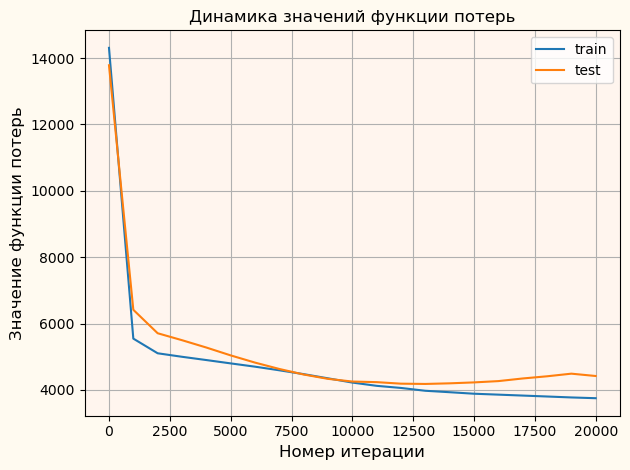

RMSE_test = 13784.3798828125, RMSE_train = 14309.3603515625, RMSE_MIN_TEST = 13784.3798828125, epoch = 0
RMSE_test = 6280.52978515625, RMSE_train = 5458.669921875, RMSE_MIN_TEST = 6280.52978515625, epoch = 1000
RMSE_test = 5676.419921875, RMSE_train = 5098.580078125, RMSE_MIN_TEST = 5673.9599609375, epoch = 2000
RMSE_test = 5483.22021484375, RMSE_train = 4991.919921875, RMSE_MIN_TEST = 5482.5400390625, epoch = 3000
RMSE_test = 5306.0400390625, RMSE_train = 4906.52978515625, RMSE_MIN_TEST = 5305.7998046875, epoch = 4000
RMSE_test = 5105.22998046875, RMSE_train = 4804.39990234375, RMSE_MIN_TEST = 5105.22998046875, epoch = 5000
RMSE_test = 4857.0400390625, RMSE_train = 4685.3798828125, RMSE_MIN_TEST = 4856.93994140625, epoch = 6000
RMSE_test = 4646.18994140625, RMSE_train = 4562.60009765625, RMSE_MIN_TEST = 4646.18994140625, epoch = 7000
RMSE_test = 4478.419921875, RMSE_train = 4428.77001953125, RMSE_MIN_TEST = 4477.77978515625, epoch = 8000
RMSE_test = 4393.4599609375, RMSE_train = 4287.

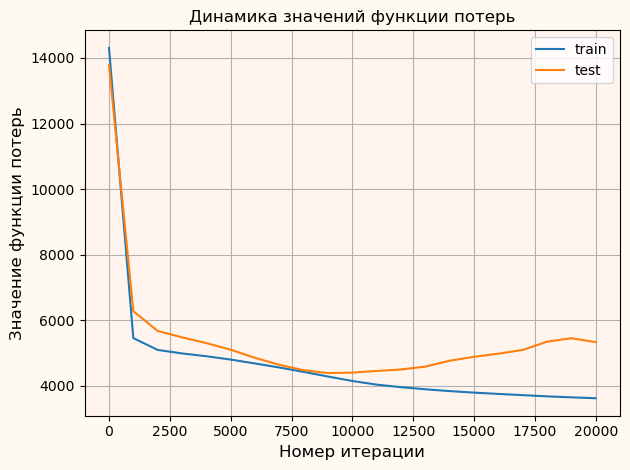

RMSE_test = 13784.5, RMSE_train = 14309.6103515625, RMSE_MIN_TEST = 13784.5, epoch = 0
RMSE_test = 6286.47998046875, RMSE_train = 5459.0498046875, RMSE_MIN_TEST = 6286.47998046875, epoch = 1000
RMSE_test = 5676.64990234375, RMSE_train = 5100.16015625, RMSE_MIN_TEST = 5675.81982421875, epoch = 2000
RMSE_test = 5465.240234375, RMSE_train = 4987.6201171875, RMSE_MIN_TEST = 5463.52001953125, epoch = 3000
RMSE_test = 5266.41015625, RMSE_train = 4899.169921875, RMSE_MIN_TEST = 5266.18017578125, epoch = 4000
RMSE_test = 5040.14013671875, RMSE_train = 4800.669921875, RMSE_MIN_TEST = 5040.14013671875, epoch = 5000
RMSE_test = 4762.009765625, RMSE_train = 4682.259765625, RMSE_MIN_TEST = 4762.009765625, epoch = 6000
RMSE_test = 4441.7998046875, RMSE_train = 4529.4599609375, RMSE_MIN_TEST = 4437.93017578125, epoch = 7000
RMSE_test = 4119.9501953125, RMSE_train = 4336.14013671875, RMSE_MIN_TEST = 4118.3798828125, epoch = 8000
RMSE_test = 3977.239990234375, RMSE_train = 4157.06982421875, RMSE_MIN_TE

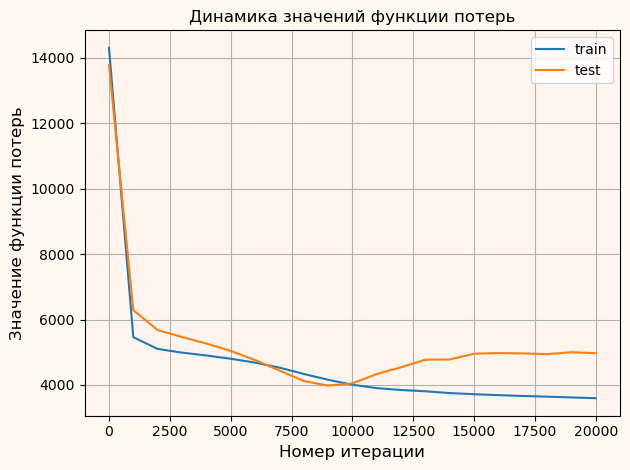

RMSE_test = 13782.5302734375, RMSE_train = 14307.8798828125, RMSE_MIN_TEST = 13782.5302734375, epoch = 0
RMSE_test = 6286.22998046875, RMSE_train = 5455.81982421875, RMSE_MIN_TEST = 6286.22998046875, epoch = 1000
RMSE_test = 5679.10986328125, RMSE_train = 5101.68017578125, RMSE_MIN_TEST = 5678.1298828125, epoch = 2000
RMSE_test = 5470.0400390625, RMSE_train = 4992.97021484375, RMSE_MIN_TEST = 5468.7001953125, epoch = 3000
RMSE_test = 5314.2099609375, RMSE_train = 4925.0400390625, RMSE_MIN_TEST = 5313.39013671875, epoch = 4000
RMSE_test = 5179.8701171875, RMSE_train = 4872.56005859375, RMSE_MIN_TEST = 5179.8701171875, epoch = 5000
RMSE_test = 5071.759765625, RMSE_train = 4832.06005859375, RMSE_MIN_TEST = 5071.759765625, epoch = 6000
RMSE_test = 4981.10009765625, RMSE_train = 4794.43994140625, RMSE_MIN_TEST = 4981.10009765625, epoch = 7000
RMSE_test = 4831.81982421875, RMSE_train = 4724.81982421875, RMSE_MIN_TEST = 4831.81982421875, epoch = 8000
RMSE_test = 4586.3701171875, RMSE_train = 

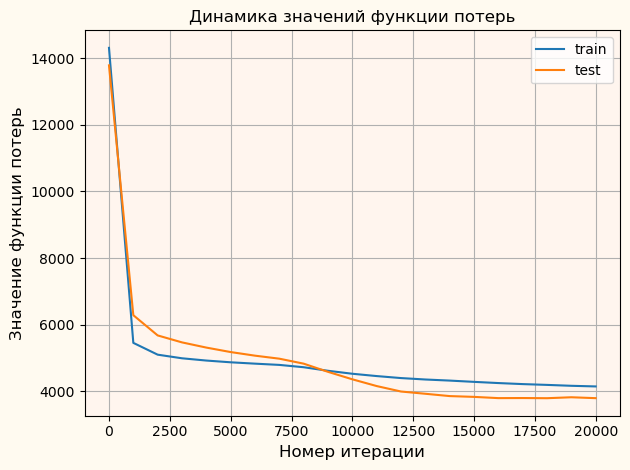

RMSE_test = 13789.75, RMSE_train = 14314.1904296875, RMSE_MIN_TEST = 13789.75, epoch = 0
RMSE_test = 6447.25, RMSE_train = 5567.0400390625, RMSE_MIN_TEST = 6447.25, epoch = 1000
RMSE_test = 5729.25, RMSE_train = 5142.91015625, RMSE_MIN_TEST = 5729.25, epoch = 2000
RMSE_test = 5537.72998046875, RMSE_train = 5041.330078125, RMSE_MIN_TEST = 5537.72998046875, epoch = 3000
RMSE_test = 5403.14013671875, RMSE_train = 4973.56005859375, RMSE_MIN_TEST = 5402.7099609375, epoch = 4000
RMSE_test = 5250.27001953125, RMSE_train = 4902.169921875, RMSE_MIN_TEST = 5249.7099609375, epoch = 5000
RMSE_test = 5050.64990234375, RMSE_train = 4805.330078125, RMSE_MIN_TEST = 5050.64990234375, epoch = 6000
RMSE_test = 4719.64013671875, RMSE_train = 4641.39013671875, RMSE_MIN_TEST = 4719.64013671875, epoch = 7000
RMSE_test = 4300.2900390625, RMSE_train = 4438.52978515625, RMSE_MIN_TEST = 4299.7998046875, epoch = 8000
RMSE_test = 4005.010009765625, RMSE_train = 4239.990234375, RMSE_MIN_TEST = 4003.31005859375, epo

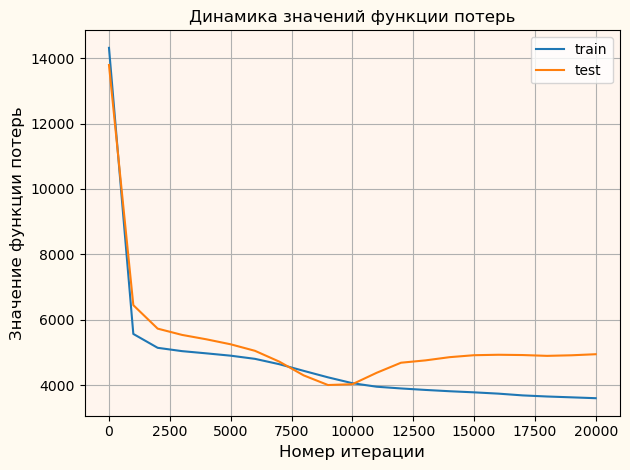

RMSE_test = 13783.7802734375, RMSE_train = 14308.73046875, RMSE_MIN_TEST = 13783.7802734375, epoch = 0
RMSE_test = 6344.22021484375, RMSE_train = 5496.72998046875, RMSE_MIN_TEST = 6344.22021484375, epoch = 1000
RMSE_test = 5688.72998046875, RMSE_train = 5098.2099609375, RMSE_MIN_TEST = 5688.72998046875, epoch = 2000
RMSE_test = 5526.06982421875, RMSE_train = 5013.4501953125, RMSE_MIN_TEST = 5524.759765625, epoch = 3000
RMSE_test = 5356.669921875, RMSE_train = 4928.85009765625, RMSE_MIN_TEST = 5356.669921875, epoch = 4000
RMSE_test = 5085.47021484375, RMSE_train = 4804.2001953125, RMSE_MIN_TEST = 5084.31982421875, epoch = 5000
RMSE_test = 4787.10986328125, RMSE_train = 4673.2001953125, RMSE_MIN_TEST = 4787.10986328125, epoch = 6000
RMSE_test = 4583.22998046875, RMSE_train = 4561.419921875, RMSE_MIN_TEST = 4583.22998046875, epoch = 7000
RMSE_test = 4441.259765625, RMSE_train = 4424.77001953125, RMSE_MIN_TEST = 4439.830078125, epoch = 8000
RMSE_test = 4291.2099609375, RMSE_train = 4278.27

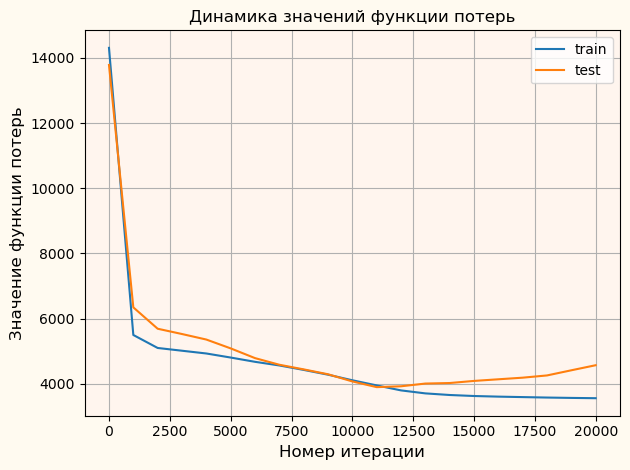

RMSE_test = 13783.66015625, RMSE_train = 14308.650390625, RMSE_MIN_TEST = 13783.66015625, epoch = 0
RMSE_test = 6465.66015625, RMSE_train = 5581.25, RMSE_MIN_TEST = 6465.66015625, epoch = 1000
RMSE_test = 5727.43017578125, RMSE_train = 5114.4501953125, RMSE_MIN_TEST = 5727.43017578125, epoch = 2000
RMSE_test = 5514.10986328125, RMSE_train = 4992.75, RMSE_MIN_TEST = 5514.10986328125, epoch = 3000
RMSE_test = 5264.830078125, RMSE_train = 4882.22021484375, RMSE_MIN_TEST = 5264.77978515625, epoch = 4000
RMSE_test = 5027.93017578125, RMSE_train = 4764.89990234375, RMSE_MIN_TEST = 5025.60009765625, epoch = 5000
RMSE_test = 4822.60986328125, RMSE_train = 4656.1298828125, RMSE_MIN_TEST = 4821.56982421875, epoch = 6000
RMSE_test = 4690.27001953125, RMSE_train = 4555.009765625, RMSE_MIN_TEST = 4689.2998046875, epoch = 7000
RMSE_test = 4595.02978515625, RMSE_train = 4447.740234375, RMSE_MIN_TEST = 4595.02978515625, epoch = 8000
RMSE_test = 4548.259765625, RMSE_train = 4339.97998046875, RMSE_MIN_T

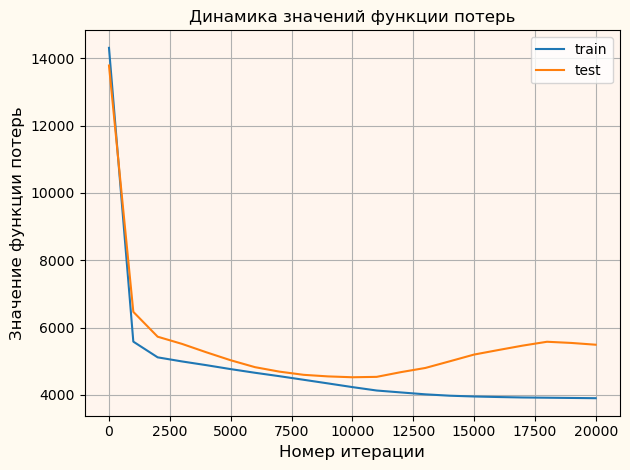

RMSE_test = 13784.5703125, RMSE_train = 14309.669921875, RMSE_MIN_TEST = 13784.5703125, epoch = 0
RMSE_test = 6443.75, RMSE_train = 5573.7099609375, RMSE_MIN_TEST = 6443.75, epoch = 1000
RMSE_test = 5730.81982421875, RMSE_train = 5128.52978515625, RMSE_MIN_TEST = 5729.8798828125, epoch = 2000
RMSE_test = 5535.10986328125, RMSE_train = 5020.2900390625, RMSE_MIN_TEST = 5533.85009765625, epoch = 3000
RMSE_test = 5364.31982421875, RMSE_train = 4945.2001953125, RMSE_MIN_TEST = 5364.31982421875, epoch = 4000
RMSE_test = 5207.64990234375, RMSE_train = 4880.919921875, RMSE_MIN_TEST = 5207.64990234375, epoch = 5000
RMSE_test = 5046.2900390625, RMSE_train = 4817.669921875, RMSE_MIN_TEST = 5046.2900390625, epoch = 6000
RMSE_test = 4882.89013671875, RMSE_train = 4742.93017578125, RMSE_MIN_TEST = 4882.89013671875, epoch = 7000
RMSE_test = 4678.85009765625, RMSE_train = 4653.89990234375, RMSE_MIN_TEST = 4678.85009765625, epoch = 8000
RMSE_test = 4485.89990234375, RMSE_train = 4545.60986328125, RMSE_

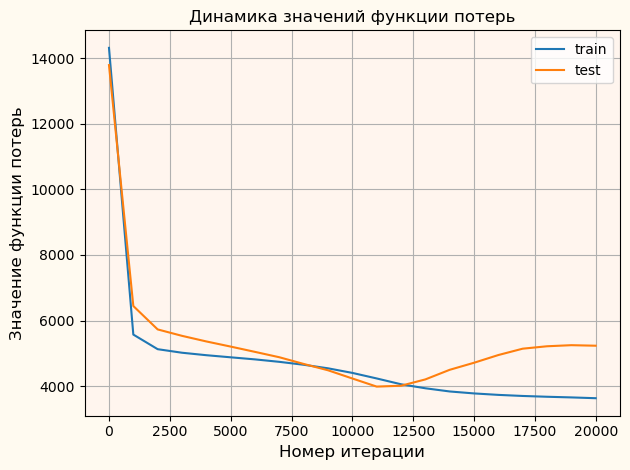

RMSE_test = 13785.1396484375, RMSE_train = 14310.2099609375, RMSE_MIN_TEST = 13785.1396484375, epoch = 0
RMSE_test = 6404.14013671875, RMSE_train = 5539.02978515625, RMSE_MIN_TEST = 6404.14013671875, epoch = 1000
RMSE_test = 5715.3798828125, RMSE_train = 5111.31982421875, RMSE_MIN_TEST = 5715.3798828125, epoch = 2000
RMSE_test = 5504.39013671875, RMSE_train = 4994.35009765625, RMSE_MIN_TEST = 5504.33984375, epoch = 3000
RMSE_test = 5277.93017578125, RMSE_train = 4887.35009765625, RMSE_MIN_TEST = 5277.259765625, epoch = 4000
RMSE_test = 5020.3701171875, RMSE_train = 4772.2998046875, RMSE_MIN_TEST = 5020.2001953125, epoch = 5000
RMSE_test = 4776.7001953125, RMSE_train = 4658.06982421875, RMSE_MIN_TEST = 4776.7001953125, epoch = 6000
RMSE_test = 4600.080078125, RMSE_train = 4540.22021484375, RMSE_MIN_TEST = 4600.080078125, epoch = 7000
RMSE_test = 4437.89990234375, RMSE_train = 4407.330078125, RMSE_MIN_TEST = 4436.47021484375, epoch = 8000
RMSE_test = 4337.47021484375, RMSE_train = 4271.7

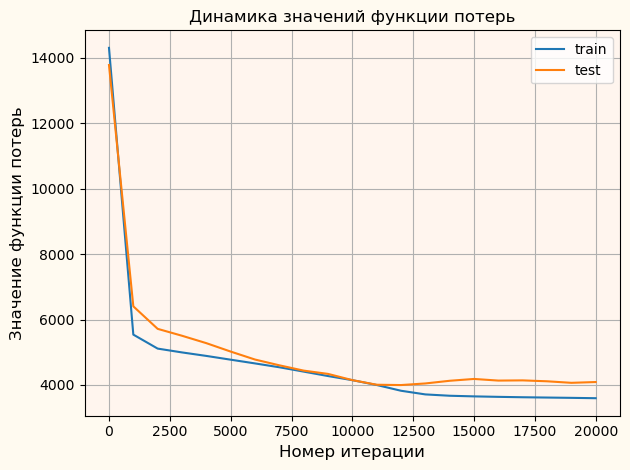

RMSE_test = 13784.3798828125, RMSE_train = 14309.419921875, RMSE_MIN_TEST = 13784.3798828125, epoch = 0
RMSE_test = 6343.52001953125, RMSE_train = 5485.6201171875, RMSE_MIN_TEST = 6343.52001953125, epoch = 1000
RMSE_test = 5714.02978515625, RMSE_train = 5112.1201171875, RMSE_MIN_TEST = 5712.759765625, epoch = 2000
RMSE_test = 5519.08984375, RMSE_train = 5009.5, RMSE_MIN_TEST = 5513.39013671875, epoch = 3000
RMSE_test = 5346.990234375, RMSE_train = 4934.7099609375, RMSE_MIN_TEST = 5346.990234375, epoch = 4000
RMSE_test = 5153.77978515625, RMSE_train = 4866.0400390625, RMSE_MIN_TEST = 5153.2900390625, epoch = 5000
RMSE_test = 4956.7001953125, RMSE_train = 4790.31005859375, RMSE_MIN_TEST = 4956.7001953125, epoch = 6000
RMSE_test = 4717.919921875, RMSE_train = 4702.259765625, RMSE_MIN_TEST = 4717.77001953125, epoch = 7000
RMSE_test = 4494.830078125, RMSE_train = 4624.56005859375, RMSE_MIN_TEST = 4494.830078125, epoch = 8000
RMSE_test = 4297.759765625, RMSE_train = 4538.89013671875, RMSE_MI

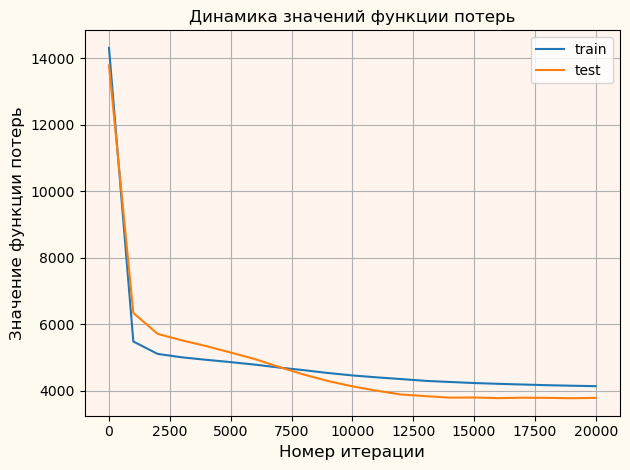

RMSE_test = 13784.490234375, RMSE_train = 14309.33984375, RMSE_MIN_TEST = 13784.490234375, epoch = 0
RMSE_test = 6331.93994140625, RMSE_train = 5494.43017578125, RMSE_MIN_TEST = 6331.93994140625, epoch = 1000
RMSE_test = 5716.64013671875, RMSE_train = 5112.009765625, RMSE_MIN_TEST = 5716.580078125, epoch = 2000
RMSE_test = 5514.06982421875, RMSE_train = 5009.2001953125, RMSE_MIN_TEST = 5512.64013671875, epoch = 3000
RMSE_test = 5360.3798828125, RMSE_train = 4943.58984375, RMSE_MIN_TEST = 5360.3798828125, epoch = 4000
RMSE_test = 5215.35986328125, RMSE_train = 4880.06982421875, RMSE_MIN_TEST = 5215.35986328125, epoch = 5000
RMSE_test = 5054.1201171875, RMSE_train = 4809.02001953125, RMSE_MIN_TEST = 5054.0498046875, epoch = 6000
RMSE_test = 4886.9599609375, RMSE_train = 4733.39990234375, RMSE_MIN_TEST = 4886.75, epoch = 7000
RMSE_test = 4669.5400390625, RMSE_train = 4636.60986328125, RMSE_MIN_TEST = 4669.47021484375, epoch = 8000
RMSE_test = 4458.75, RMSE_train = 4528.4599609375, RMSE_MI

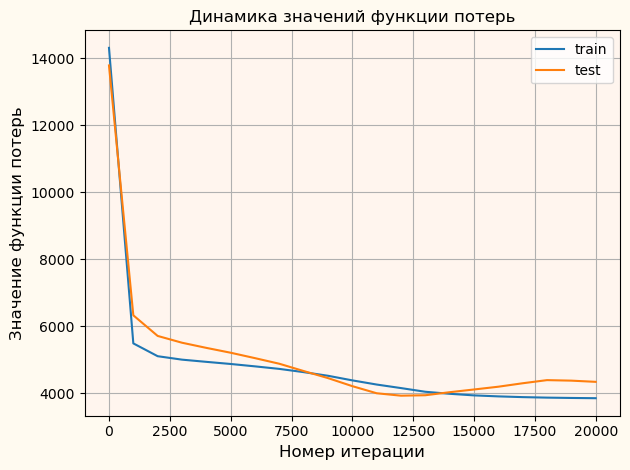

RMSE_test = 13779.91015625, RMSE_train = 14305.0595703125, RMSE_MIN_TEST = 13779.91015625, epoch = 0
RMSE_test = 6350.66015625, RMSE_train = 5500.18017578125, RMSE_MIN_TEST = 6350.66015625, epoch = 1000
RMSE_test = 5692.759765625, RMSE_train = 5109.740234375, RMSE_MIN_TEST = 5692.759765625, epoch = 2000
RMSE_test = 5479.35986328125, RMSE_train = 4998.14013671875, RMSE_MIN_TEST = 5479.35986328125, epoch = 3000
RMSE_test = 5309.43017578125, RMSE_train = 4923.72998046875, RMSE_MIN_TEST = 5309.43017578125, epoch = 4000
RMSE_test = 5155.52978515625, RMSE_train = 4860.169921875, RMSE_MIN_TEST = 5155.52978515625, epoch = 5000
RMSE_test = 4979.41015625, RMSE_train = 4781.43017578125, RMSE_MIN_TEST = 4979.41015625, epoch = 6000
RMSE_test = 4781.919921875, RMSE_train = 4687.259765625, RMSE_MIN_TEST = 4781.919921875, epoch = 7000
RMSE_test = 4557.64013671875, RMSE_train = 4563.72021484375, RMSE_MIN_TEST = 4556.60009765625, epoch = 8000
RMSE_test = 4289.43017578125, RMSE_train = 4412.18994140625, 

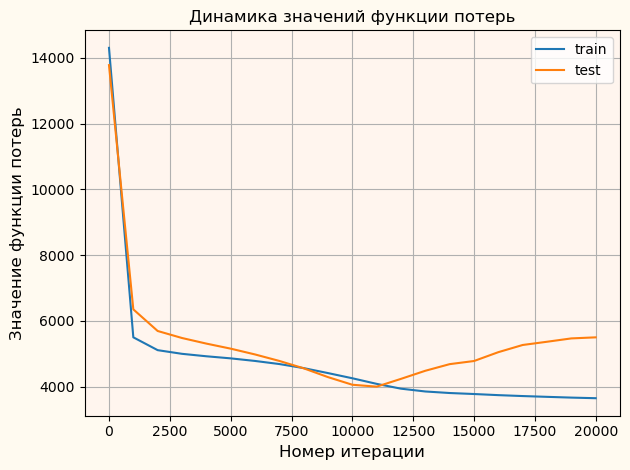

RMSE_test = 13780.9599609375, RMSE_train = 14306.3896484375, RMSE_MIN_TEST = 13780.9599609375, epoch = 0
RMSE_test = 6356.8798828125, RMSE_train = 5508.2001953125, RMSE_MIN_TEST = 6356.8798828125, epoch = 1000
RMSE_test = 5615.0498046875, RMSE_train = 5049.919921875, RMSE_MIN_TEST = 5615.0498046875, epoch = 2000
RMSE_test = 5324.16015625, RMSE_train = 4900.759765625, RMSE_MIN_TEST = 5324.16015625, epoch = 3000
RMSE_test = 5039.6201171875, RMSE_train = 4776.5400390625, RMSE_MIN_TEST = 5039.6201171875, epoch = 4000
RMSE_test = 4839.77978515625, RMSE_train = 4670.43017578125, RMSE_MIN_TEST = 4839.52978515625, epoch = 5000
RMSE_test = 4703.740234375, RMSE_train = 4568.6201171875, RMSE_MIN_TEST = 4703.740234375, epoch = 6000
RMSE_test = 4578.81982421875, RMSE_train = 4460.22998046875, RMSE_MIN_TEST = 4578.81982421875, epoch = 7000
RMSE_test = 4444.72998046875, RMSE_train = 4347.39013671875, RMSE_MIN_TEST = 4444.7099609375, epoch = 8000
RMSE_test = 4364.56982421875, RMSE_train = 4217.1899414

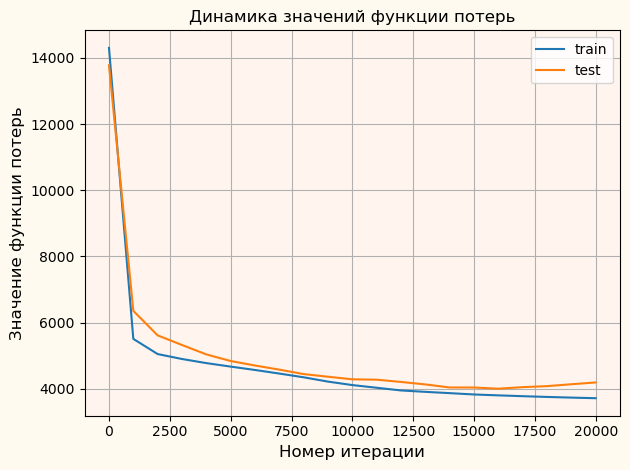

RMSE_test = 13786.58984375, RMSE_train = 14311.3701171875, RMSE_MIN_TEST = 13786.58984375, epoch = 0
RMSE_test = 6391.06982421875, RMSE_train = 5527.2099609375, RMSE_MIN_TEST = 6391.06982421875, epoch = 1000
RMSE_test = 5711.6298828125, RMSE_train = 5110.89990234375, RMSE_MIN_TEST = 5710.52001953125, epoch = 2000
RMSE_test = 5524.669921875, RMSE_train = 5010.66015625, RMSE_MIN_TEST = 5524.64013671875, epoch = 3000
RMSE_test = 5368.8798828125, RMSE_train = 4937.259765625, RMSE_MIN_TEST = 5368.0498046875, epoch = 4000
RMSE_test = 5187.2001953125, RMSE_train = 4849.919921875, RMSE_MIN_TEST = 5186.77978515625, epoch = 5000
RMSE_test = 4951.1201171875, RMSE_train = 4733.91015625, RMSE_MIN_TEST = 4951.1201171875, epoch = 6000
RMSE_test = 4707.64013671875, RMSE_train = 4612.56005859375, RMSE_MIN_TEST = 4707.64013671875, epoch = 7000
RMSE_test = 4516.27978515625, RMSE_train = 4510.759765625, RMSE_MIN_TEST = 4516.27978515625, epoch = 8000
RMSE_test = 4409.1201171875, RMSE_train = 4406.629882812

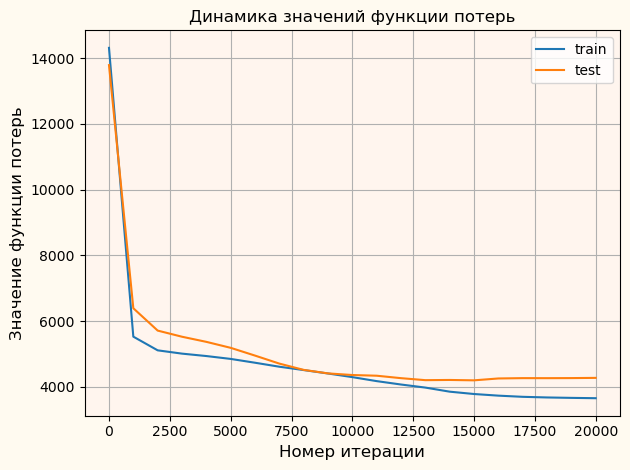

RMSE_test = 13784.23046875, RMSE_train = 14309.3095703125, RMSE_MIN_TEST = 13784.23046875, epoch = 0
RMSE_test = 6357.35009765625, RMSE_train = 5502.68994140625, RMSE_MIN_TEST = 6357.35009765625, epoch = 1000
RMSE_test = 5703.68017578125, RMSE_train = 5107.0498046875, RMSE_MIN_TEST = 5701.18017578125, epoch = 2000
RMSE_test = 5518.25, RMSE_train = 5011.509765625, RMSE_MIN_TEST = 5514.83984375, epoch = 3000
RMSE_test = 5347.5, RMSE_train = 4936.0498046875, RMSE_MIN_TEST = 5345.5, epoch = 4000
RMSE_test = 5133.7998046875, RMSE_train = 4842.990234375, RMSE_MIN_TEST = 5133.7998046875, epoch = 5000
RMSE_test = 4839.66015625, RMSE_train = 4713.60009765625, RMSE_MIN_TEST = 4839.66015625, epoch = 6000
RMSE_test = 4495.419921875, RMSE_train = 4559.39990234375, RMSE_MIN_TEST = 4495.419921875, epoch = 7000
RMSE_test = 4230.68017578125, RMSE_train = 4396.08984375, RMSE_MIN_TEST = 4225.1298828125, epoch = 8000
RMSE_test = 4050.659912109375, RMSE_train = 4237.419921875, RMSE_MIN_TEST = 4044.87988281

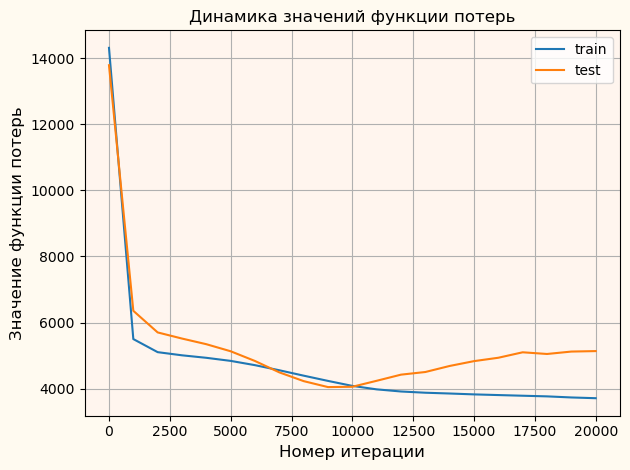

RMSE_test = 13783.6201171875, RMSE_train = 14308.66015625, RMSE_MIN_TEST = 13783.6201171875, epoch = 0
RMSE_test = 6333.8798828125, RMSE_train = 5493.41015625, RMSE_MIN_TEST = 6333.8798828125, epoch = 1000
RMSE_test = 5690.77978515625, RMSE_train = 5096.919921875, RMSE_MIN_TEST = 5690.77978515625, epoch = 2000
RMSE_test = 5489.169921875, RMSE_train = 4988.72998046875, RMSE_MIN_TEST = 5489.169921875, epoch = 3000
RMSE_test = 5254.5498046875, RMSE_train = 4872.08984375, RMSE_MIN_TEST = 5254.35986328125, epoch = 4000
RMSE_test = 4901.72998046875, RMSE_train = 4736.41015625, RMSE_MIN_TEST = 4901.14990234375, epoch = 5000
RMSE_test = 4664.7998046875, RMSE_train = 4625.1298828125, RMSE_MIN_TEST = 4664.7998046875, epoch = 6000
RMSE_test = 4523.52001953125, RMSE_train = 4513.18017578125, RMSE_MIN_TEST = 4522.83984375, epoch = 7000
RMSE_test = 4420.47021484375, RMSE_train = 4401.3798828125, RMSE_MIN_TEST = 4416.0400390625, epoch = 8000
RMSE_test = 4264.8701171875, RMSE_train = 4278.75, RMSE_MIN

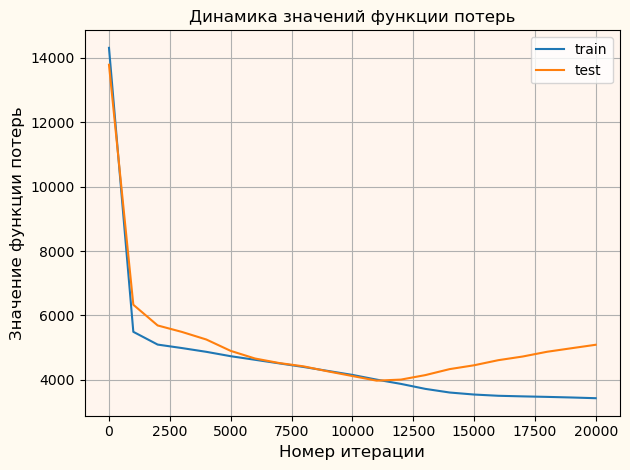

RMSE_test = 13785.2099609375, RMSE_train = 14310.2900390625, RMSE_MIN_TEST = 13785.2099609375, epoch = 0
RMSE_test = 6266.47998046875, RMSE_train = 5442.6201171875, RMSE_MIN_TEST = 6266.47998046875, epoch = 1000
RMSE_test = 5689.5, RMSE_train = 5092.0, RMSE_MIN_TEST = 5688.83984375, epoch = 2000
RMSE_test = 5492.41015625, RMSE_train = 4997.9501953125, RMSE_MIN_TEST = 5492.3798828125, epoch = 3000
RMSE_test = 5243.72998046875, RMSE_train = 4901.759765625, RMSE_MIN_TEST = 5243.72998046875, epoch = 4000
RMSE_test = 4978.22998046875, RMSE_train = 4795.169921875, RMSE_MIN_TEST = 4977.330078125, epoch = 5000
RMSE_test = 4696.83984375, RMSE_train = 4651.89013671875, RMSE_MIN_TEST = 4696.25, epoch = 6000
RMSE_test = 4478.18994140625, RMSE_train = 4513.89990234375, RMSE_MIN_TEST = 4477.9501953125, epoch = 7000
RMSE_test = 4288.10009765625, RMSE_train = 4364.41015625, RMSE_MIN_TEST = 4285.39013671875, epoch = 8000
RMSE_test = 4099.81982421875, RMSE_train = 4212.68994140625, RMSE_MIN_TEST = 4099.

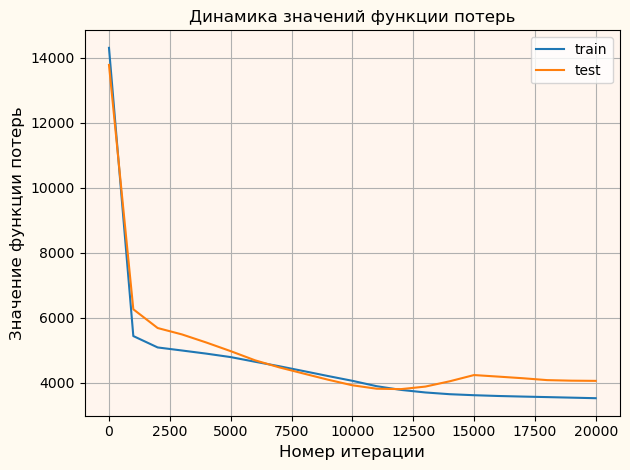

RMSE_test = 13787.4697265625, RMSE_train = 14312.16015625, RMSE_MIN_TEST = 13787.4697265625, epoch = 0
RMSE_test = 6514.97021484375, RMSE_train = 5622.740234375, RMSE_MIN_TEST = 6514.97021484375, epoch = 1000
RMSE_test = 5736.4599609375, RMSE_train = 5118.3798828125, RMSE_MIN_TEST = 5736.4599609375, epoch = 2000
RMSE_test = 5528.3798828125, RMSE_train = 5009.52001953125, RMSE_MIN_TEST = 5528.3798828125, epoch = 3000
RMSE_test = 5262.9501953125, RMSE_train = 4892.33984375, RMSE_MIN_TEST = 5262.47021484375, epoch = 4000
RMSE_test = 4902.58984375, RMSE_train = 4758.10986328125, RMSE_MIN_TEST = 4902.43017578125, epoch = 5000
RMSE_test = 4618.31982421875, RMSE_train = 4616.41015625, RMSE_MIN_TEST = 4618.31982421875, epoch = 6000
RMSE_test = 4433.759765625, RMSE_train = 4453.89990234375, RMSE_MIN_TEST = 4433.5400390625, epoch = 7000
RMSE_test = 4251.60009765625, RMSE_train = 4274.14013671875, RMSE_MIN_TEST = 4248.14990234375, epoch = 8000
RMSE_test = 3996.489990234375, RMSE_train = 4093.9799

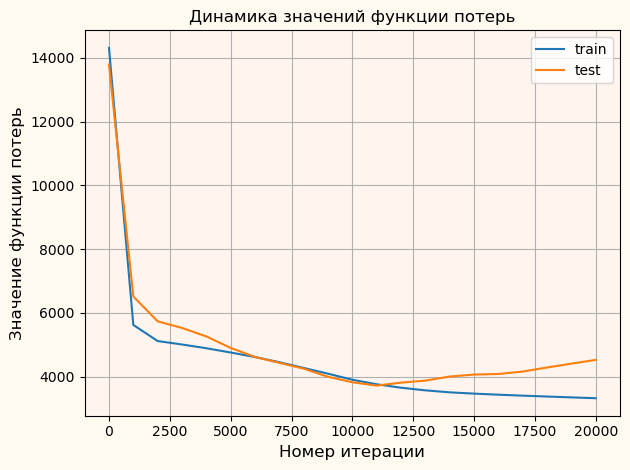

RMSE_test = 13784.759765625, RMSE_train = 14309.83984375, RMSE_MIN_TEST = 13784.759765625, epoch = 0
RMSE_test = 6288.669921875, RMSE_train = 5457.93017578125, RMSE_MIN_TEST = 6288.669921875, epoch = 1000
RMSE_test = 5694.7998046875, RMSE_train = 5108.240234375, RMSE_MIN_TEST = 5694.4501953125, epoch = 2000
RMSE_test = 5494.0, RMSE_train = 5002.22021484375, RMSE_MIN_TEST = 5494.0, epoch = 3000
RMSE_test = 5336.22021484375, RMSE_train = 4936.740234375, RMSE_MIN_TEST = 5336.22021484375, epoch = 4000
RMSE_test = 5203.6298828125, RMSE_train = 4883.27001953125, RMSE_MIN_TEST = 5203.6298828125, epoch = 5000
RMSE_test = 5064.02978515625, RMSE_train = 4823.8798828125, RMSE_MIN_TEST = 5064.02978515625, epoch = 6000
RMSE_test = 4915.18017578125, RMSE_train = 4764.9599609375, RMSE_MIN_TEST = 4915.18017578125, epoch = 7000
RMSE_test = 4717.72021484375, RMSE_train = 4690.43017578125, RMSE_MIN_TEST = 4717.4501953125, epoch = 8000
RMSE_test = 4521.0498046875, RMSE_train = 4616.35009765625, RMSE_MIN_T

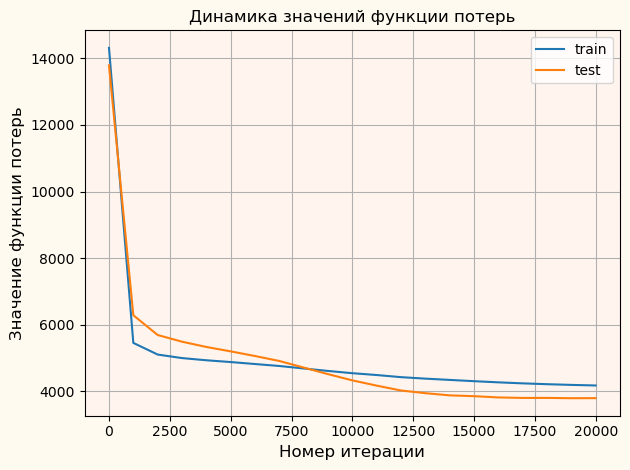

RMSE_test = 13788.48046875, RMSE_train = 14313.240234375, RMSE_MIN_TEST = 13788.48046875, epoch = 0
RMSE_test = 6424.2998046875, RMSE_train = 5562.10986328125, RMSE_MIN_TEST = 6424.2998046875, epoch = 1000
RMSE_test = 5691.759765625, RMSE_train = 5108.2998046875, RMSE_MIN_TEST = 5691.1298828125, epoch = 2000
RMSE_test = 5455.5400390625, RMSE_train = 4980.60009765625, RMSE_MIN_TEST = 5455.31982421875, epoch = 3000
RMSE_test = 5222.33984375, RMSE_train = 4879.22998046875, RMSE_MIN_TEST = 5222.33984375, epoch = 4000
RMSE_test = 4905.419921875, RMSE_train = 4747.02978515625, RMSE_MIN_TEST = 4905.35009765625, epoch = 5000
RMSE_test = 4631.18994140625, RMSE_train = 4627.27001953125, RMSE_MIN_TEST = 4631.18994140625, epoch = 6000
RMSE_test = 4445.9599609375, RMSE_train = 4524.77978515625, RMSE_MIN_TEST = 4444.2998046875, epoch = 7000
RMSE_test = 4320.85986328125, RMSE_train = 4445.27001953125, RMSE_MIN_TEST = 4308.68994140625, epoch = 8000
RMSE_test = 4226.60009765625, RMSE_train = 4369.45996

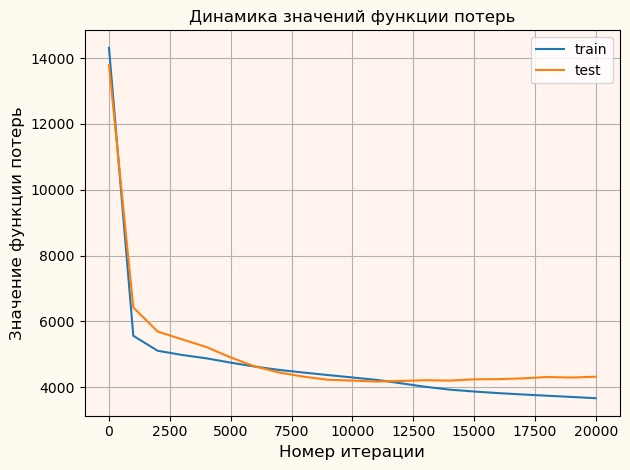

RMSE_test = 13780.8203125, RMSE_train = 14306.419921875, RMSE_MIN_TEST = 13780.8203125, epoch = 0
RMSE_test = 6260.1201171875, RMSE_train = 5433.5, RMSE_MIN_TEST = 6260.1201171875, epoch = 1000
RMSE_test = 5671.1298828125, RMSE_train = 5085.240234375, RMSE_MIN_TEST = 5671.1298828125, epoch = 2000
RMSE_test = 5456.77978515625, RMSE_train = 4989.759765625, RMSE_MIN_TEST = 5456.77978515625, epoch = 3000
RMSE_test = 5224.080078125, RMSE_train = 4900.490234375, RMSE_MIN_TEST = 5224.080078125, epoch = 4000
RMSE_test = 4997.4599609375, RMSE_train = 4812.22998046875, RMSE_MIN_TEST = 4997.4599609375, epoch = 5000
RMSE_test = 4768.52001953125, RMSE_train = 4726.18994140625, RMSE_MIN_TEST = 4768.52001953125, epoch = 6000
RMSE_test = 4545.08984375, RMSE_train = 4639.0400390625, RMSE_MIN_TEST = 4545.08984375, epoch = 7000
RMSE_test = 4350.5498046875, RMSE_train = 4559.009765625, RMSE_MIN_TEST = 4350.5498046875, epoch = 8000
RMSE_test = 4182.91015625, RMSE_train = 4485.93017578125, RMSE_MIN_TEST = 4

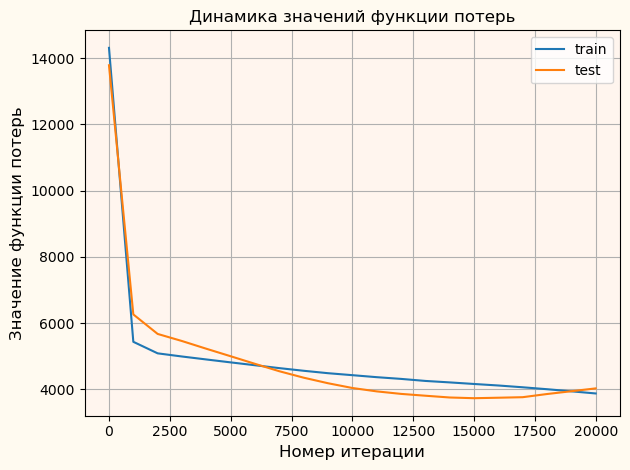

RMSE_test = 13788.0302734375, RMSE_train = 14312.8603515625, RMSE_MIN_TEST = 13788.0302734375, epoch = 0
RMSE_test = 6231.759765625, RMSE_train = 5412.52001953125, RMSE_MIN_TEST = 6231.3701171875, epoch = 1000
RMSE_test = 5656.31005859375, RMSE_train = 5067.39013671875, RMSE_MIN_TEST = 5653.77978515625, epoch = 2000
RMSE_test = 5415.93017578125, RMSE_train = 4948.93017578125, RMSE_MIN_TEST = 5415.93017578125, epoch = 3000
RMSE_test = 5168.77001953125, RMSE_train = 4829.64990234375, RMSE_MIN_TEST = 5166.25, epoch = 4000
RMSE_test = 4893.16015625, RMSE_train = 4711.419921875, RMSE_MIN_TEST = 4893.16015625, epoch = 5000
RMSE_test = 4699.669921875, RMSE_train = 4594.10986328125, RMSE_MIN_TEST = 4698.83984375, epoch = 6000
RMSE_test = 4565.22021484375, RMSE_train = 4484.58984375, RMSE_MIN_TEST = 4563.2900390625, epoch = 7000
RMSE_test = 4475.58984375, RMSE_train = 4364.22021484375, RMSE_MIN_TEST = 4472.56005859375, epoch = 8000
RMSE_test = 4431.18994140625, RMSE_train = 4232.93994140625, RM

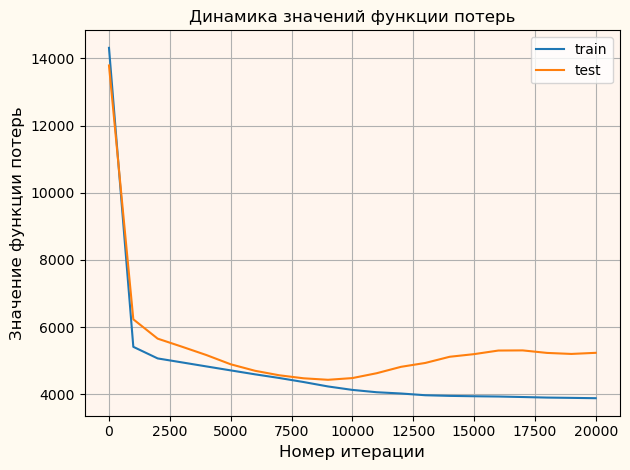

RMSE_test = 13781.509765625, RMSE_train = 14306.9296875, RMSE_MIN_TEST = 13781.509765625, epoch = 0
RMSE_test = 6274.64013671875, RMSE_train = 5441.35009765625, RMSE_MIN_TEST = 6274.64013671875, epoch = 1000
RMSE_test = 5689.9501953125, RMSE_train = 5102.7099609375, RMSE_MIN_TEST = 5689.22021484375, epoch = 2000
RMSE_test = 5476.68994140625, RMSE_train = 4982.22021484375, RMSE_MIN_TEST = 5474.68994140625, epoch = 3000
RMSE_test = 5307.33984375, RMSE_train = 4900.25, RMSE_MIN_TEST = 5307.33984375, epoch = 4000
RMSE_test = 5140.06005859375, RMSE_train = 4825.52001953125, RMSE_MIN_TEST = 5139.47998046875, epoch = 5000
RMSE_test = 4934.02001953125, RMSE_train = 4725.72998046875, RMSE_MIN_TEST = 4933.93017578125, epoch = 6000
RMSE_test = 4695.66015625, RMSE_train = 4596.7001953125, RMSE_MIN_TEST = 4695.66015625, epoch = 7000
RMSE_test = 4500.2998046875, RMSE_train = 4473.2099609375, RMSE_MIN_TEST = 4500.2998046875, epoch = 8000
RMSE_test = 4359.08984375, RMSE_train = 4352.14013671875, RMSE_

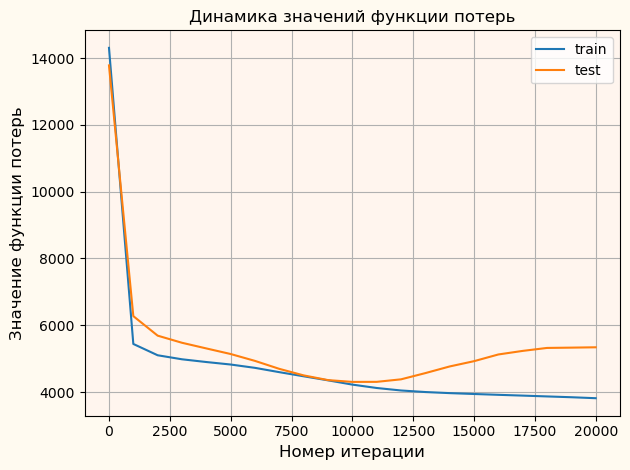

RMSE_test = 13785.4296875, RMSE_train = 14310.2900390625, RMSE_MIN_TEST = 13785.4296875, epoch = 0
RMSE_test = 6291.0, RMSE_train = 5458.06005859375, RMSE_MIN_TEST = 6291.0, epoch = 1000
RMSE_test = 5681.75, RMSE_train = 5087.509765625, RMSE_MIN_TEST = 5681.75, epoch = 2000
RMSE_test = 5461.35986328125, RMSE_train = 4975.08984375, RMSE_MIN_TEST = 5461.1201171875, epoch = 3000
RMSE_test = 5192.0498046875, RMSE_train = 4855.47998046875, RMSE_MIN_TEST = 5192.0498046875, epoch = 4000
RMSE_test = 4902.60986328125, RMSE_train = 4729.259765625, RMSE_MIN_TEST = 4902.60986328125, epoch = 5000
RMSE_test = 4677.81982421875, RMSE_train = 4610.35986328125, RMSE_MIN_TEST = 4677.81982421875, epoch = 6000
RMSE_test = 4469.60009765625, RMSE_train = 4466.27978515625, RMSE_MIN_TEST = 4469.43017578125, epoch = 7000
RMSE_test = 4360.7001953125, RMSE_train = 4326.43994140625, RMSE_MIN_TEST = 4357.72998046875, epoch = 8000
RMSE_test = 4211.3701171875, RMSE_train = 4184.7001953125, RMSE_MIN_TEST = 4211.370117

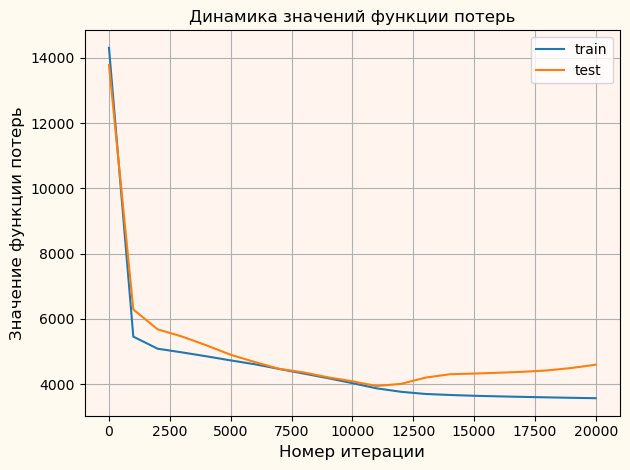

RMSE_test = 13784.1396484375, RMSE_train = 14309.2802734375, RMSE_MIN_TEST = 13784.1396484375, epoch = 0
RMSE_test = 6298.0, RMSE_train = 5478.16015625, RMSE_MIN_TEST = 6298.0, epoch = 1000
RMSE_test = 5686.330078125, RMSE_train = 5093.43994140625, RMSE_MIN_TEST = 5686.330078125, epoch = 2000
RMSE_test = 5512.81982421875, RMSE_train = 5001.27978515625, RMSE_MIN_TEST = 5512.81982421875, epoch = 3000
RMSE_test = 5282.2998046875, RMSE_train = 4893.64990234375, RMSE_MIN_TEST = 5282.10986328125, epoch = 4000
RMSE_test = 4991.5498046875, RMSE_train = 4771.93017578125, RMSE_MIN_TEST = 4991.5498046875, epoch = 5000
RMSE_test = 4659.31005859375, RMSE_train = 4624.43017578125, RMSE_MIN_TEST = 4658.89990234375, epoch = 6000
RMSE_test = 4470.0400390625, RMSE_train = 4496.91015625, RMSE_MIN_TEST = 4467.2001953125, epoch = 7000
RMSE_test = 4356.08984375, RMSE_train = 4381.93017578125, RMSE_MIN_TEST = 4348.0498046875, epoch = 8000
RMSE_test = 4286.330078125, RMSE_train = 4280.35009765625, RMSE_MIN_TE

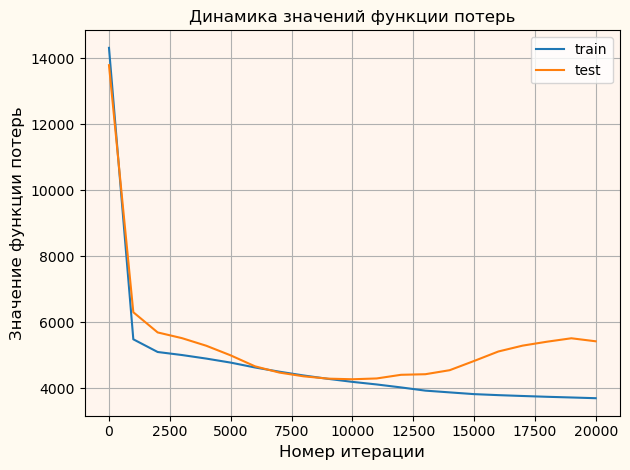

RMSE_test = 13783.1298828125, RMSE_train = 14308.1796875, RMSE_MIN_TEST = 13783.1298828125, epoch = 0
RMSE_test = 6370.830078125, RMSE_train = 5509.91015625, RMSE_MIN_TEST = 6370.830078125, epoch = 1000
RMSE_test = 5730.81982421875, RMSE_train = 5118.89013671875, RMSE_MIN_TEST = 5729.580078125, epoch = 2000
RMSE_test = 5556.10986328125, RMSE_train = 5027.0, RMSE_MIN_TEST = 5553.580078125, epoch = 3000
RMSE_test = 5439.990234375, RMSE_train = 4976.3701171875, RMSE_MIN_TEST = 5439.990234375, epoch = 4000
RMSE_test = 5332.2998046875, RMSE_train = 4935.0, RMSE_MIN_TEST = 5331.22021484375, epoch = 5000
RMSE_test = 5245.919921875, RMSE_train = 4896.75, RMSE_MIN_TEST = 5245.72998046875, epoch = 6000
RMSE_test = 5158.56982421875, RMSE_train = 4859.06982421875, RMSE_MIN_TEST = 5158.1201171875, epoch = 7000
RMSE_test = 5083.7998046875, RMSE_train = 4817.16015625, RMSE_MIN_TEST = 5083.7998046875, epoch = 8000
RMSE_test = 4984.56005859375, RMSE_train = 4765.77001953125, RMSE_MIN_TEST = 4984.560058

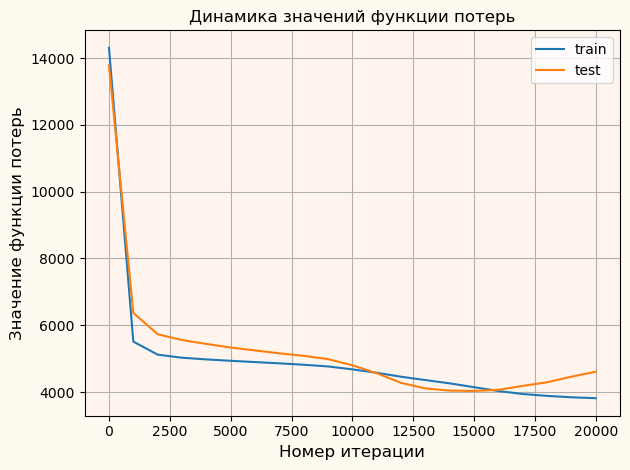

RMSE_test = 13783.0, RMSE_train = 14308.080078125, RMSE_MIN_TEST = 13783.0, epoch = 0
RMSE_test = 6421.3798828125, RMSE_train = 5564.75, RMSE_MIN_TEST = 6421.3798828125, epoch = 1000
RMSE_test = 5706.08984375, RMSE_train = 5109.330078125, RMSE_MIN_TEST = 5704.52978515625, epoch = 2000
RMSE_test = 5526.9599609375, RMSE_train = 5014.39990234375, RMSE_MIN_TEST = 5524.0, epoch = 3000
RMSE_test = 5380.43994140625, RMSE_train = 4946.97021484375, RMSE_MIN_TEST = 5380.43994140625, epoch = 4000
RMSE_test = 5209.56982421875, RMSE_train = 4863.81005859375, RMSE_MIN_TEST = 5209.419921875, epoch = 5000
RMSE_test = 4986.68017578125, RMSE_train = 4759.490234375, RMSE_MIN_TEST = 4986.43017578125, epoch = 6000
RMSE_test = 4730.47998046875, RMSE_train = 4640.81982421875, RMSE_MIN_TEST = 4730.47998046875, epoch = 7000
RMSE_test = 4518.58984375, RMSE_train = 4521.5400390625, RMSE_MIN_TEST = 4518.58984375, epoch = 8000
RMSE_test = 4356.02978515625, RMSE_train = 4412.85986328125, RMSE_MIN_TEST = 4355.100097

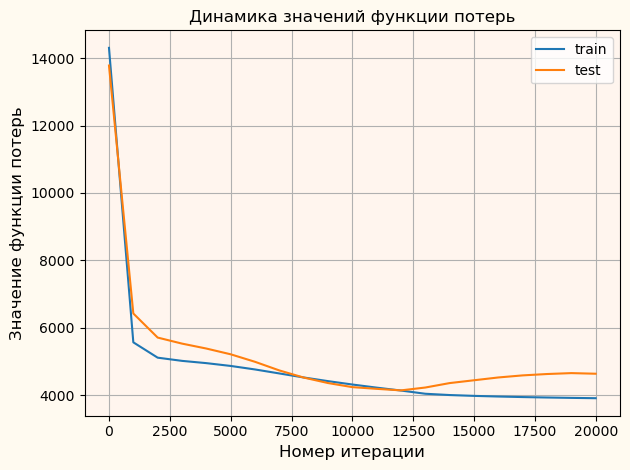

RMSE_test = 13785.240234375, RMSE_train = 14310.240234375, RMSE_MIN_TEST = 13785.240234375, epoch = 0
RMSE_test = 6406.06982421875, RMSE_train = 5540.6201171875, RMSE_MIN_TEST = 6406.06982421875, epoch = 1000
RMSE_test = 5735.16015625, RMSE_train = 5115.47021484375, RMSE_MIN_TEST = 5735.16015625, epoch = 2000
RMSE_test = 5541.10986328125, RMSE_train = 5022.60009765625, RMSE_MIN_TEST = 5540.740234375, epoch = 3000
RMSE_test = 5320.60009765625, RMSE_train = 4930.89013671875, RMSE_MIN_TEST = 5320.60009765625, epoch = 4000
RMSE_test = 5052.3798828125, RMSE_train = 4831.7900390625, RMSE_MIN_TEST = 5052.3798828125, epoch = 5000
RMSE_test = 4826.419921875, RMSE_train = 4746.669921875, RMSE_MIN_TEST = 4826.419921875, epoch = 6000
RMSE_test = 4617.14013671875, RMSE_train = 4663.2099609375, RMSE_MIN_TEST = 4617.14013671875, epoch = 7000
RMSE_test = 4440.8701171875, RMSE_train = 4568.72998046875, RMSE_MIN_TEST = 4440.8701171875, epoch = 8000
RMSE_test = 4277.77978515625, RMSE_train = 4459.8701171

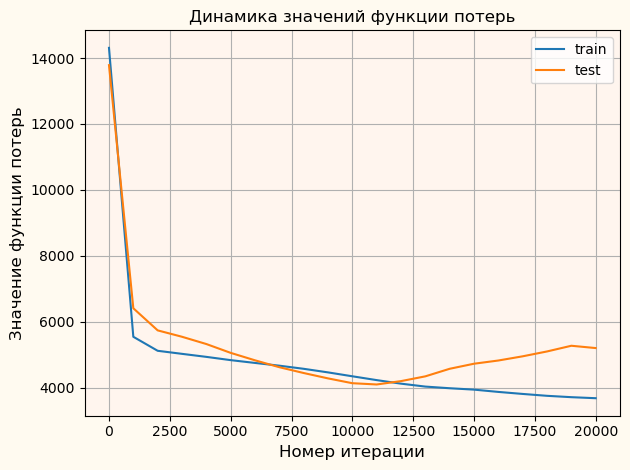

RMSE_test = 13789.1796875, RMSE_train = 14314.1396484375, RMSE_MIN_TEST = 13789.1796875, epoch = 0
RMSE_test = 6383.7001953125, RMSE_train = 5531.43994140625, RMSE_MIN_TEST = 6383.7001953125, epoch = 1000
RMSE_test = 5697.259765625, RMSE_train = 5098.64013671875, RMSE_MIN_TEST = 5697.259765625, epoch = 2000
RMSE_test = 5509.52978515625, RMSE_train = 4999.169921875, RMSE_MIN_TEST = 5506.3701171875, epoch = 3000
RMSE_test = 5320.35986328125, RMSE_train = 4917.10009765625, RMSE_MIN_TEST = 5320.35986328125, epoch = 4000
RMSE_test = 5099.91015625, RMSE_train = 4815.169921875, RMSE_MIN_TEST = 5099.22021484375, epoch = 5000
RMSE_test = 4804.1298828125, RMSE_train = 4685.419921875, RMSE_MIN_TEST = 4804.1298828125, epoch = 6000
RMSE_test = 4555.72021484375, RMSE_train = 4547.77978515625, RMSE_MIN_TEST = 4555.72021484375, epoch = 7000
RMSE_test = 4390.08984375, RMSE_train = 4419.39013671875, RMSE_MIN_TEST = 4387.330078125, epoch = 8000
RMSE_test = 4294.77978515625, RMSE_train = 4301.990234375, R

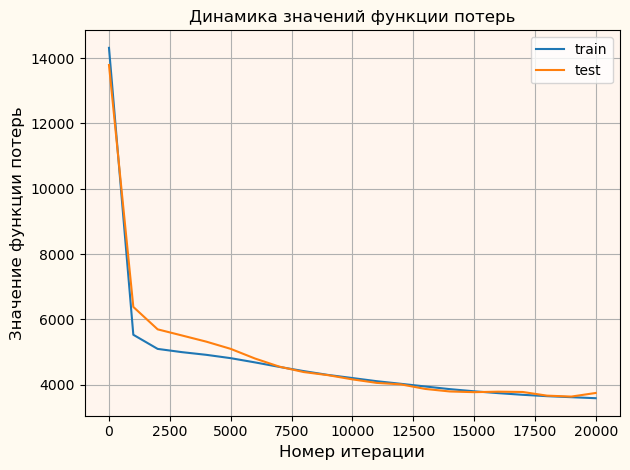

RMSE_test = 13784.4404296875, RMSE_train = 14309.5498046875, RMSE_MIN_TEST = 13784.4404296875, epoch = 0
RMSE_test = 6348.5400390625, RMSE_train = 5500.0498046875, RMSE_MIN_TEST = 6348.5400390625, epoch = 1000
RMSE_test = 5683.14013671875, RMSE_train = 5093.43994140625, RMSE_MIN_TEST = 5682.6201171875, epoch = 2000
RMSE_test = 5488.1298828125, RMSE_train = 4984.97998046875, RMSE_MIN_TEST = 5487.93994140625, epoch = 3000
RMSE_test = 5257.3798828125, RMSE_train = 4872.5, RMSE_MIN_TEST = 5257.22021484375, epoch = 4000
RMSE_test = 4994.740234375, RMSE_train = 4758.56982421875, RMSE_MIN_TEST = 4994.740234375, epoch = 5000
RMSE_test = 4785.89013671875, RMSE_train = 4649.56005859375, RMSE_MIN_TEST = 4785.72021484375, epoch = 6000
RMSE_test = 4639.25, RMSE_train = 4549.990234375, RMSE_MIN_TEST = 4639.06005859375, epoch = 7000
RMSE_test = 4525.31982421875, RMSE_train = 4441.8798828125, RMSE_MIN_TEST = 4523.9501953125, epoch = 8000
RMSE_test = 4442.240234375, RMSE_train = 4334.4501953125, RMSE_M

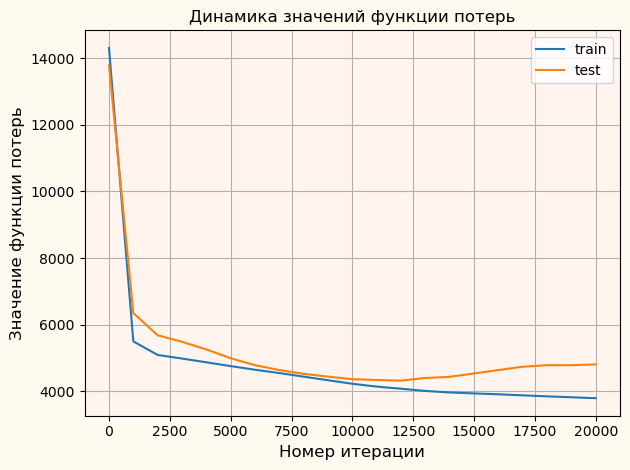

RMSE_test = 13783.6796875, RMSE_train = 14308.7802734375, RMSE_MIN_TEST = 13783.6796875, epoch = 0
RMSE_test = 6430.5, RMSE_train = 5559.25, RMSE_MIN_TEST = 6430.5, epoch = 1000
RMSE_test = 5728.43017578125, RMSE_train = 5141.2998046875, RMSE_MIN_TEST = 5728.43017578125, epoch = 2000
RMSE_test = 5535.18017578125, RMSE_train = 5040.919921875, RMSE_MIN_TEST = 5535.18017578125, epoch = 3000
RMSE_test = 5409.85009765625, RMSE_train = 4981.31982421875, RMSE_MIN_TEST = 5409.740234375, epoch = 4000
RMSE_test = 5281.60009765625, RMSE_train = 4915.740234375, RMSE_MIN_TEST = 5281.60009765625, epoch = 5000
RMSE_test = 5127.58984375, RMSE_train = 4847.93994140625, RMSE_MIN_TEST = 5127.5498046875, epoch = 6000
RMSE_test = 4877.5498046875, RMSE_train = 4751.2900390625, RMSE_MIN_TEST = 4877.5498046875, epoch = 7000
RMSE_test = 4591.22021484375, RMSE_train = 4641.2998046875, RMSE_MIN_TEST = 4591.22021484375, epoch = 8000
RMSE_test = 4355.16015625, RMSE_train = 4554.58984375, RMSE_MIN_TEST = 4347.39990

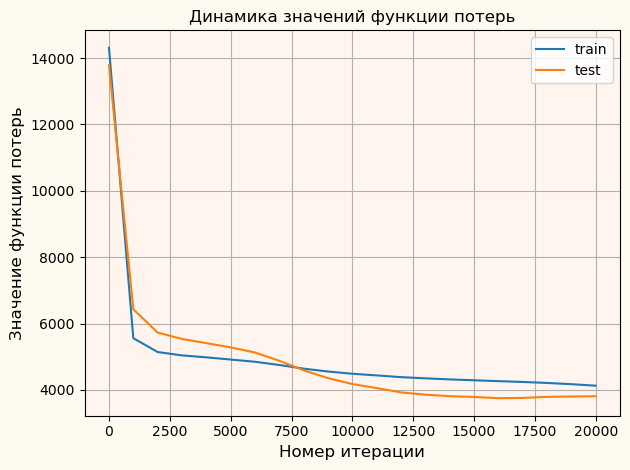

RMSE_test = 13783.490234375, RMSE_train = 14308.419921875, RMSE_MIN_TEST = 13783.490234375, epoch = 0
RMSE_test = 6273.990234375, RMSE_train = 5440.9501953125, RMSE_MIN_TEST = 6273.990234375, epoch = 1000
RMSE_test = 5678.2001953125, RMSE_train = 5089.2001953125, RMSE_MIN_TEST = 5678.2001953125, epoch = 2000
RMSE_test = 5502.7998046875, RMSE_train = 5002.419921875, RMSE_MIN_TEST = 5502.22998046875, epoch = 3000
RMSE_test = 5330.419921875, RMSE_train = 4922.330078125, RMSE_MIN_TEST = 5330.419921875, epoch = 4000
RMSE_test = 5112.4599609375, RMSE_train = 4824.240234375, RMSE_MIN_TEST = 5111.8798828125, epoch = 5000
RMSE_test = 4838.93994140625, RMSE_train = 4703.43994140625, RMSE_MIN_TEST = 4838.93994140625, epoch = 6000
RMSE_test = 4553.43017578125, RMSE_train = 4568.47998046875, RMSE_MIN_TEST = 4552.75, epoch = 7000
RMSE_test = 4307.080078125, RMSE_train = 4431.89990234375, RMSE_MIN_TEST = 4303.3798828125, epoch = 8000
RMSE_test = 4109.72998046875, RMSE_train = 4300.919921875, RMSE_MIN

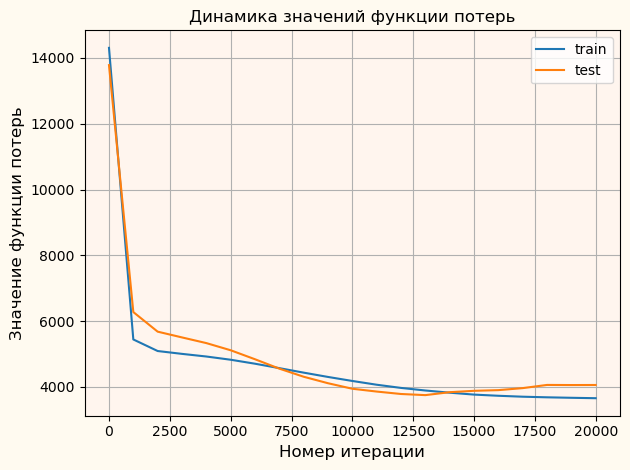

RMSE_test = 13787.0703125, RMSE_train = 14311.669921875, RMSE_MIN_TEST = 13787.0703125, epoch = 0
RMSE_test = 6276.259765625, RMSE_train = 5450.89990234375, RMSE_MIN_TEST = 6276.259765625, epoch = 1000
RMSE_test = 5694.3798828125, RMSE_train = 5097.89990234375, RMSE_MIN_TEST = 5694.3798828125, epoch = 2000
RMSE_test = 5494.1201171875, RMSE_train = 5000.2900390625, RMSE_MIN_TEST = 5494.1201171875, epoch = 3000
RMSE_test = 5318.06005859375, RMSE_train = 4927.83984375, RMSE_MIN_TEST = 5318.06005859375, epoch = 4000
RMSE_test = 5147.93994140625, RMSE_train = 4857.2001953125, RMSE_MIN_TEST = 5147.93994140625, epoch = 5000
RMSE_test = 4949.56005859375, RMSE_train = 4768.18994140625, RMSE_MIN_TEST = 4949.56005859375, epoch = 6000
RMSE_test = 4657.58984375, RMSE_train = 4644.47998046875, RMSE_MIN_TEST = 4657.58984375, epoch = 7000
RMSE_test = 4358.52001953125, RMSE_train = 4516.669921875, RMSE_MIN_TEST = 4358.14013671875, epoch = 8000
RMSE_test = 4135.68994140625, RMSE_train = 4398.68994140625

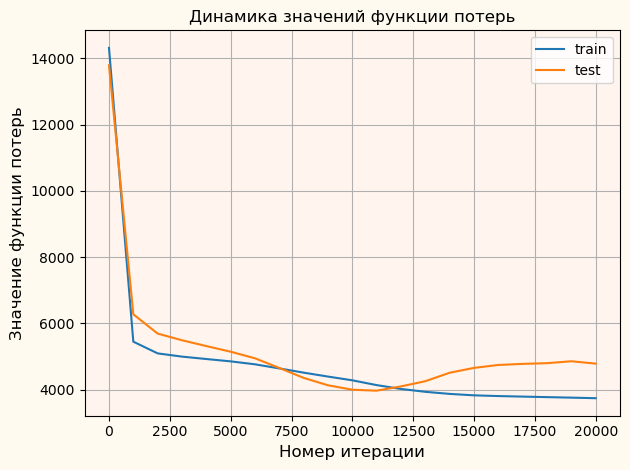

RMSE_test = 13783.990234375, RMSE_train = 14309.0498046875, RMSE_MIN_TEST = 13783.990234375, epoch = 0
RMSE_test = 6364.43017578125, RMSE_train = 5507.0400390625, RMSE_MIN_TEST = 6364.43017578125, epoch = 1000
RMSE_test = 5712.3798828125, RMSE_train = 5130.8701171875, RMSE_MIN_TEST = 5712.3798828125, epoch = 2000
RMSE_test = 5527.7998046875, RMSE_train = 5034.83984375, RMSE_MIN_TEST = 5527.7998046875, epoch = 3000
RMSE_test = 5396.8701171875, RMSE_train = 4976.990234375, RMSE_MIN_TEST = 5396.8701171875, epoch = 4000
RMSE_test = 5310.1201171875, RMSE_train = 4943.9599609375, RMSE_MIN_TEST = 5310.0498046875, epoch = 5000
RMSE_test = 5228.2001953125, RMSE_train = 4907.5, RMSE_MIN_TEST = 5228.2001953125, epoch = 6000
RMSE_test = 5166.22021484375, RMSE_train = 4881.52978515625, RMSE_MIN_TEST = 5163.83984375, epoch = 7000
RMSE_test = 5102.47998046875, RMSE_train = 4851.3701171875, RMSE_MIN_TEST = 5102.35009765625, epoch = 8000
RMSE_test = 5022.10986328125, RMSE_train = 4817.58984375, RMSE_MI

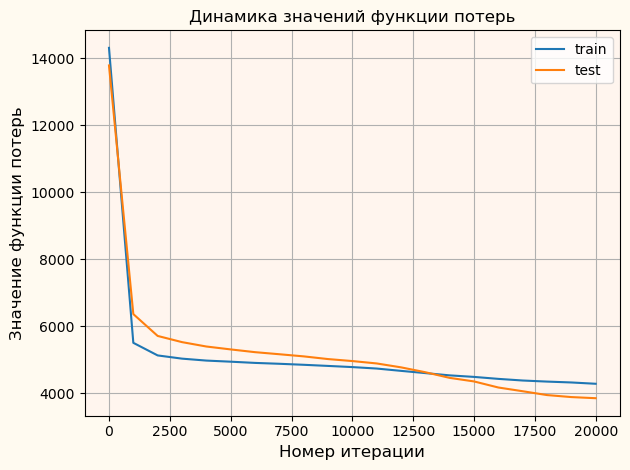

RMSE_test = 13783.7998046875, RMSE_train = 14308.8603515625, RMSE_MIN_TEST = 13783.7998046875, epoch = 0
RMSE_test = 6433.759765625, RMSE_train = 5564.7900390625, RMSE_MIN_TEST = 6433.759765625, epoch = 1000
RMSE_test = 5728.509765625, RMSE_train = 5136.60986328125, RMSE_MIN_TEST = 5728.509765625, epoch = 2000
RMSE_test = 5483.7001953125, RMSE_train = 4989.2900390625, RMSE_MIN_TEST = 5483.39990234375, epoch = 3000
RMSE_test = 5238.93017578125, RMSE_train = 4856.4599609375, RMSE_MIN_TEST = 5237.0400390625, epoch = 4000
RMSE_test = 4974.8701171875, RMSE_train = 4738.580078125, RMSE_MIN_TEST = 4972.14990234375, epoch = 5000
RMSE_test = 4776.7998046875, RMSE_train = 4632.419921875, RMSE_MIN_TEST = 4776.7998046875, epoch = 6000
RMSE_test = 4652.43017578125, RMSE_train = 4531.169921875, RMSE_MIN_TEST = 4651.1201171875, epoch = 7000
RMSE_test = 4578.60986328125, RMSE_train = 4415.93017578125, RMSE_MIN_TEST = 4576.9599609375, epoch = 8000
RMSE_test = 4527.14990234375, RMSE_train = 4300.4101562

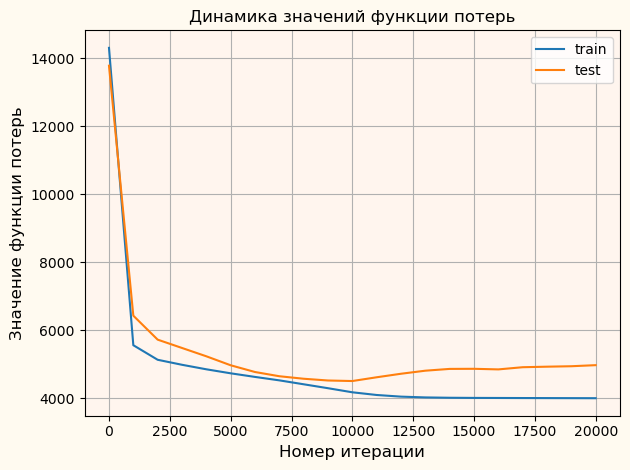

RMSE_test = 13782.2001953125, RMSE_train = 14307.58984375, RMSE_MIN_TEST = 13782.2001953125, epoch = 0
RMSE_test = 6322.169921875, RMSE_train = 5472.509765625, RMSE_MIN_TEST = 6322.169921875, epoch = 1000
RMSE_test = 5710.97998046875, RMSE_train = 5104.39990234375, RMSE_MIN_TEST = 5708.68994140625, epoch = 2000
RMSE_test = 5517.35986328125, RMSE_train = 5004.08984375, RMSE_MIN_TEST = 5516.85009765625, epoch = 3000
RMSE_test = 5311.22998046875, RMSE_train = 4915.93017578125, RMSE_MIN_TEST = 5310.8798828125, epoch = 4000
RMSE_test = 5098.56982421875, RMSE_train = 4825.31982421875, RMSE_MIN_TEST = 5098.35009765625, epoch = 5000
RMSE_test = 4858.9501953125, RMSE_train = 4718.02001953125, RMSE_MIN_TEST = 4858.9501953125, epoch = 6000
RMSE_test = 4592.83984375, RMSE_train = 4588.9501953125, RMSE_MIN_TEST = 4592.72021484375, epoch = 7000
RMSE_test = 4356.47998046875, RMSE_train = 4443.31982421875, RMSE_MIN_TEST = 4356.47998046875, epoch = 8000
RMSE_test = 4166.68994140625, RMSE_train = 4281.9

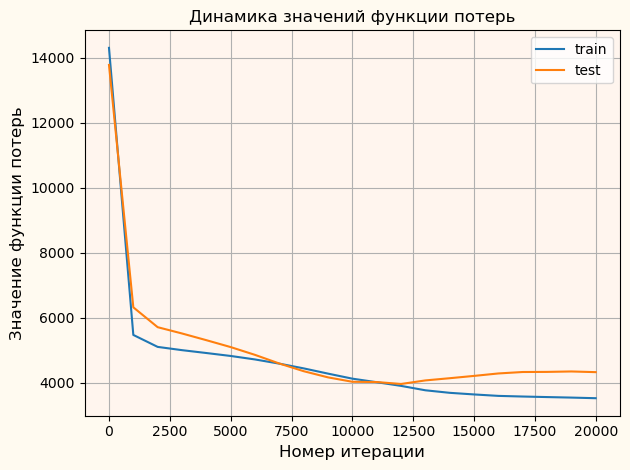

RMSE_test = 13783.169921875, RMSE_train = 14308.259765625, RMSE_MIN_TEST = 13783.169921875, epoch = 0
RMSE_test = 6221.83984375, RMSE_train = 5414.35986328125, RMSE_MIN_TEST = 6221.83984375, epoch = 1000
RMSE_test = 5656.77001953125, RMSE_train = 5084.27001953125, RMSE_MIN_TEST = 5655.81982421875, epoch = 2000
RMSE_test = 5447.5498046875, RMSE_train = 4982.35009765625, RMSE_MIN_TEST = 5447.5498046875, epoch = 3000
RMSE_test = 5230.8798828125, RMSE_train = 4896.85009765625, RMSE_MIN_TEST = 5230.8798828125, epoch = 4000
RMSE_test = 5016.02978515625, RMSE_train = 4815.68017578125, RMSE_MIN_TEST = 5015.47021484375, epoch = 5000
RMSE_test = 4786.25, RMSE_train = 4728.64013671875, RMSE_MIN_TEST = 4786.25, epoch = 6000
RMSE_test = 4552.669921875, RMSE_train = 4642.0400390625, RMSE_MIN_TEST = 4551.3798828125, epoch = 7000
RMSE_test = 4362.56005859375, RMSE_train = 4562.0400390625, RMSE_MIN_TEST = 4359.77978515625, epoch = 8000
RMSE_test = 4188.97998046875, RMSE_train = 4491.81005859375, RMSE_M

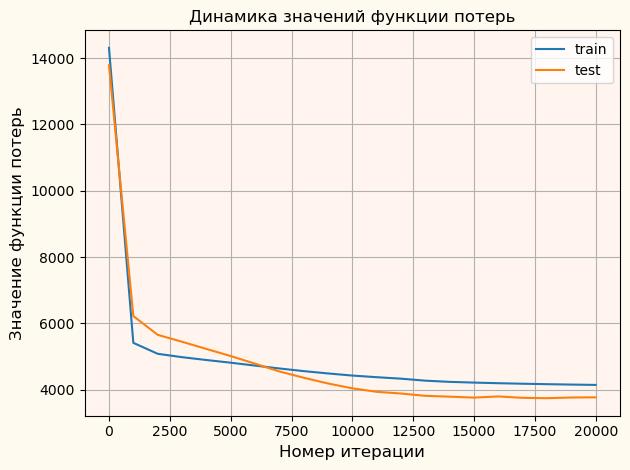

RMSE_test = 13783.7900390625, RMSE_train = 14308.849609375, RMSE_MIN_TEST = 13783.7900390625, epoch = 0
RMSE_test = 6274.83984375, RMSE_train = 5457.7998046875, RMSE_MIN_TEST = 6274.83984375, epoch = 1000
RMSE_test = 5702.93017578125, RMSE_train = 5107.490234375, RMSE_MIN_TEST = 5700.7998046875, epoch = 2000
RMSE_test = 5541.60986328125, RMSE_train = 5016.7998046875, RMSE_MIN_TEST = 5540.990234375, epoch = 3000
RMSE_test = 5379.7001953125, RMSE_train = 4948.580078125, RMSE_MIN_TEST = 5379.5, epoch = 4000
RMSE_test = 5234.31005859375, RMSE_train = 4884.97021484375, RMSE_MIN_TEST = 5234.31005859375, epoch = 5000
RMSE_test = 5055.18017578125, RMSE_train = 4806.43994140625, RMSE_MIN_TEST = 5055.18017578125, epoch = 6000
RMSE_test = 4840.1298828125, RMSE_train = 4706.02978515625, RMSE_MIN_TEST = 4839.25, epoch = 7000
RMSE_test = 4572.330078125, RMSE_train = 4564.97021484375, RMSE_MIN_TEST = 4569.31005859375, epoch = 8000
RMSE_test = 4291.240234375, RMSE_train = 4380.2001953125, RMSE_MIN_TES

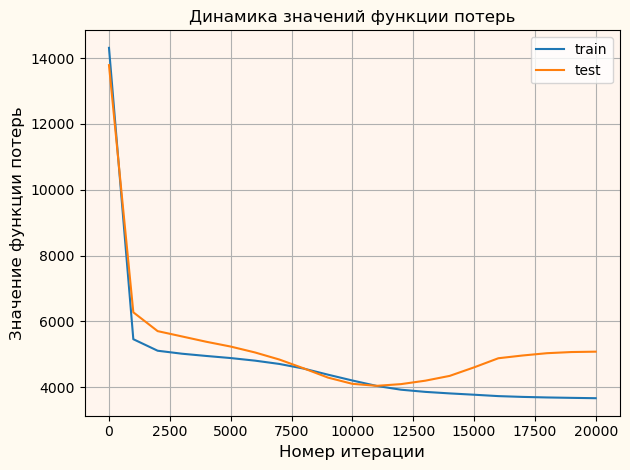

RMSE_test = 13779.6103515625, RMSE_train = 14304.7998046875, RMSE_MIN_TEST = 13779.6103515625, epoch = 0
RMSE_test = 6241.52001953125, RMSE_train = 5417.47021484375, RMSE_MIN_TEST = 6241.52001953125, epoch = 1000
RMSE_test = 5681.33984375, RMSE_train = 5086.27001953125, RMSE_MIN_TEST = 5680.81005859375, epoch = 2000
RMSE_test = 5495.60009765625, RMSE_train = 5002.0, RMSE_MIN_TEST = 5495.10986328125, epoch = 3000
RMSE_test = 5347.27978515625, RMSE_train = 4933.27001953125, RMSE_MIN_TEST = 5345.75, epoch = 4000
RMSE_test = 5134.31982421875, RMSE_train = 4845.60986328125, RMSE_MIN_TEST = 5134.31982421875, epoch = 5000
RMSE_test = 4822.10986328125, RMSE_train = 4688.64013671875, RMSE_MIN_TEST = 4820.3798828125, epoch = 6000
RMSE_test = 4435.27978515625, RMSE_train = 4468.14990234375, RMSE_MIN_TEST = 4435.27978515625, epoch = 7000
RMSE_test = 4128.41015625, RMSE_train = 4222.1298828125, RMSE_MIN_TEST = 4125.22021484375, epoch = 8000
RMSE_test = 4022.929931640625, RMSE_train = 4013.780029296

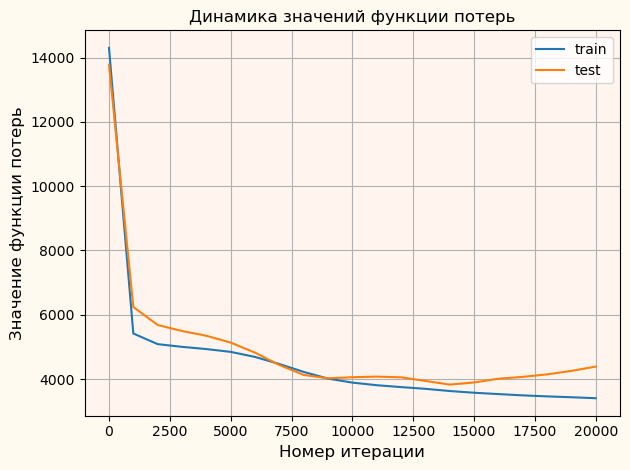

RMSE_test = 13782.150390625, RMSE_train = 14307.3798828125, RMSE_MIN_TEST = 13782.150390625, epoch = 0
RMSE_test = 6265.64990234375, RMSE_train = 5437.4501953125, RMSE_MIN_TEST = 6265.64990234375, epoch = 1000
RMSE_test = 5702.169921875, RMSE_train = 5099.10986328125, RMSE_MIN_TEST = 5701.7001953125, epoch = 2000
RMSE_test = 5543.97998046875, RMSE_train = 5020.75, RMSE_MIN_TEST = 5542.5400390625, epoch = 3000
RMSE_test = 5404.2001953125, RMSE_train = 4957.9599609375, RMSE_MIN_TEST = 5400.3701171875, epoch = 4000
RMSE_test = 5241.4599609375, RMSE_train = 4887.18017578125, RMSE_MIN_TEST = 5241.4599609375, epoch = 5000
RMSE_test = 5054.68017578125, RMSE_train = 4805.759765625, RMSE_MIN_TEST = 5054.68017578125, epoch = 6000
RMSE_test = 4825.27978515625, RMSE_train = 4702.240234375, RMSE_MIN_TEST = 4825.27978515625, epoch = 7000
RMSE_test = 4533.18017578125, RMSE_train = 4563.7998046875, RMSE_MIN_TEST = 4531.759765625, epoch = 8000
RMSE_test = 4267.4599609375, RMSE_train = 4414.68994140625,

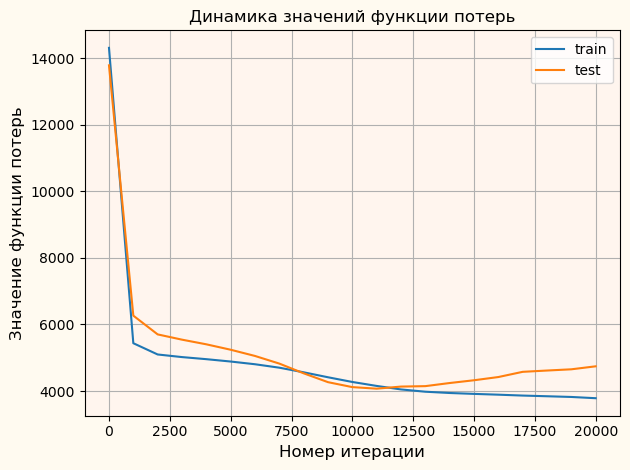

CPU times: user 45min 46s, sys: 50.4 s, total: 46min 36s
Wall time: 45min 58s


In [55]:
%%time

#перебираем число выключаемых нейронов на каждом слое:
for i in range(0, DropCeil_1, DropStep_1):
    for j in range(0, DropCeil_2, DropStep_2):
        
        net = Net_1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, i/10, j/10)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

        xx = []
        yy_train = []
        yy_test = []

        RMSE_MIN_TEST = None

        best_net = None
        
        
        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                optimizer.zero_grad()

                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]

                preds = net.forward(X_batch).flatten()

                loss_value = loss(preds, y_batch)

                loss_value.backward()

                optimizer.step()

            net.eval()
            test_preds = net.forward(X_test).flatten()
            RMSE = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

            if epoch == 0:
                RMSE_MIN_TEST = RMSE
                best_net = copy.deepcopy(net)
            else:
                if RMSE_MIN_TEST > RMSE:
                    RMSE_MIN_TEST = RMSE
                    best_net = copy.deepcopy(net)   

            #ARRAY.append([net.fc1.weight, net.fc1.bias, net.fc2.weight, net.fc2.bias, net.fc3.weight, net.fc3.bias])

            if epoch % 1000 == 0 or epoch == num_epochs - 1:
                net.eval()

                test_preds = net.forward(X_test).flatten()
                RMSE_test = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

                train_preds = net.forward(X_train).flatten()
                RMSE_train = round(np.sqrt(mse(train_preds.detach().numpy(), y_train.detach().numpy())), 2)

                xx.append(epoch)
                yy_train.append(RMSE_train)
                yy_test.append(RMSE_test)

                print(f'RMSE_test = {RMSE_test}, RMSE_train = {RMSE_train}, RMSE_MIN_TEST = {RMSE_MIN_TEST}, epoch = {epoch}')
                #print(f'epoch = {epoch}, RMSE = {RMSE}, RMSE_MIN_TEST = {RMSE_MIN_TEST}')
                
                
        if i == 0 and j == 0:
            RMSE_MIN_TEST_GLOBAL = RMSE_MIN_TEST
            best_net_global = copy.deepcopy(best_net)
        else:
            if RMSE_MIN_TEST_GLOBAL > RMSE_MIN_TEST:
                RMSE_MIN_TEST_GLOBAL = RMSE_MIN_TEST
                best_net_global = copy.deepcopy(best_net)        
        
        print(f'd_1 = {i}, d_2 = {j}, RMSE_MIN_TEST_GLOBAL = {RMSE_MIN_TEST_GLOBAL}')
        fig, ax = plt.subplots()

        ax.plot(xx, yy_train, label='train')
        ax.plot(xx, yy_test, label='test')

        ax.set_xlabel('Номер итерации', fontsize=12)
        ax.set_ylabel('Значение функции потерь', fontsize=12)

        fig.set_facecolor('floralwhite')
        ax.set_facecolor('seashell')

        ax.set_title('Динамика значений функции потерь')

        ax.grid(True)
        fig.tight_layout()

        ax.legend() 
        plt.show()

По графикам можно заметить, что чем больше мы отключаем нейронов во втором слое, тем быстрее переобучается модель. После 6 отключённый нейронов в первом слое и 4 во втором переобучение пошло ещё быстрее. Было принято решение прервать выполнение ячейки. Лучший результат 3649

### Краткие выводы:

- Отключение нейронов привело к улучшению результатов до 3649. В частности d_1 = 4, d_2 = 1 являются оптимальными значениями

## Выводы

- Метод отключения нейронов дал хорошие значения метрики RMSE на тесте = 3649

- Метод перебора размера батчей дал неплохие результаты, но хуже со значениями метрики RMSE на тесте = 4426

- В текущей задаче отключение нейронов показало лучший результат